<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Siemens/Siemens_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SIEDEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 15:30:29,087 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 15:30:29,088 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for SIEDEEUR
2019-08-28 15:33:28,617 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 15:38:07,381 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-28 15:39:53,460 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 15:43:02,307 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 15:46:06,182 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 15:49:18,814 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 15:52:23,108 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 16:08:16,636 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_SIEDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-SIEDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-SIEDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close      Volume
Date                                                               
2018-01-02 08:00:00  1.16037  1.16037  1.14817  1.14927  180.148102
2018-01-02 09:00:00  1.14918  1.15228  1.14177  1.14528  215.898849
2018-01-02 10:00:00  1.14528  1.15168  1.14377  1.14958  158.849991
2018-01-02 11:00:00  1.14958  1.15087  1.14757  1.14857  105.429596
2018-01-02 12:00:00  1.14857  1.14948  1.14718  1.14837  104.159477
...                      ...      ...      ...      ...         ...
2018-12-28 08:00:00  0.96328  0.97518  0.96297  0.97508   33.506767
2018-12-28 09:00:00  0.97508  0.97617  0.97297  0.97548   40.794502
2018-12-28 10:00:00  0.97537  0.97908  0.97477  0.97787   34.831470
2018-12-28 11:00:00  0.97787  0.98108  0.97517  0.97658   33.270996
2018-12-28 12:00:00  0.97648  0.97958  0.97517  0.97788   33.073814

[2247 rows x 5 columns]

Open         High          Low        Close       Volume
count  2247.000000  2247.000000  2247.000000  2247.000000  2247.000000
mean      1.097011     1.099799     1.094210     1.096984    65.699562
std       0.068649     0.068651     0.068720     0.068741    78.435966
min       0.951380     0.954380     0.949670     0.951370     0.005109
25%       1.036370     1.038880     1.033170     1.036370    18.709112
50%       1.099270     1.101780     1.096370     1.099270    32.345478
75%       1.149975     1.152230     1.147175     1.149675    84.548706
max       1.254180     1.256880     1.252770     1.253970   836.192505

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.21918  1.22188  1.21877  1.21967  103.529503    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.217953  1.205484  1.206714  1.220313  1.216155  1.216817    1.214925    1.215230  1.209385  1.216761  1.220388  1.217577  1.218081  1.216761  1.218173  1.207914                1.224628                 1.216761                1.208895                1.228561                 1.216761                1.204961                1.232494                 1.216761                1.201028                1.236428                 1.216761                1.197095  1.216155  1.218836  1.209028                1.224021                 1.216155                1.208288                1.227955                 1.216155                1.204355                1.231888                 1.216155                1.200421                1.235821                 1.216155   
2018-01-09 14:00:00  1.21967  1.21988  1.21477  1.21617  139.522293    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.217864  1.205793  1.207976  1.219395  1.216158  1.216780    1.216325    1.215525  1.210432  1.217647  1.218737  1.218072  1.217950  1.217647  1.217920  1.209026                1.223071                 1.217647                1.212224                1.225783                 1.217647                1.209512                1.228495                 1.217647                1.206800                1.231206                 1.217647                1.204088  1.216158  1.217189  1.210154                1.221582                 1.216158                1.210734                1.224293                 1.216158                1.208023                1.227005                 1.216158                1.205311                1.229717                 1.216158   
2018-01-09 15:00:00  1.21617  1.21968  1.21518  1.21768  162.990295    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000    2197.000000  2197.000000   2197.000000     2197.000000       2197.000000  2197.000000  2197.000000  2197.000000  2197.000000   2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000   
mean      1.094994     1.097757     1.092180     1.094942    64.172073    15.961766     2.030951   184.352299      30.415567    11.377788      0.032317        0.024124          0.004096     6.563041     2.522986    26.903050     2.030951      1.989076    26.903050     1.095329     1.096007     0.054133     1.094943     1.095331     1.094942     1.095266     1.095184     1.095667     1.095330     1.094937     1.095329     1.095200     1.095330     1.095039     1.096102                1.104167                 1.095330                1.086493                1.108586                 1.095330                1.082074                1.113004                 1.095330                1.077656                1.117423                 1.095330                1.073237     1.095331     1.095028     1.095990                1.104168                 1.095331                1.086494                1.108587                 1.095331                1.082075                1.113005   
std       0.068003     0.067973     0.068059     0.068063    78.444832     8.549779     1.407418   101.376252       0.857196     2.623145      0.176880        0.153468          0.063887     3.337737     1.100192    14.482172     1.407418      1.400582    14.482172     0.067868     0.067022     1.095997     0.068186     0.067736     0.067497     0.067847     0.067793     0.068189     0.067858     0.068122     0.067909     0.067893     0.067858     0.067980     0.067360                0.067750                 0.067858                0.068495                0.067896                 0.067858                0.069009                0.068174                 0.067858                0.069648                0.068584                 0.067858                0.070410     0.067736     0.067973     0.067436                0.067621                 0.067736                0.068382                0.067764                 0.067736                0.068899                0.068040   
min       0.951380     0.954380     0.949670     0.951370     0.005109     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.884412  0.884297  0.887826  0.886649  0.123805    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.900092  0.859651  0.985609  0.892957  0.884064  0.896063    0.878167    0.875499  0.845398  0.884548  0.891143  0.889782  0.889727  0.884548  0.881542  0.860552                0.884805                 0.884548                0.879658                0.878860                 0.884548                0.878405                0.813330                 0.884548                0.877220                0.756492                 0.884548                0.876097  0.884064  0.887477  0.863769                0.879189                 0.884064                0.879842                0.872742                 0.884064                0.878583                0.833181                 0.884064                0.877393                0.771507                 0.884064   
2018-01-09 14:00:00  0.886031  0.877686  0.874629  0.875082  0.166849    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.899782  0.860786  0.986113  0.889920  0.884076  0.895934    0.882925    0.876520  0.848808  0.887552  0.885716  0.891455  0.889283  0.887552  0.880702  0.864522                0.879530                 0.887552                0.890532                0.869511                 0.887552                0.892858                0.800877                 0.887552                0.895059                0.741376                 0.887552                0.897144  0.884076  0.882000  0.867765                0.870884                 0.884076                0.887844                0.860372                 0.884076                0.890248                0.817436                 0.884076                0.892523                0.753284                 0.884076   
2018-01-09 15:00:00  0.874472  0.877025  0.875982  0.880073  0.194915    9          1          9         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcf8v74lr
  JVM stdout: /tmp/tmpcf8v74lr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcf8v74lr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_i4e6yk
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.542112  0.690607              0.483023  0.498730  0.248731
1  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.541988  6.151930              0.479089  0.666612  0.444371
2  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.539627  2.544816              0.500000  0.604455  0.365366
3              DeepLearning_1_AutoML_20190828_161833  0.538427  0.696216              0.500000  0.501464  0.251466
4  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.529027  0.764892              0.495652  0.529621  0.280498
5  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.500000  0.692339              0.500000  0.499596  0.249596
6  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.500000  0.692509              0.500000  0.499681  0.249681
7  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.500000  0.692574              0.500000  0.499713  0.249713
8  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.500000  0.734052              0.500000  0.518852  0.269207
9  DeepLearning_grid_1_AutoML_20190828_161833_mod...  0.456977  1.012749              0.491304  0.590562  0.348764

variable  relative_importance  scaled_importance  percentage
0                 HT_TRENDMODE             1.000000           1.000000    0.001129
1                   aroonup_20             0.992926           0.992926    0.001121
2                        FLOOR             0.964714           0.964714    0.001089
3                         DX_8             0.960090           0.960090    0.001084
4           CDLIDENTICAL3CROWS             0.959745           0.959745    0.001083
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_12_7_2             0.785270           0.785270    0.000886
1029  BBANDS_middleband_12_4_3             0.784289           0.784289    0.000885
1030   BBANDS_upperband_20_2_5             0.781561           0.781561    0.000882
1031               CDLHIGHWAVE             0.780585           0.780585    0.000881
1032  BBANDS_middleband_24_1_2             0.774378           0.774378    0.000874

[1033 rows x 4 columns]

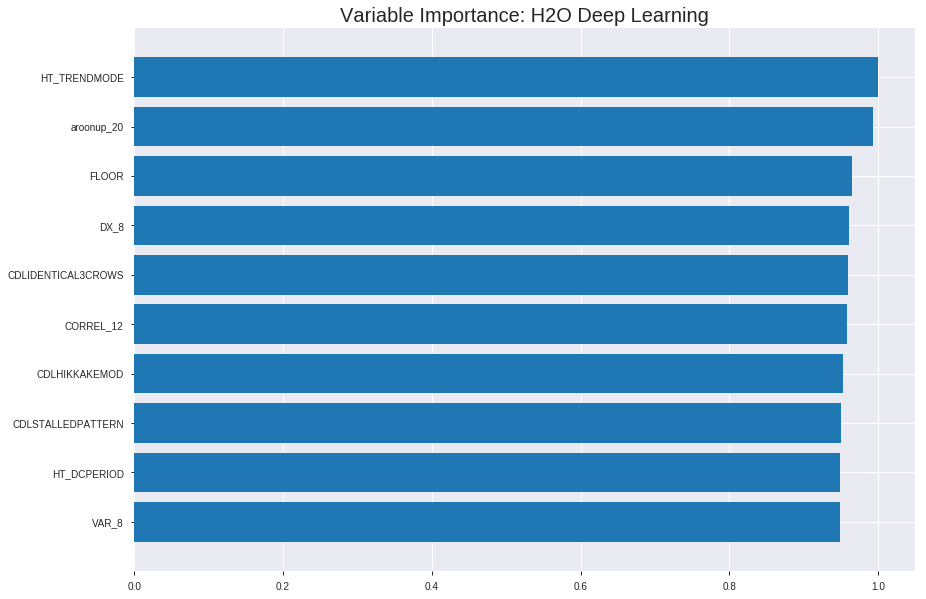

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_161833_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2563879226414136
RMSE: 0.5063476302318533
LogLoss: 0.7069006413960414
Mean Per-Class Error: 0.4558919171595228
AUC: 0.555500511486427
pr_auc: 0.5689699522952565
Gini: 0.11100102297285397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26688533686852756: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   746   0.9868   (746.0/756.0)
1      4    777   0.0051   (4.0/781.0)
Total  14   1523  0.488    (750.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.266885     0.674479  390
max f2                       0.148591     0.837803  399
max f0point5                 0.311703     0.568093  344
max accuracy                 0.418249     0.544567  196
max precision                0.686768     1         0
max recall                   0.148591     1         399
max specificity              0.686768     1         0
max absolute_mcc             0.490576     0.117728  61
max min_per_class_accuracy   0.424265     0.535211  185
max mean_per_class_accuracy  0.418249     0.544108  196

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 41.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.595221           1.35299   1.35299            0.6875           0.636456  0.6875                      0.636456            0.0140845       0.0140845                  35.2993   35.2993
    2        0.0201692                   0.541863           1.57439   1.46012            0.8              0.566441  0.741935                    0.602578            0.0153649       0.0294494                  57.4392   46.0121
    3        0.0305791                   0.515861           1.35299   1.42365            0.6875           0.529454  0.723404                    0.577685            0.0140845       0.0435339                  35.2993   42.3652
    4        0.0403383                   0.50247            1.57439   1.46012            0.8              0.508964  0.741935                    0.561059            0.0153649       0.0588988                  57.4392   46.0121
    5        0.0500976                   0.494419           1.31199   1.43127            0.666667         0.499027  0.727273                    0.548975            0.0128041       0.0717029                  31.1993   43.1265
    6        0.100195                    0.486263           1.15012   1.29069            0.584416         0.489911  0.655844                    0.519443            0.0576184       0.129321                   15.0124   29.0695
    7        0.150293                    0.479744           1.07345   1.21828            0.545455         0.482616  0.619048                    0.507167            0.0537772       0.183099                   7.3449    21.8279
    8        0.20039                     0.474434           0.945657  1.15012            0.480519         0.476865  0.584416                    0.499592            0.0473752       0.230474                   -5.43426  15.0124
    9        0.299935                    0.461587           1.10619   1.13554            0.562092         0.46775   0.577007                    0.489024            0.110115        0.340589                   10.619    13.5543
    10       0.40013                     0.446472           0.971216  1.09439            0.493506         0.454568  0.556098                    0.480396            0.0973111       0.4379                     -2.87843  9.43943
    11       0.500325                    0.423715           0.983995  1.07229            0.5              0.435597  0.544863                    0.471424            0.0985915       0.536492                   -1.60051  7.22857
    12       0.59987                     0.399515           0.926113  1.04803            0.470588         0.41194   0.532538                    0.461553            0.0921895       0.628681                   -7.38872  4.80293
    13       0.700065                    0.380238           0.971216  1.03704            0.493506         0.38952   0.526952                    0.451244            0.0973111       0.725992                   -2.87843  3.70355
    14       0.79961                     0.353629           1.02901   1.03604            0.522876         0.366335  0.526444                    0.440673            0.102433        0.828425                   2.90143   3.60369
    15       0.899805                    0.318697           0.779528  1.00747            0.396104         0.336352  0.511931                    0.429057            0.078105        0.90653                    -22.0472  0.747415
    16       1                           0.148591           0.932878  1                  0.474026         0.293355  0.508133                    0.41546         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2490305304321153
RMSE: 0.49902958873409026
LogLoss: 0.6911753106613914
Mean Per-Class Error: 0.45285565939771544
AUC: 0.5337798546209761
pr_auc: 0.5231332521781333
Gini: 0.0675597092419522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3209863355990611: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    214  0        (0.0/214.0)
Total  2    437  0.508    (223.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320986     0.65745   397
max f2                       0.320986     0.827533  397
max f0point5                 0.423761     0.548317  369
max accuracy                 0.49249      0.551253  130
max precision                0.540071     0.6875    14
max recall                   0.320986     1         397
max specificity              0.548786     0.995556  0
max absolute_mcc             0.49249      0.100077  130
max min_per_class_accuracy   0.484956     0.52      195
max mean_per_class_accuracy  0.492346     0.547144  134

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.544785           1.23084   1.23084            0.6              0.546406  0.6                         0.546406            0.0140187       0.0140187                  23.0841   23.0841
    2        0.0205011                   0.542537           1.0257    1.13967            0.5              0.543914  0.555556                    0.545298            0.00934579      0.0233645                  2.57009   13.9668
    3        0.0318907                   0.54094            1.64112   1.31876            0.8              0.542101  0.642857                    0.544156            0.0186916       0.0420561                  64.1121   31.8758
    4        0.0410023                   0.538673           1.0257    1.25363            0.5              0.540171  0.611111                    0.543271            0.00934579      0.0514019                  2.57009   25.3634
    5        0.0501139                   0.532307           1.53855   1.30544            0.75             0.533995  0.636364                    0.541584            0.0140187       0.0654206                  53.8551   30.5438
    6        0.100228                    0.512626           0.932455  1.11895            0.454545         0.5222    0.545455                    0.531892            0.046729        0.11215                    -6.75446  11.8946
    7        0.150342                    0.503587           1.0257    1.08786            0.5              0.507722  0.530303                    0.523835            0.0514019       0.163551                   2.57009   8.78646
    8        0.200456                    0.498599           1.30544   1.14226            0.636364         0.500838  0.556818                    0.518086            0.0654206       0.228972                   30.5438   14.2258
    9        0.300683                    0.493505           1.07232   1.11895            0.522727         0.496074  0.545455                    0.510749            0.107477        0.336449                   7.23237   11.8946
    10       0.400911                    0.49032            0.885833  1.06067            0.431818         0.491751  0.517045                    0.506               0.088785        0.425234                   -11.4167  6.0668
    11       0.501139                    0.484956           0.979078  1.04435            0.477273         0.488012  0.509091                    0.502402            0.0981308       0.523364                   -2.09218  4.435
    12       0.599089                    0.477381           0.858726  1.014              0.418605         0.481011  0.494297                    0.498905            0.0841121       0.607477                   -14.1274  1.40009
    13       0.699317                    0.471269           0.979078  1.009              0.477273         0.474772  0.491857                    0.495446            0.0981308       0.705607                   -2.09218  0.899571
    14       0.799544                    0.46102            1.07232   1.01693            0.522727         0.467192  0.495726                    0.491904            0.107477        0.813084                   7.23237   1.69343
    15       0.899772                    0.434159           0.932455  1.00752            0.454545         0.451245  0.491139                    0.487375            0.0934579       0.906542                   -6.75446  0.752396
    16       1                           0.283833           0.932455  1                  0.454545         0.397805  0.487472                    0.478398          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:32:06  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:32:08  8 min 24.543 sec   334 obs/sec       0.335719  1             516        0.616174         1.48905             -0.519082      0.507919        0.493504           0.737996         0.476903                         0.65951            1.70676               -0.740908        0.484403          0.481234             1.23084            0.510251
    2019-08-28 16:32:30  8 min 46.210 sec   456 obs/sec       6.26545   19            9630       0.506348         0.706901            -0.0258231     0.555501        0.56897            1.35299          0.487964                         0.49903            0.691175              0.00325207       0.53378           0.523133             1.23084            0.507973
    2019-08-28 16:32:52  9 min  8.206 sec   473 obs/sec       12.6246   38            19404      0.496715         0.686389            0.0128345      0.544451        0.562485           1.35299          0.479506                         0.500891           0.694932              -0.00419707      0.500852          0.506564             1.23084            0.505695
    2019-08-28 16:33:13  9 min 29.573 sec   501 obs/sec       19.6936   59            30269      0.494509         0.681549            0.0215855      0.579529        0.592101           1.72199          0.474951                         0.502437           0.698069              -0.0104073       0.483043          0.479033             0.41028            0.512528
    2019-08-28 16:33:34  9 min 50.792 sec   522 obs/sec       27.0026   81            41503      0.492709         0.677638            0.028693       0.595678        0.614901           1.72199          0.45218                          0.514865           0.724173              -0.0610093       0.49622           0.49743              0.820561           0.512528
    2019-08-28 16:33:55  10 min 11.822 sec  545 obs/sec       34.9135   105           53662      0.492935         0.678089            0.0278023      0.558091        0.612094           1.59899          0.469096                         0.499873           0.692893              -0.000118549     0.493904          0.434885             0.820561           0.512528
    2019-08-28 16:34:17  10 min 33.361 sec  572 obs/sec       43.8627   132           67417      0.488893         0.66897             0.0436806      0.592117        0.64023            1.72199          0.459336                         0.501318           0.695851              -0.00591135      0.501059          0.488328             0.41028            0.507973
    2019-08-28 16:34:19  10 min 35.545 sec  572 obs/sec       43.8627   132           67417      0.506348         0.706901            -0.0258231     0.555501        0.56897            1.35299          0.487964                         0.49903            0.691175              0.00325207       0.53378           0.523133             1.23084            0.507973

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE              1.0                    1.0                  0.0011286418324038155
aroonup_20                0.9929256439208984     0.9929256439208984   0.0011206574181956213
FLOOR                     0.9647141695022583     0.9647141695022583   0.0010888167680129538
DX_8                      0.960090160369873      0.960090160369873    0.0010835979178727266
CDLIDENTICAL3CROWS        0.9597447514533997     0.9597447514533997   0.0010832080749203095
---                       ---                    ---                  ---
BBANDS_middleband_12_7_2  0.7852700352668762     0.7852700352668762   0.000886288611535416
BBANDS_middleband_12_4_3  0.784288763999939      0.784288763999939    0.0008851811077346147
BBANDS_upperband_20_2_5   0.7815609574317932     0.7815609574317932   0.0008821023911310996
CDLHIGHWAVE               0.7805852293968201     0.7805852293968201   0.0008810011436537797
BBANDS_middleband_24_1_2  0.774377703666687      0.774377703666687    0.0008739950704390284


See the whole table with table.as_data_frame()


('accuracy', 0.5681818181818182)

('F1', 0.6520376175548589)

('auc', 0.542111801242236)

('logloss', 0.6906070444467378)

('mean_per_class_error', 0.43498964803312634)

('rmse', 0.49872968874855755)

('mse', 0.24873130243923308)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


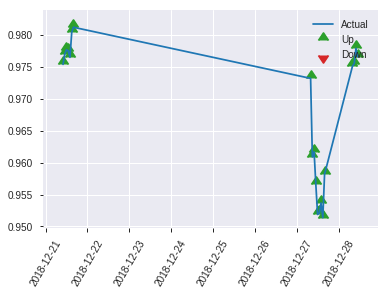


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24873130243923308
RMSE: 0.49872968874855755
LogLoss: 0.6906070444467378
Mean Per-Class Error: 0.43498964803312634
AUC: 0.542111801242236
pr_auc: 0.5069750507872097
Gini: 0.08422360248447203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4527477540244816: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    110  0.9565   (110.0/115.0)
1      1    104  0.0095   (1.0/105.0)
Total  6    214  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452748     0.652038  213
max f2                       0.443104     0.821596  218
max f0point5                 0.476528     0.542823  180
max accuracy                 0.508814     0.568182  93
max precision                0.55769      1         0
max recall                   0.443104     1         218
max specificity              0.55769      1         0
max absolute_mcc             0.508814     0.131283  93
max min_per_class_accuracy   0.503851     0.552381  107
max mean_per_class_accuracy  0.508814     0.56501   93

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 50.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.553999           1.39683   1.39683            0.666667         0.555901  0.666667                    0.555901            0.0190476       0.0190476                  39.6825   39.6825
    2        0.0227273                   0.549968           1.04762   1.25714            0.5              0.550828  0.6                         0.553872            0.00952381      0.0285714                  4.7619    25.7143
    3        0.0318182                   0.548559           2.09524   1.4966             1                0.548945  0.714286                    0.552464            0.0190476       0.047619                   109.524   49.6599
    4        0.0409091                   0.546916           0         1.16402            0                0.548373  0.555556                    0.551555            0               0.047619                   -100      16.4021
    5        0.05                        0.546095           1.04762   1.14286            0.5              0.546477  0.545455                    0.550632            0.00952381      0.0571429                  4.7619    14.2857
    6        0.1                         0.542298           0.952381  1.04762            0.454545         0.544457  0.5                         0.547545            0.047619        0.104762                   -4.7619   4.7619
    7        0.15                        0.539839           0.761905  0.952381           0.363636         0.541014  0.454545                    0.545368            0.0380952       0.142857                   -23.8095  -4.7619
    8        0.2                         0.534619           1.33333   1.04762            0.636364         0.536806  0.5                         0.543227            0.0666667       0.209524                   33.3333   4.7619
    9        0.3                         0.525177           1.2381    1.11111            0.590909         0.53127   0.530303                    0.539241            0.12381         0.333333                   23.8095   11.1111
    10       0.4                         0.510787           1.14286   1.11905            0.545455         0.517562  0.534091                    0.533822            0.114286        0.447619                   14.2857   11.9048
    11       0.5                         0.501201           1.04762   1.10476            0.5              0.507191  0.527273                    0.528495            0.104762        0.552381                   4.7619    10.4762
    12       0.6                         0.493678           0.571429  1.01587            0.272727         0.496579  0.484848                    0.523176            0.0571429       0.609524                   -42.8571  1.5873
    13       0.7                         0.487351           1.04762   1.02041            0.5              0.490708  0.487013                    0.518538            0.104762        0.714286                   4.7619    2.04082
    14       0.8                         0.477634           1.04762   1.02381            0.5              0.481795  0.488636                    0.513945            0.104762        0.819048                   4.7619    2.38095
    15       0.9                         0.466057           0.952381  1.01587            0.454545         0.472951  0.484848                    0.50939             0.0952381       0.914286                   -4.7619   1.5873
    16       1                           0.442871           0.857143  1                  0.409091         0.455758  0.477273                    0.504027            0

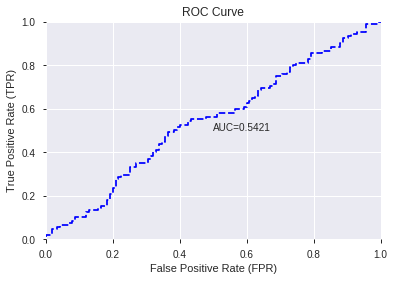

This function is available for GLM models only


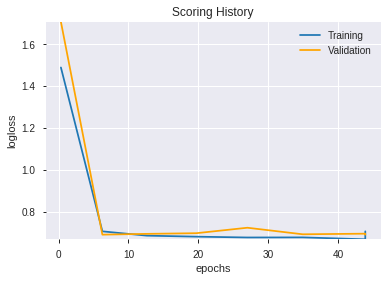

--2019-08-28 16:44:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  14.4MB/s    in 26s     

2019-08-28 16:44:51 (13.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_161833_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_161833_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_164503_model_7  0.566211  0.745306              0.500000  0.520751  0.271182
1  DeepLearning_grid_1_AutoML_20190828_164503_model_4  0.550766  2.687406              0.474741  0.641922  0.412064
2  DeepLearning_grid_1_AutoML_20190828_164503_model_3  0.547246  3.484811              0.486957  0.698582  0.488016
3  DeepLearning_grid_1_AutoML_20190828_164503_model_2  0.546667  5.345193              0.500000  0.684172  0.468092
4  DeepLearning_grid_1_AutoML_20190828_164503_model_5  0.531760  0.836072              0.491304  0.553449  0.306306
5  DeepLearning_grid_1_AutoML_20190828_164503_model_1  0.531346  7.955849              0.500000  0.698541  0.487959
6  DeepLearning_grid_1_AutoML_20190828_164503_model_6  0.516605  0.718036              0.500000  0.511418  0.261548
7               DeepLearning_1_AutoML_20190828_164503  0.504679  1.125056              0.471636  0.596995  0.356403
8  DeepLearning_grid_1_AutoML_20190828_164503_model_8  0.468820  0.699126              0.500000  0.502976  0.252985
9  DeepLearning_grid_1_AutoML_20190828_164503_model_9  0.432878  0.695315              0.500000  0.501076  0.251077

variable  relative_importance  scaled_importance  percentage
0            CDLHOMINGPIGEON             1.000000           1.000000    0.021207
1         CDLMORNINGDOJISTAR             0.998547           0.998547    0.021176
2                      VAR_8             0.976845           0.976845    0.020716
3              days_in_month             0.975486           0.975486    0.020687
4            CDLLADDERBOTTOM             0.971588           0.971588    0.020605
5               CDLTHRUSTING             0.971209           0.971209    0.020597
6          CDLSTALLEDPATTERN             0.967360           0.967360    0.020515
7                        OBV             0.966012           0.966012    0.020486
8             CDLMATCHINGLOW             0.965829           0.965829    0.020482
9                     VAR_24             0.965812           0.965812    0.020482
10                       day             0.963323           0.963323    0.020429
11             CDLHIKKAKEMOD             0.961672           0.961672    0.020394
12   BBANDS_upperband_20_3_5             0.960814           0.960814    0.020376
13        CDLIDENTICAL3CROWS             0.960046           0.960046    0.020360
14                    ADX_24             0.959407           0.959407    0.020346
15                aroonup_20             0.958688           0.958688    0.020331
16                weekofyear             0.957839           0.957839    0.020313
17                AROONOSC_8             0.954739           0.954739    0.020247
18           CDLADVANCEBLOCK             0.952991           0.952991    0.020210
19                 CORREL_30             0.952423           0.952423    0.020198
20                    SAREXT             0.952266           0.952266    0.020195
21       CDLGAPSIDESIDEWHITE             0.951431           0.951431    0.020177
22                    ROC_20             0.948086           0.948086    0.020106
23                   KAMA_24             0.944792           0.944792    0.020036
24                 dayofweek             0.944771           0.944771    0.020036
25                     FLOOR             0.944387           0.944387    0.020028
26                     DX_14             0.943569           0.943569    0.020010
27                     DX_24             0.942284           0.942284    0.019983
28         CDLGRAVESTONEDOJI             0.940174           0.940174    0.019938
29   BBANDS_upperband_24_3_2             0.938678           0.938678    0.019907
30                      DX_8             0.933953           0.933953    0.019806
31              STOCHF_fastk             0.932655           0.932655    0.019779
32                  CORREL_8             0.932353           0.932353    0.019773
33                 PLUS_DM_8             0.932083           0.932083    0.019767
34                PLUS_DI_20             0.931515           0.931515    0.019755
35    BBANDS_lowerband_8_3_4             0.930525           0.930525    0.019734
36                     DX_12             0.928848           0.928848    0.019698
37                    RSI_12             0.928607           0.928607    0.019693
38               HT_DCPERIOD             0.925237           0.925237    0.019622
39            STOCHRSI_fastd             0.923405           0.923405    0.019583
40                aroonup_30             0.923005           0.923005    0.019574
41            CDLEVENINGSTAR             0.922719           0.922719    0.019568
42                    BETA_8             0.920343           0.920343    0.019518
43  BBANDS_middleband_14_4_5             0.915828           0.915828    0.019422
44                       DIV             0.911112           0.911112    0.019322
45                    CCI_30             0.910240           0.910240    0.019304
46              CDLTASUKIGAP             0.898446           0.898446    0.019053
47   BBANDS_lowerband_12_2_3             0.895864           0.895864    0.018999
48                 CORREL_12             0.886062  

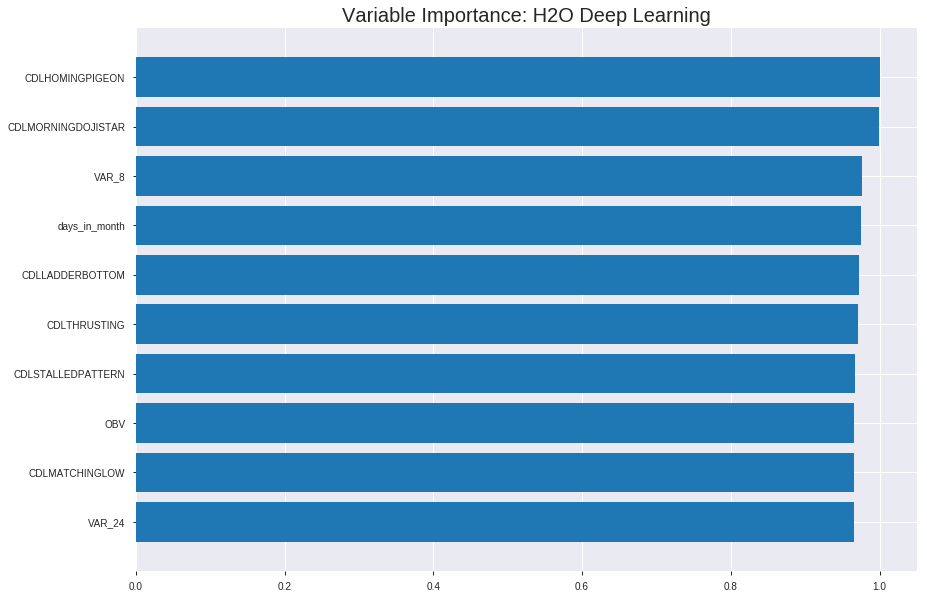

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_164503_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28970251999978225
RMSE: 0.5382402065990446
LogLoss: 0.8010655242713554
Mean Per-Class Error: 0.464283173790216
AUC: 0.5388517976546146
pr_auc: 0.5339525069983442
Gini: 0.0777035953092291
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08406008995833235: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   718   0.9497   (718.0/756.0)
1      17   764   0.0218   (17.0/781.0)
Total  55   1482  0.4782   (735.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0840601    0.67521    381
max f2                       0.0385347    0.837803   399
max f0point5                 0.183748     0.571502   327
max accuracy                 0.183748     0.537411   327
max precision                0.911823     1          0
max recall                   0.0385347    1          399
max specificity              0.911823     1          0
max absolute_mcc             0.183748     0.0845537  327
max min_per_class_accuracy   0.377475     0.528809   215
max mean_per_class_accuracy  0.386154     0.535717   210

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 38.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.827759           1.35299   1.35299            0.6875           0.848009   0.6875                      0.848009            0.0140845       0.0140845                  35.2993    35.2993
    2        0.0201692                   0.806501           0.655997  1.01574            0.333333         0.817035   0.516129                    0.833022            0.00640205      0.0204866                  -34.4003   1.57366
    3        0.0305791                   0.772086           0.983995  1.00493            0.5              0.787757   0.510638                    0.817612            0.0102433       0.0307298                  -1.60051   0.493094
    4        0.0403383                   0.75238            1.18079   1.04748            0.6              0.763267   0.532258                    0.804464            0.0115237       0.0422535                  18.0794    4.74784
    5        0.0500976                   0.73486            1.04959   1.04789            0.533333         0.744612   0.532468                    0.792805            0.0102433       0.0524968                  4.95945    4.78906
    6        0.100195                    0.670875           0.996774  1.02233            0.506494         0.704113   0.519481                    0.748459            0.049936        0.102433                   -0.322597  2.23323
    7        0.150293                    0.609537           1.12457   1.05641            0.571429         0.637611   0.536797                    0.71151             0.056338        0.158771                   12.4566    5.64101
    8        0.20039                     0.569862           1.04789   1.05428            0.532468         0.590729   0.535714                    0.681314            0.0524968       0.211268                   4.78906    5.42802
    9        0.299935                    0.498279           1.05474   1.05443            0.535948         0.53417    0.535792                    0.632479            0.104994        0.316261                   5.47396    5.44327
    10       0.40013                     0.434174           1.09901   1.06559            0.558442         0.461426   0.541463                    0.589646            0.110115        0.426376                   9.90073    6.55945
    11       0.500325                    0.376952           1.02233   1.05693            0.519481         0.405324   0.537061                    0.552734            0.102433        0.528809                   2.23323    5.69308
    12       0.59987                     0.320226           0.990426  1.04589            0.503268         0.347197   0.531453                    0.518626            0.0985915       0.627401                   -0.957378  4.58948
    13       0.700065                    0.267664           0.983995  1.03704            0.5              0.293579   0.526952                    0.486417            0.0985915       0.725992                   -1.60051   3.70355
    14       0.79961                     0.196886           1.00329   1.03283            0.509804         0.2313     0.524817                    0.454657            0.099872        0.825864                   0.32889    3.28343
    15       0.899805                    0.141927           0.90732   1.01886            0.461039         0.16837    0.517715                    0.422778            0.0909091       0.916773                   -9.268     1.8858
    16       1                           0.0377852          0.830645  1                  0.422078         0.0942663  0.508133  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2774638815598763
RMSE: 0.5267484044208167
LogLoss: 0.7599968719542968
Mean Per-Class Error: 0.45978193146417445
AUC: 0.5402492211838006
pr_auc: 0.5232951892827729
Gini: 0.08049844236760118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1165930251104024: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    214  0        (0.0/214.0)
Total  0    439  0.5125   (225.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.116593     0.655436  399
max f2                       0.116593     0.826255  399
max f0point5                 0.216548     0.556537  338
max accuracy                 0.591791     0.542141  66
max precision                0.85264      1         0
max recall                   0.116593     1         399
max specificity              0.85264      1         0
max absolute_mcc             0.216548     0.102631  338
max min_per_class_accuracy   0.338148     0.515556  205
max mean_per_class_accuracy  0.234136     0.540218  316

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 38.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.77511            1.23084   1.23084            0.6              0.807911  0.6                         0.807911            0.0140187       0.0140187                  23.0841   23.0841
    2        0.0205011                   0.766386           1.0257    1.13967            0.5              0.769412  0.555556                    0.790801            0.00934579      0.0233645                  2.57009   13.9668
    3        0.0318907                   0.753977           1.64112   1.31876            0.8              0.761109  0.642857                    0.780196            0.0186916       0.0420561                  64.1121   31.8758
    4        0.0410023                   0.73906            1.0257    1.25363            0.5              0.747496  0.611111                    0.77293             0.00934579      0.0514019                  2.57009   25.3634
    5        0.0501139                   0.722358           1.0257    1.21219            0.5              0.732505  0.590909                    0.76558             0.00934579      0.0607477                  2.57009   21.2192
    6        0.100228                    0.658246           1.21219   1.21219            0.590909         0.697364  0.590909                    0.731472            0.0607477       0.121495                   21.2192   21.2192
    7        0.150342                    0.602639           1.11895   1.18111            0.545455         0.629154  0.575758                    0.697366            0.0560748       0.17757                    11.8946   18.111
    8        0.200456                    0.520508           0.932455  1.11895            0.454545         0.559366  0.545455                    0.662866            0.046729        0.224299                   -6.75446  11.8946
    9        0.300683                    0.446441           0.979078  1.07232            0.477273         0.483262  0.522727                    0.602998            0.0981308       0.32243                    -2.09218  7.23237
    10       0.400911                    0.38088            0.979078  1.04901            0.477273         0.412594  0.511364                    0.555397            0.0981308       0.420561                   -2.09218  4.90123
    11       0.501139                    0.338148           0.979078  1.03503            0.477273         0.355933  0.504545                    0.515504            0.0981308       0.518692                   -2.09218  3.50255
    12       0.599089                    0.301981           1.09726   1.0452             0.534884         0.317661  0.509506                    0.483157            0.107477        0.626168                   9.72615   4.5201
    13       0.699317                    0.267973           1.0257    1.04241            0.5              0.285767  0.508143                    0.454867            0.102804        0.728972                   2.57009   4.24062
    14       0.799544                    0.230141           1.0257    1.04031            0.5              0.248614  0.507123                    0.429012            0.102804        0.831776                   2.57009   4.03121
    15       0.899772                    0.194071           0.83921   1.01791            0.409091         0.211974  0.496203                    0.404835            0.0841121       0.915888                   -16.079   1.79108
    16       1                           0.116593           0.83921   1                  0.409091         0.172014  0.487472                    0.3815             


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:49:30  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:49:35  5.488 sec   226 obs/sec       0.670137  1             1030       0.53824          0.801066            -0.159117      0.538852        0.533953           1.35299          0.478204                         0.526748           0.759997              -0.110553        0.540249          0.523295             1.23084            0.512528
    2019-08-28 16:49:44  14.721 sec  485 obs/sec       4.08393   6             6277       0.489804         0.674379            0.0401136      0.62764         0.622951           1.72199          0.443071                         0.6089             1.07578               -0.483967        0.474652          0.491732             1.64112            0.510251
    2019-08-28 16:49:52  23.105 sec  562 obs/sec       7.49252   11            11516      0.478486         0.64803             0.0839619      0.679303        0.692034           1.96799          0.408588                         0.564739           0.89444               -0.27652         0.488889          0.490534             1.23084            0.512528
    2019-08-28 16:50:02  32.758 sec  608 obs/sec       11.6044   17            17836      0.524472         0.782191            -0.100575      0.717658        0.723319           1.96799          0.374756                         0.669516           1.83201               -0.794133        0.497175          0.48638              0.41028            0.512528
    2019-08-28 16:50:11  42.285 sec  638 obs/sec       15.7541   23            24214      0.467779         0.632047            0.124498       0.762217        0.743994           1.96799          0.32596                          0.65331            1.80593               -0.708328        0.50135           0.481358             0.820561           0.507973
    2019-08-28 16:50:21  51.489 sec  658 obs/sec       19.8321   29            30482      0.58803          1.12559             -0.383481      0.800397        0.780651           1.96799          0.310995                         0.700839           2.91869               -0.965934        0.501682          0.483888             0.820561           0.503417
    2019-08-28 16:50:22  52.397 sec  658 obs/sec       19.8321   29            30482      0.53824          0.801066            -0.159117      0.538852        0.533953           1.35299          0.478204                         0.526748           0.759997              -0.110553        0.540249          0.523295             1.23084            0.512528

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDLHOMINGPIGEON          1.0                    1.0                  0.021207117476095338
CDLMORNINGDOJISTAR       0.9985469579696655     0.9985469579696655   0.02117630264306033
VAR_8                    0.9768445491790771     0.9768445491790771   0.02071605711032408
days_in_month            0.9754863977432251     0.9754863977432251   0.020687254633273637
CDLLADDERBOTTOM          0.9715879559516907     0.9715879559516907   0.020604579920226847
---                      ---                    ---                  ---
CCI_30                   0.9102401733398438     0.9102401733398438   0.01930357028747945
CDLTASUKIGAP             0.8984455466270447     0.8984455466270447   0.01905344025319443
BBANDS_lowerband_12_2_3  0.8958641886711121     0.8958641886711121   0.01899869709177511
CORREL_12                0.8860620260238647     0.8860620260238647   0.018790821476995144
HT_TRENDMODE             0.8801138997077942     0.8801138997077942   0.01866467886344758


See the whole table with table.as_data_frame()


('accuracy', 0.5863636363636363)

('F1', 0.6461538461538462)

('auc', 0.5662111801242236)

('logloss', 0.7453061521965345)

('mean_per_class_error', 0.4180124223602485)

('rmse', 0.5207514150145612)

('mse', 0.2711820362396678)

deeplearning prediction progress: |███████████████████████████████████████| 100%


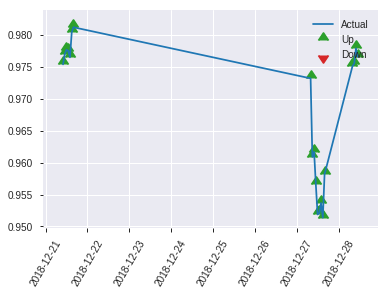


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2711820362396678
RMSE: 0.5207514150145612
LogLoss: 0.7453061521965345
Mean Per-Class Error: 0.4180124223602485
AUC: 0.5662111801242236
pr_auc: 0.5473962126743225
Gini: 0.1324223602484471
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12923084846560307: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    105  0        (0.0/105.0)
Total  0    220  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.129231     0.646154  219
max f2                       0.129231     0.820313  219
max f0point5                 0.681336     0.557987  87
max accuracy                 0.681336     0.586364  87
max precision                0.799948     1         0
max recall                   0.129231     1         219
max specificity              0.799948     1         0
max absolute_mcc             0.681336     0.167183  87
max min_per_class_accuracy   0.572002     0.552381  107
max mean_per_class_accuracy  0.681336     0.581988  87

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 54.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.791472           2.09524   2.09524            1                0.796915  1                           0.796915            0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.779732           1.04762   1.67619            0.5              0.785283  0.8                         0.792263            0.00952381      0.0380952                  4.7619    67.619
    3        0.0318182                   0.77163            1.04762   1.4966             0.5              0.773053  0.714286                    0.786774            0.00952381      0.047619                   4.7619    49.6599
    4        0.0409091                   0.76948            0         1.16402            0                0.770747  0.555556                    0.783212            0               0.047619                   -100      16.4021
    5        0.05                        0.768186           1.04762   1.14286            0.5              0.768944  0.545455                    0.780618            0.00952381      0.0571429                  4.7619    14.2857
    6        0.1                         0.76071            1.14286   1.14286            0.545455         0.764167  0.545455                    0.772393            0.0571429       0.114286                   14.2857   14.2857
    7        0.15                        0.746259           1.52381   1.26984            0.727273         0.753109  0.606061                    0.765965            0.0761905       0.190476                   52.381    26.9841
    8        0.2                         0.732054           1.14286   1.2381             0.545455         0.737761  0.590909                    0.758914            0.0571429       0.247619                   14.2857   23.8095
    9        0.3                         0.711028           1.14286   1.20635            0.545455         0.721668  0.575758                    0.746498            0.114286        0.361905                   14.2857   20.6349
    10       0.4                         0.671802           1.2381    1.21429            0.590909         0.700027  0.579545                    0.73488             0.12381         0.485714                   23.8095   21.4286
    11       0.5                         0.557689           0.666667  1.10476            0.318182         0.616429  0.527273                    0.71119             0.0666667       0.552381                   -33.3333  10.4762
    12       0.6                         0.487964           1.04762   1.09524            0.5              0.520704  0.522727                    0.679442            0.104762        0.657143                   4.7619    9.52381
    13       0.7                         0.439995           0.761905  1.04762            0.363636         0.46415   0.5                         0.648686            0.0761905       0.733333                   -23.8095  4.7619
    14       0.8                         0.363441           0.761905  1.0119             0.363636         0.403713  0.482955                    0.618065            0.0761905       0.809524                   -23.8095  1.19048
    15       0.9                         0.26461            0.857143  0.994709           0.409091         0.316212  0.474747                    0.584525            0.0857143       0.895238                   -14.2857  -0.529101
    16       1                           0.129231           1.04762   1                  0.5              0.205027  0.477273                    0.546576         

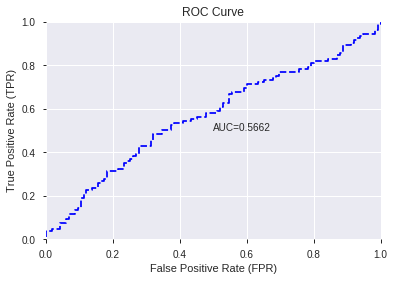

This function is available for GLM models only


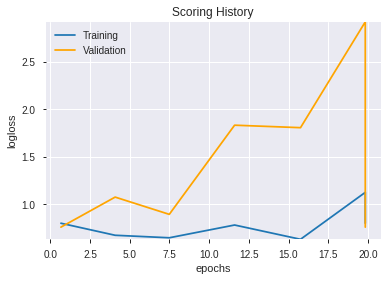

--2019-08-28 16:52:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_164503_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_164503_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHOMINGPIGEON',
 'CDLMORNINGDOJISTAR',
 'VAR_8',
 'days_in_month',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'OBV',
 'CDLMATCHINGLOW',
 'VAR_24',
 'day',
 'CDLHIKKAKEMOD',
 'BBANDS_upperband_20_3_5',
 'CDLIDENTICAL3CROWS',
 'ADX_24',
 'aroonup_20',
 'weekofyear',
 'AROONOSC_8',
 'CDLADVANCEBLOCK',
 'CORREL_30',
 'SAREXT',
 'CDLGAPSIDESIDEWHITE',
 'ROC_20',
 'KAMA_24',
 'dayofweek',
 'FLOOR',
 'DX_14',
 'DX_24',
 'CDLGRAVESTONEDOJI',
 'BBANDS_upperband_24_3_2',
 'DX_8',
 'STOCHF_fastk',
 'CORREL_8',
 'PLUS_DM_8',
 'PLUS_DI_20',
 'BBANDS_lowerband_8_3_4',
 'DX_12',
 'RSI_12',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'aroonup_30',
 'CDLEVENINGSTAR',
 'BETA_8',
 'BBANDS_middleband_14_4_5',
 'DIV',
 'CCI_30',
 'CDLTASUKIGAP',
 'BBANDS_lowerband_12_2_3',
 'CORREL_12',
 'HT_TRENDMODE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse     mse
0  GLM_grid_1_AutoML_20190828_165224_model_1  0.553126  0.699744              0.495652  0.503289  0.2533

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD             0.008115           1.000000    0.048493
1                     ADX_24             0.007684           0.946908    0.045918
2                        OBV             0.007679           0.946362    0.045892
3                   CORREL_8             0.006580           0.810894    0.039322
4                    KAMA_24             0.006323           0.779213    0.037786
5             STOCHRSI_fastd             0.006305           0.777020    0.037680
6                  CORREL_12             0.006096           0.751267    0.036431
7    BBANDS_upperband_20_3_5             0.006033           0.743451    0.036052
8                  dayofweek             0.005807           0.715613    0.034702
9    BBANDS_upperband_24_3_2             0.005737           0.707056    0.034287
10  BBANDS_middleband_14_4_5             0.005733           0.706575    0.034264
11              CDLTASUKIGAP             0.005384           0.663475    0.032174
12       CDLGAPSIDESIDEWHITE             0.005322           0.655806    0.031802
13             days_in_month             0.005297           0.652752    0.031654
14    BBANDS_lowerband_8_3_4             0.004981           0.613794    0.029764
15   BBANDS_lowerband_12_2_3             0.004610           0.568119    0.027550
16                    BETA_8             0.004451           0.548470    0.026597
17                    VAR_24             0.004168           0.513599    0.024906
18        CDLMORNINGDOJISTAR             0.003884           0.478656    0.023211
19           CDLLADDERBOTTOM             0.003818           0.470558    0.022819
20              HT_TRENDMODE             0.003803           0.468702    0.022729
21                aroonup_30             0.003690           0.454691    0.022049
22                     FLOOR             0.003686           0.454198    0.022025
23                     VAR_8             0.003656           0.450586    0.021850
24              STOCHF_fastk             0.003250           0.400459    0.019419
25                PLUS_DI_20             0.003231           0.398232    0.019311
26                AROONOSC_8             0.003178           0.391629    0.018991
27                aroonup_20             0.002909           0.358439    0.017382
28                     DX_12             0.002598           0.320137    0.015524
29                     DX_14             0.002400           0.295771    0.014343
30                 PLUS_DM_8             0.002202           0.271370    0.013159
31           CDLHOMINGPIGEON             0.002145           0.264363    0.012820
32                    SAREXT             0.002114           0.260502    0.012632
33                 CORREL_30             0.001794           0.221102    0.010722
34              CDLTHRUSTING             0.001749           0.215589    0.010454
35             CDLHIKKAKEMOD             0.001709           0.210585    0.010212
36            CDLEVENINGSTAR             0.001515           0.186690    0.009053
37                    CCI_30             0.001472           0.181377    0.008795
38         CDLGRAVESTONEDOJI             0.001253           0.154358    0.007485
39                      DX_8             0.001239           0.152723    0.007406
40                    RSI_12             0.001014           0.124911    0.006057
41                weekofyear             0.000912           0.112421    0.005452
42                    ROC_20             0.000425           0.052375    0.002540
43                       DIV             0.000335           0.041261    0.002001
44                       day             0.000263           0.032426    0.001572
45           CDLADVANCEBLOCK             0.000235           0.029021    0.001407
46                     DX_24             0.000225           0.027729    0.001345
47            CDLMATCHINGLOW             0.000179           0.022020    0.001068
48        CDLIDENTICAL3CROWS             0.000119  

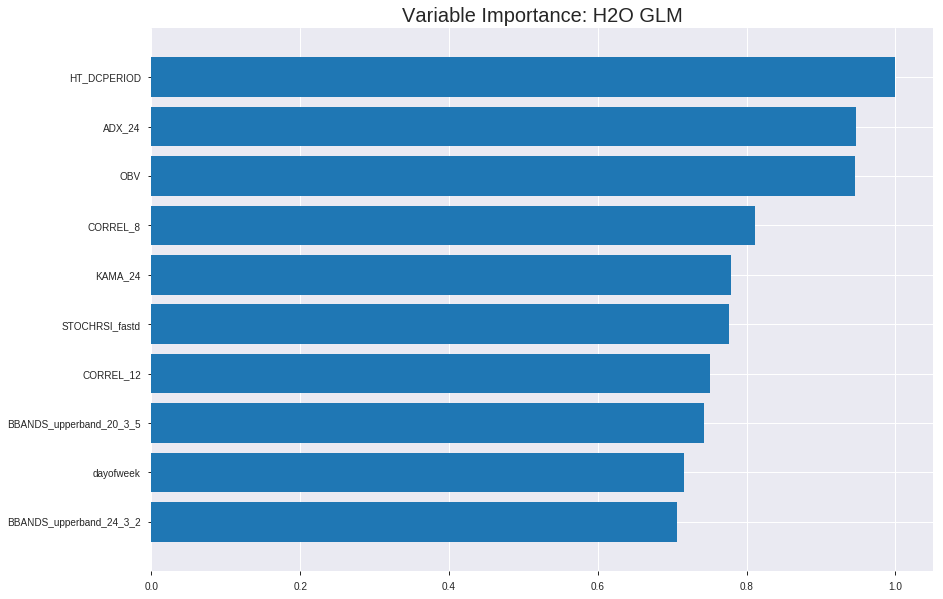

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_165224_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24858131481413376
RMSE: 0.4985792964154586
LogLoss: 0.6903066107224639
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.327778804599
Residual deviance: 2122.0025213608546
AIC: 2224.0025213608546
AUC: 0.5721915669098767
pr_auc: 0.5788205413539089
Gini: 0.14438313381975343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48307176588476564: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    750   0.9921   (750.0/756.0)
1      0    781   0        (0.0/781.0)
Total  6    1531  0.488    (750.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483072     0.675606  394
max f2                       0.483072     0.838883  394
max f0point5                 0.504304     0.582504  236
max accuracy                 0.504304     0.566688  236
max precision                0.56676      1         0
max recall                   0.483072     1         394
max specificity              0.56676      1         0
max absolute_mcc             0.504304     0.134249  236
max min_per_class_accuracy   0.508569     0.555556  193
max mean_per_class_accuracy  0.504304     0.564414  236

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.528267           1.59899   1.59899            0.8125           0.54048   0.8125                      0.54048             0.0166453       0.0166453                  59.8992   59.8992
    2        0.0201692                   0.527383           1.31199   1.46012            0.666667         0.527849  0.741935                    0.534368            0.0128041       0.0294494                  31.1993   46.0121
    3        0.0305791                   0.526395           1.47599   1.46552            0.75             0.526915  0.744681                    0.531831            0.0153649       0.0448143                  47.5992   46.5524
    4        0.0403383                   0.525682           0.918395  1.33315            0.466667         0.525922  0.677419                    0.530402            0.00896287      0.0537772                  -8.16048  33.3154
    5        0.0500976                   0.52509            1.18079   1.30347            0.6              0.525437  0.662338                    0.529434            0.0115237       0.0653009                  18.0794   30.3474
    6        0.100195                    0.521836           1.15012   1.2268             0.584416         0.523227  0.623377                    0.526331            0.0576184       0.122919                   15.0124   22.6799
    7        0.150293                    0.519896           1.15012   1.20124            0.584416         0.520787  0.61039                     0.524483            0.0576184       0.180538                   15.0124   20.1241
    8        0.20039                     0.518081           1.17568   1.19485            0.597403         0.518973  0.607143                    0.523105            0.0588988       0.239437                   17.5682   19.4851
    9        0.299935                    0.514805           0.926113  1.10566            0.470588         0.51636   0.561822                    0.520867            0.0921895       0.331626                   -7.38872  10.566
    10       0.40013                     0.511763           1.08623   1.10079            0.551948         0.513283  0.55935                     0.518968            0.108835        0.440461                   8.62281   10.0794
    11       0.500325                    0.508551           1.1629    1.11323            0.590909         0.510205  0.56567                     0.517213            0.116517        0.556978                   16.2903   11.3232
    12       0.59987                     0.505285           1.01615   1.09712            0.51634          0.506911  0.557484                    0.515503            0.101152        0.658131                   1.61516   9.71223
    13       0.700065                    0.502735           0.971216  1.0791             0.493506         0.504039  0.548327                    0.513862            0.0973111       0.755442                   -2.87843  7.91022
    14       0.79961                     0.498701           0.733173  1.03604            0.372549         0.500979  0.526444                    0.512259            0.0729834       0.828425                   -26.6827  3.60369
    15       0.899805                    0.491886           0.843424  1.01459            0.428571         0.495619  0.515546                    0.510406            0.084507        0.912932                   -15.6576  1.45891
    16       1                           0.477117           0.868982  1                  0.441558         0.48772   0.508133                    0.508133          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2514335033773135
RMSE: 0.5014314543158551
LogLoss: 0.6960128125801053
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 609.0572554147116
Residual deviance: 611.0992494453325
AIC: 713.0992494453325
AUC: 0.5092834890965732
pr_auc: 0.5197315212147015
Gini: 0.018566978193146344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023201176251363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    214  0        (0.0/214.0)
Total  1    438  0.5103   (224.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50232      0.656442  398
max f2                       0.50232      0.826893  398
max f0point5                 0.50232      0.544252  398
max accuracy                 0.539907     0.548975  77
max precision                0.58429      1         0
max recall                   0.50232      1         398
max specificity              0.58429      1         0
max absolute_mcc             0.539907     0.106274  77
max min_per_class_accuracy   0.531455     0.490654  198
max mean_per_class_accuracy  0.539907     0.541038  77

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.578571           1.64112   1.64112            0.8              0.581137  0.8                         0.581137            0.0186916       0.0186916                  64.1121   64.1121
    2        0.0205011                   0.576827           0.51285   1.13967            0.25             0.577629  0.555556                    0.579578            0.0046729       0.0233645                  -48.715   13.9668
    3        0.0318907                   0.575383           1.23084   1.17223            0.6              0.576213  0.571429                    0.578376            0.0140187       0.0373832                  23.0841   17.223
    4        0.0410023                   0.57409            2.0514    1.3676             1                0.574732  0.666667                    0.577566            0.0186916       0.0560748                  105.14    36.7601
    5        0.0501139                   0.573498           1.0257    1.30544            0.5              0.573845  0.636364                    0.57689             0.00934579      0.0654206                  2.57009   30.5438
    6        0.100228                    0.543876           1.11895   1.21219            0.545455         0.564735  0.590909                    0.570812            0.0560748       0.121495                   11.8946   21.2192
    7        0.150342                    0.540862           1.11895   1.18111            0.545455         0.54234   0.575758                    0.561322            0.0560748       0.17757                    11.8946   18.111
    8        0.200456                    0.539508           1.0257    1.14226            0.5              0.540169  0.556818                    0.556033            0.0514019       0.228972                   2.57009   14.2258
    9        0.300683                    0.536417           0.979078  1.08786            0.477273         0.537902  0.530303                    0.549989            0.0981308       0.327103                   -2.09218  8.78646
    10       0.400911                    0.534012           0.979078  1.06067            0.477273         0.535103  0.517045                    0.546268            0.0981308       0.425234                   -2.09218  6.0668
    11       0.501139                    0.531332           0.652719  0.979078           0.318182         0.532552  0.477273                    0.543525            0.0654206       0.490654                   -34.7281  -2.09218
    12       0.599089                    0.526315           1.04955   0.990601           0.511628         0.528901  0.48289                     0.541134            0.102804        0.593458                   4.95544   -0.93991
    13       0.699317                    0.522468           0.885833  0.975585           0.431818         0.524076  0.47557                     0.538689            0.088785        0.682243                   -11.4167  -2.44147
    14       0.799544                    0.518396           1.07232   0.987712           0.522727         0.520836  0.481481                    0.536451            0.107477        0.78972                    7.23237   -1.2288
    15       0.899772                    0.514207           1.0257    0.991944           0.5              0.516434  0.483544                    0.534221            0.102804        0.892523                   2.57009   -0.805631
    16       1                           0.501628           1.07232   1                  0.522727         0.509415  0.487472                    0.531735       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:52:25  0.000 sec   2            3         51            1.38061           1.39203
    2019-08-28 16:52:25  0.086 sec   4            1.9       51            1.37836           1.39553
    2019-08-28 16:52:25  0.169 sec   6            1.2       51            1.37555           1.40106
    2019-08-28 16:52:25  0.232 sec   8            0.72      51            1.37224           1.40927
    2019-08-28 16:52:25  0.301 sec   10           0.45      51            1.36858           1.42068

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5954545454545455)

('F1', 0.6481481481481481)

('auc', 0.5531262939958592)

('logloss', 0.6997437411985322)

('mean_per_class_error', 0.40973084886128364)

('rmse', 0.5032887218206396)

('mse', 0.25329953751185313)

glm prediction progress: |████████████████████████████████████████████████| 100%


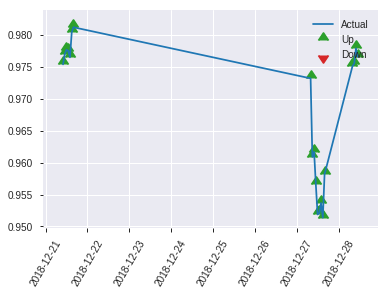


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25329953751185313
RMSE: 0.5032887218206396
LogLoss: 0.6997437411985322
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.36830916935537
Residual deviance: 307.88724612735416
AIC: 409.88724612735416
AUC: 0.5531262939958592
pr_auc: 0.5487625789388048
Gini: 0.10625258799171844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5297603500512651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    114  0.9913   (114.0/115.0)
1      0    105  0        (0.0/105.0)
Total  1    219  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52976      0.648148  218
max f2                       0.52976      0.821596  218
max f0point5                 0.569978     0.566893  83
max accuracy                 0.571124     0.595455  81
max precision                0.621167     1         0
max recall                   0.52976      1         218
max specificity              0.621167     1         0
max absolute_mcc             0.585327     0.18972   6
max min_per_class_accuracy   0.545332     0.556522  109
max mean_per_class_accuracy  0.569978     0.590269  83

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 55.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.605993           2.09524   2.09524            1                0.614294  1                           0.614294            0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.585619           2.09524   2.09524            1                0.586429  1                           0.603148            0.0190476       0.047619                   109.524   109.524
    3        0.0318182                   0.585272           2.09524   2.09524            1                0.585363  1                           0.598067            0.0190476       0.0666667                  109.524   109.524
    4        0.0409091                   0.584481           0         1.62963            0                0.585047  0.777778                    0.595173            0               0.0666667                  -100      62.963
    5        0.05                        0.583394           0         1.33333            0                0.583927  0.636364                    0.593129            0               0.0666667                  -100      33.3333
    6        0.1                         0.581419           1.14286   1.2381             0.545455         0.58238   0.590909                    0.587754            0.0571429       0.12381                    14.2857   23.8095
    7        0.15                        0.579134           0.761905  1.07937            0.363636         0.580427  0.515152                    0.585312            0.0380952       0.161905                   -23.8095  7.93651
    8        0.2                         0.577159           1.33333   1.14286            0.636364         0.578105  0.545455                    0.58351             0.0666667       0.228571                   33.3333   14.2857
    9        0.3                         0.573179           1.33333   1.20635            0.636364         0.574812  0.575758                    0.580611            0.133333        0.361905                   33.3333   20.6349
    10       0.4                         0.569217           1.14286   1.19048            0.545455         0.571563  0.568182                    0.578349            0.114286        0.47619                    14.2857   19.0476
    11       0.5                         0.545296           0.857143  1.12381            0.409091         0.556932  0.536364                    0.574065            0.0857143       0.561905                   -14.2857  12.381
    12       0.6                         0.541512           0.761905  1.06349            0.363636         0.543243  0.507576                    0.568928            0.0761905       0.638095                   -23.8095  6.34921
    13       0.7                         0.5385             0.571429  0.993197           0.272727         0.54012   0.474026                    0.564813            0.0571429       0.695238                   -42.8571  -0.680272
    14       0.8                         0.535063           1.04762   1                  0.5              0.536588  0.477273                    0.561285            0.104762        0.8                        4.7619    0
    15       0.9                         0.532777           0.952381  0.994709           0.454545         0.533817  0.474747                    0.558233            0.0952381       0.895238                   -4.7619   -0.529101
    16       1                           0.5297             1.04762   1                  0.5              0.531366  0.477273                    0.555546            0

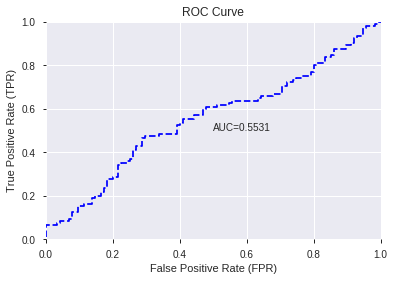

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


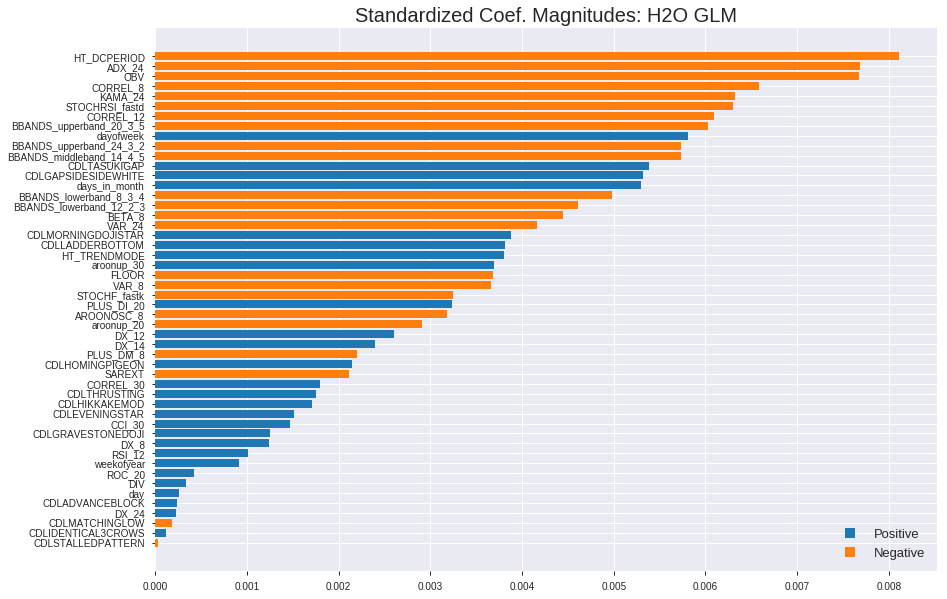

'log_likelihood'
--2019-08-28 16:52:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_165224_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_165224_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['HT_DCPERIOD',
 'ADX_24',
 'OBV',
 'CORREL_8',
 'KAMA_24',
 'STOCHRSI_fastd',
 'CORREL_12',
 'BBANDS_upperband_20_3_5',
 'dayofweek',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_14_4_5',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_lowerband_12_2_3',
 'BETA_8',
 'VAR_24',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'HT_TRENDMODE',
 'aroonup_30',
 'FLOOR',
 'VAR_8',
 'STOCHF_fastk',
 'PLUS_DI_20',
 'AROONOSC_8',
 'aroonup_20',
 'DX_12',
 'DX_14',
 'PLUS_DM_8',
 'CDLHOMINGPIGEON',
 'SAREXT',
 'CORREL_30',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDLEVENINGSTAR',
 'CCI_30',
 'CDLGRAVESTONEDOJI',
 'DX_8',
 'RSI_12',
 'weekofyear',
 'ROC_20',
 'DIV',
 'day',
 'CDLADVANCEBLOCK',
 'DX_24',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN']

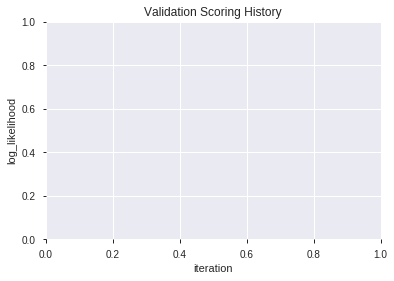

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_165242_model_5  0.575155  0.780178              0.435404  0.535384  0.286636
1  XGBoost_grid_1_AutoML_20190828_165242_model_3  0.531346  0.746488              0.474741  0.524047  0.274625
2  XGBoost_grid_1_AutoML_20190828_165242_model_6  0.518427  0.730826              0.500000  0.517601  0.267911
3  XGBoost_grid_1_AutoML_20190828_165242_model_1  0.514907  0.743289              0.435818  0.522544  0.273052
4               XGBoost_3_AutoML_20190828_165242  0.508075  0.731195              0.491304  0.517721  0.268035
5               XGBoost_2_AutoML_20190828_165242  0.496066  0.743468              0.500000  0.523401  0.273948
6  XGBoost_grid_1_AutoML_20190828_165242_model_7  0.493333  0.751076              0.465631  0.525843  0.276511
7               XGBoost_1_AutoML_20190828_165242  0.478509  0.735465              0.479089  0.519637  0.270023
8  XGBoost_grid_1_AutoML_20190828_165242_model_4  0.459130  0.727398              0.500000  0.516474  0.266746
9  XGBoost_grid_1_AutoML_20190828_165242_model_2  0.451511  0.720129              0.469565  0.512964  0.263132

variable  relative_importance  scaled_importance  percentage
0                        DIV          1106.095947           1.000000    0.051817
1               STOCHF_fastk          1024.249268           0.926004    0.047983
2                      VAR_8           986.847046           0.892189    0.046230
3                       DX_8           977.617004           0.883845    0.045798
4             STOCHRSI_fastd           820.598511           0.741887    0.038442
5                        OBV           781.445190           0.706490    0.036608
6     BBANDS_lowerband_8_3_4           770.512146           0.696605    0.036096
7                     VAR_24           770.364014           0.696471    0.036089
8                     ADX_24           754.398376           0.682037    0.035341
9                  PLUS_DM_8           740.043579           0.669059    0.034668
10                    SAREXT           737.885620           0.667108    0.034567
11                    ROC_20           733.305054           0.662967    0.034353
12                 CORREL_30           686.291321           0.620463    0.032150
13                    BETA_8           670.870789           0.606521    0.031428
14                    CCI_30           622.851868           0.563108    0.029178
15                    RSI_12           604.000854           0.546066    0.028295
16                     DX_12           598.910156           0.541463    0.028057
17               HT_DCPERIOD           594.248596           0.537249    0.027838
18                     DX_24           579.384033           0.523810    0.027142
19                       day           556.598450           0.503210    0.026075
20   BBANDS_upperband_20_3_5           555.328979           0.502062    0.026015
21                PLUS_DI_20           498.910919           0.451056    0.023372
22                 CORREL_12           472.337219           0.427031    0.022127
23                AROONOSC_8           452.515808           0.409111    0.021199
24                     DX_14           452.367218           0.408976    0.021192
25   BBANDS_lowerband_12_2_3           452.260345           0.408880    0.021187
26                aroonup_20           448.823090           0.405772    0.021026
27                  CORREL_8           443.640717           0.401087    0.020783
28  BBANDS_middleband_14_4_5           441.089203           0.398780    0.020664
29                   KAMA_24           427.535706           0.386527    0.020029
30                aroonup_30           385.416046           0.348447    0.018055
31   BBANDS_upperband_24_3_2           365.141357           0.330117    0.017106
32                weekofyear           349.975403           0.316406    0.016395
33                 dayofweek           282.895935           0.255761    0.013253
34             days_in_month           108.602402           0.098185    0.005088
35              HT_TRENDMODE            32.487972           0.029372    0.001522
36         CDLGRAVESTONEDOJI            20.113373           0.018184    0.000942
37           CDLADVANCEBLOCK            19.741795           0.017848    0.000925
38            CDLMATCHINGLOW             9.128265           0.008253    0.000428
39           CDLHOMINGPIGEON             5.637185           0.005096    0.000264
40              CDLTHRUSTING             2.086123           0.001886    0.000098
41       CDLGAPSIDESIDEWHITE             1.990879           0.001800    0.000093
42            CDLEVENINGSTAR             1.749516           0.001582    0.000082

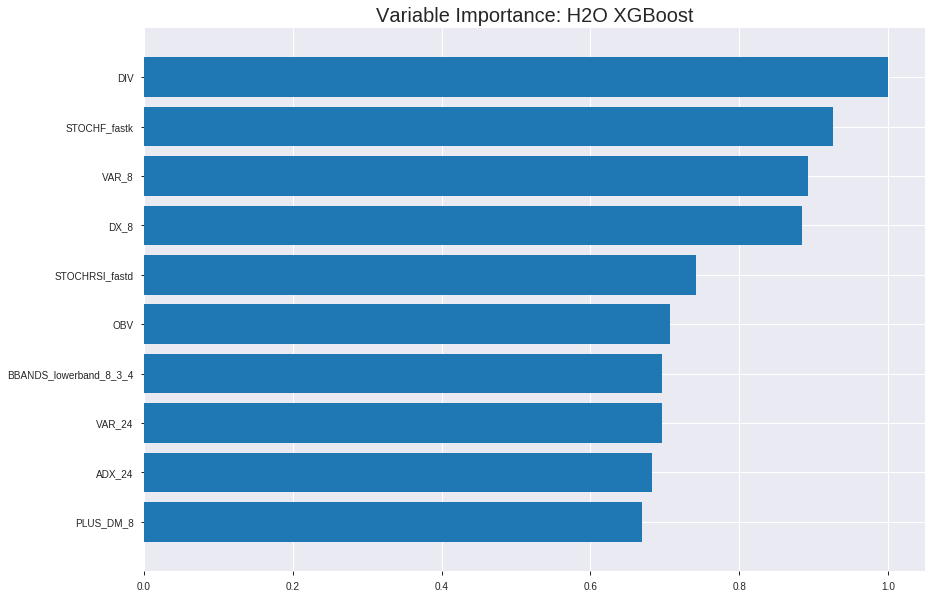

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_165242_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04994513476594575
RMSE: 0.22348408168356365
LogLoss: 0.24350762952680172
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987195902688861
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5226385593414307: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      756  0    0        (0.0/756.0)
1      0    781  0        (0.0/781.0)
Total  756  781  0        (0.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.522639     1        204
max f2                       0.522639     1        204
max f0point5                 0.522639     1        204
max accuracy                 0.522639     1        204
max precision                0.937995     1        0
max recall                   0.522639     1        204
max specificity              0.937995     1        0
max absolute_mcc             0.522639     1        204
max min_per_class_accuracy   0.522639     1        204
max mean_per_class_accuracy  0.522639     1        204

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.897726           1.96799   1.96799            1                0.912779  1                           0.912779            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.888593           1.96799   1.96799            1                0.892033  1                           0.902741            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.883063           1.96799   1.96799            1                0.885198  1                           0.896769            0.0204866       0.0601793                  96.799    96.799
    4        0.0403383                   0.875726           1.96799   1.96799            1                0.87868   1                           0.892392            0.0192061       0.0793854                  96.799    96.799
    5        0.0500976                   0.871815           1.96799   1.96799            1                0.873476  1                           0.888707            0.0192061       0.0985915                  96.799    96.799
    6        0.100195                    0.848722           1.96799   1.96799            1                0.859476  1                           0.874092            0.0985915       0.197183                   96.799    96.799
    7        0.150293                    0.832896           1.96799   1.96799            1                0.841166  1                           0.863117            0.0985915       0.295775                   96.799    96.799
    8        0.20039                     0.815326           1.96799   1.96799            1                0.82414   1                           0.853373            0.0985915       0.394366                   96.799    96.799
    9        0.299935                    0.783487           1.96799   1.96799            1                0.798326  1                           0.835103            0.195903        0.590269                   96.799    96.799
    10       0.40013                     0.734154           1.96799   1.96799            1                0.760598  1                           0.816447            0.197183        0.787452                   96.799    96.799
    11       0.500325                    0.621833           1.96799   1.96799            1                0.692081  1                           0.791541            0.197183        0.984635                   96.799    96.799
    12       0.59987                     0.270928           0.154352  1.66703            0.0784314        0.339323  0.847072                    0.716499            0.0153649       1                          -84.5648  66.7028
    13       0.700065                    0.228072           0         1.42844            0                0.24857   0.725836                    0.649527            0               1                          -100      42.8439
    14       0.79961                     0.19035            0         1.25061            0                0.208904  0.635476                    0.594674            0               1                          -100      25.061
    15       0.899805                    0.156252           0         1.11135            0                0.174205  0.564714                    0.547853            0               1                          -100      11.1352
    16       1                           0.0860344          0         1                  0                0.134041  0.508133                    0.506391            0        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27474783158040106
RMSE: 0.5241639357876513
LogLoss: 0.7501638287129693
Mean Per-Class Error: 0.4684631360332294
AUC: 0.5127310488058151
pr_auc: 0.4876573983348683
Gini: 0.025462097611630208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2781803011894226: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    221  0.9822   (221.0/225.0)
1      0    214  0        (0.0/214.0)
Total  4    435  0.5034   (221.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.27818      0.659476   395
max f2                       0.27818      0.828815   395
max f0point5                 0.27818      0.547595   395
max accuracy                 0.622841     0.53303    158
max precision                0.811591     0.571429   11
max recall                   0.27818      1          395
max specificity              0.841703     0.995556   0
max absolute_mcc             0.27818      0.0935192  395
max min_per_class_accuracy   0.595851     0.514019   192
max mean_per_class_accuracy  0.610134     0.531537   172

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 58.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.823421           0.41028   0.41028            0.2              0.833672  0.2                         0.833672            0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   0.813549           1.53855   0.911734           0.75             0.819105  0.444444                    0.827198            0.0140187       0.0186916                  53.8551   -8.82658
    3        0.0318907                   0.811457           1.64112   1.17223            0.8              0.81269   0.571429                    0.822016            0.0186916       0.0373832                  64.1121   17.223
    4        0.0410023                   0.800519           0         0.911734           0                0.805182  0.444444                    0.818275            0               0.0373832                  -100      -8.82658
    5        0.0501139                   0.792469           1.53855   1.0257             0.75             0.79869   0.5                         0.814714            0.0140187       0.0514019                  53.8551   2.57009
    6        0.100228                    0.762331           0.745964  0.885833           0.363636         0.775329  0.431818                    0.795022            0.0373832       0.088785                   -25.4036  -11.4167
    7        0.150342                    0.73752            1.11895   0.963537           0.545455         0.749526  0.469697                    0.779856            0.0560748       0.14486                    11.8946   -3.64628
    8        0.200456                    0.712553           0.932455  0.955767           0.454545         0.725692  0.465909                    0.766315            0.046729        0.191589                   -6.75446  -4.42332
    9        0.300683                    0.668268           1.07232   0.994619           0.522727         0.689954  0.484848                    0.740862            0.107477        0.299065                   7.23237   -0.538091
    10       0.400911                    0.623403           1.25881   1.06067            0.613636         0.64777   0.517045                    0.717589            0.126168        0.425234                   25.8815   6.0668
    11       0.501139                    0.5947             0.885833  1.0257             0.431818         0.607228  0.5                         0.695517            0.088785        0.514019                   -11.4167  2.57009
    12       0.599089                    0.55851            1.04955   1.0296             0.511628         0.577141  0.501901                    0.676163            0.102804        0.616822                   4.95544   2.96009
    13       0.699317                    0.519059           0.932455  1.01568            0.454545         0.537113  0.495114                    0.656234            0.0934579       0.71028                    -6.75446  1.56778
    14       0.799544                    0.463305           0.885833  0.999401           0.431818         0.4907    0.487179                    0.635483            0.088785        0.799065                   -11.4167  -0.0599089
    15       0.899772                    0.400817           0.979078  0.997137           0.477273         0.436194  0.486076                    0.613284            0.0981308       0.897196                   -2.09218  -0.286289
    16       1                           0.2661             1.0257    1                  0.5              0.354333  0.487472                    0.58733


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:52:50  3.817 sec   0                  0.5              0.693147            0.5             0                  1                0.491867                         0.5                0.693147              0.5               0                    1                  0.512528
    2019-08-28 16:52:50  4.153 sec   5                  0.451395         0.599948            0.963879        0.964035           1.96799          0.0995446                        0.504261           0.701791              0.481942          0.473729             0.820561           0.505695
    2019-08-28 16:52:51  4.453 sec   10                 0.410054         0.52625             0.991635        0.989755           1.96799          0.0409889                        0.508051           0.709668              0.473188          0.472838             0.41028            0.507973
    2019-08-28 16:52:51  4.757 sec   15                 0.374345         0.466179            0.998014        0.994228           1.96799          0.0195185                        0.510373           0.714894              0.484258          0.471174             1.23084            0.510251
    2019-08-28 16:52:51  5.042 sec   20                 0.345681         0.419954            0.999471        0.998209           1.96799          0.0117111                        0.511219           0.717083              0.502606          0.482796             0.820561           0.510251
    2019-08-28 16:52:52  5.352 sec   25                 0.320291         0.38086             0.999847        0.997291           1.96799          0.00455433                       0.514599           0.725341              0.502357          0.471539             0.820561           0.507973
    2019-08-28 16:52:52  5.670 sec   30                 0.298214         0.347653            0.99993         0.998652           1.96799          0.00325309                       0.516589           0.730574              0.508048          0.480117             0.820561           0.507973
    2019-08-28 16:52:52  5.997 sec   35                 0.277925         0.318199            0.999974        0.998694           1.96799          0.00195185                       0.517698           0.734195              0.514102          0.479574             0.820561           0.510251
    2019-08-28 16:52:53  6.347 sec   40                 0.259776         0.292591            0.999988        0.998708           1.96799          0.00130124                       0.520614           0.740426              0.505036          0.481821             1.23084            0.503417
    2019-08-28 16:52:53  6.709 sec   45                 0.240189         0.265483            1               0.99872            1.96799          0                                0.521642           0.74317               0.511038          0.487365             0.820561           0.505695
    2019-08-28 16:52:53  7.083 sec   50                 0.223484         0.243508            1               0.99872            1.96799          0                                0.524164           0.750164              0.512731          0.487657             0.41028            0.503417

Variable Importances: 


variable             relative_importance    scaled_importance      percentage
-------------------  ---------------------  ---------------------  ----------------------
DIV                  1106.095947265625      1.0                    0.05181676897711087
STOCHF_fastk         1024.249267578125      0.9260039964075153     0.047982535153729626
VAR_8                986.8470458984375      0.8921893695913251     0.04623037044794788
DX_8                 977.6170043945312      0.883844667193017      0.04579797493159201
STOCHRSI_fastd       820.5985107421875      0.7418872772934261     0.03844220165457125
---                  ---                    ---                    ---
CDLMATCHINGLOW       9.128265380859375      0.008252688569581437   0.0004276276570500449
CDLHOMINGPIGEON      5.637185096740723      0.005096470257102364   0.00026408262191099006
CDLTHRUSTING         2.086122512817383      0.0018860231049345015  9.77276235138844e-05
CDLGAPSIDESIDEWHITE  1.9908790588378906     0.0017999153362414301  9.326579715638102e-05
CDLEVENINGSTAR       1.7495160102844238     0.001581703661973805   8.195877324274692e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6526315789473685)

('auc', 0.5751552795031055)

('logloss', 0.7801777963687868)

('mean_per_class_error', 0.4227743271221531)

('rmse', 0.5353838631146597)

('mse', 0.28663588088357667)

xgboost prediction progress: |████████████████████████████████████████████| 100%


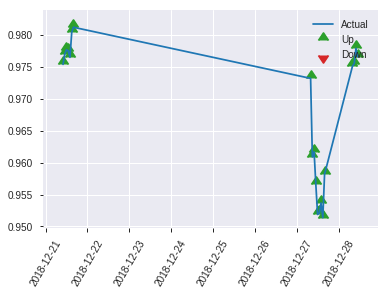


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28663588088357667
RMSE: 0.5353838631146597
LogLoss: 0.7801777963687868
Mean Per-Class Error: 0.4227743271221531
AUC: 0.5751552795031055
pr_auc: 0.5140010651572136
Gini: 0.15031055900621104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5864582061767578: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      28   87   0.7565   (87.0/115.0)
1      12   93   0.1143   (12.0/105.0)
Total  40   180  0.45     (99.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.586458     0.652632  179
max f2                       0.383124     0.822884  217
max f0point5                 0.614547     0.564409  161
max accuracy                 0.660458     0.572727  130
max precision                0.779928     0.615385  38
max recall                   0.383124     1         217
max specificity              0.868556     0.991304  0
max absolute_mcc             0.586458     0.167307  179
max min_per_class_accuracy   0.699694     0.547826  109
max mean_per_class_accuracy  0.660458     0.577226  130

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 67.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.844894           0.698413  0.698413           0.333333         0.855043  0.333333                    0.855043            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.829491           1.04762   0.838095           0.5              0.831676  0.4                         0.845696            0.00952381      0.0190476                  4.7619    -16.1905
    3        0.0318182                   0.824106           1.04762   0.897959           0.5              0.826161  0.428571                    0.840115            0.00952381      0.0285714                  4.7619    -10.2041
    4        0.0409091                   0.820042           0         0.698413           0                0.82241   0.333333                    0.83618             0               0.0285714                  -100      -30.1587
    5        0.05                        0.81933            1.04762   0.761905           0.5              0.819593  0.363636                    0.833165            0.00952381      0.0380952                  4.7619    -23.8095
    6        0.1                         0.802855           1.33333   1.04762            0.636364         0.811936  0.5                         0.82255             0.0666667       0.104762                   33.3333   4.7619
    7        0.15                        0.78814            1.33333   1.14286            0.636364         0.798552  0.545455                    0.814551            0.0666667       0.171429                   33.3333   14.2857
    8        0.2                         0.772268           1.33333   1.19048            0.636364         0.780808  0.568182                    0.806115            0.0666667       0.238095                   33.3333   19.0476
    9        0.3                         0.753166           0.857143  1.07937            0.409091         0.760344  0.515152                    0.790858            0.0857143       0.32381                    -14.2857  7.93651
    10       0.4                         0.725171           1.14286   1.09524            0.545455         0.740267  0.522727                    0.77821             0.114286        0.438095                   14.2857   9.52381
    11       0.5                         0.698076           1.14286   1.10476            0.545455         0.711852  0.527273                    0.764939            0.114286        0.552381                   14.2857   10.4762
    12       0.6                         0.659048           1.2381    1.12698            0.590909         0.679666  0.537879                    0.750727            0.12381         0.67619                    23.8095   12.6984
    13       0.7                         0.621418           0.952381  1.10204            0.454545         0.64309   0.525974                    0.73535             0.0952381       0.771429                   -4.7619   10.2041
    14       0.8                         0.592942           0.857143  1.07143            0.409091         0.608722  0.511364                    0.719521            0.0857143       0.857143                   -14.2857  7.14286
    15       0.9                         0.523268           0.761905  1.03704            0.363636         0.562085  0.494949                    0.702028            0.0761905       0.933333                   -23.8095  3.7037
    16       1                           0.352073           0.666667  1                  0.318182         0.449557  0.477273                    0.676781      

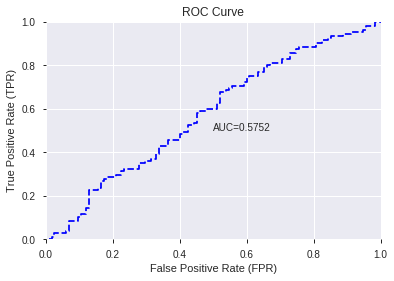

This function is available for GLM models only


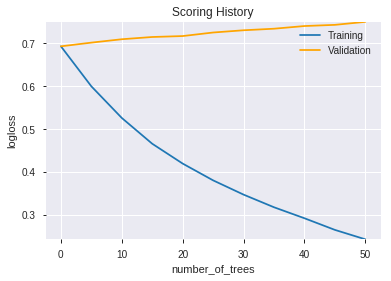

--2019-08-28 16:53:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.92
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.92|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_165242_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_165242_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'STOCHF_fastk',
 'VAR_8',
 'DX_8',
 'STOCHRSI_fastd',
 'OBV',
 'BBANDS_lowerband_8_3_4',
 'VAR_24',
 'ADX_24',
 'PLUS_DM_8',
 'SAREXT',
 'ROC_20',
 'CORREL_30',
 'BETA_8',
 'CCI_30',
 'RSI_12',
 'DX_12',
 'HT_DCPERIOD',
 'DX_24',
 'day',
 'BBANDS_upperband_20_3_5',
 'PLUS_DI_20',
 'CORREL_12',
 'AROONOSC_8',
 'DX_14',
 'BBANDS_lowerband_12_2_3',
 'aroonup_20',
 'CORREL_8',
 'BBANDS_middleband_14_4_5',
 'KAMA_24',
 'aroonup_30',
 'BBANDS_upperband_24_3_2',
 'weekofyear',
 'dayofweek',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGSTAR']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_165314_model_1  0.561573  0.721995              0.491304  0.513928  0.264122

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         7.266197e-03           1.000000  1.086430e-02
1               is_month_start         6.033485e-03           0.830350  9.021169e-03
2                  CDLLONGLINE         5.651484e-03           0.777777  8.450008e-03
3                    dayofweek         5.490701e-03           0.755650  8.209606e-03
4                      weekday         5.476715e-03           0.753725  8.188696e-03
...                        ...                  ...                ...           ...
1028    LINEARREG_INTERCEPT_20         1.289233e-06           0.000177  1.927640e-06
1029  BBANDS_middleband_20_0_2         1.148936e-06           0.000158  1.717871e-06
1030                    T3_8_4         1.043300e-06           0.000144  1.559925e-06
1031  BBANDS_middleband_30_0_3         1.979572e-07           0.000027  2.959824e-07
1032   BBANDS_upperband_20_5_2         3.105730e-08           0.000004  4.643637e-08

[1033 rows x 4 columns]

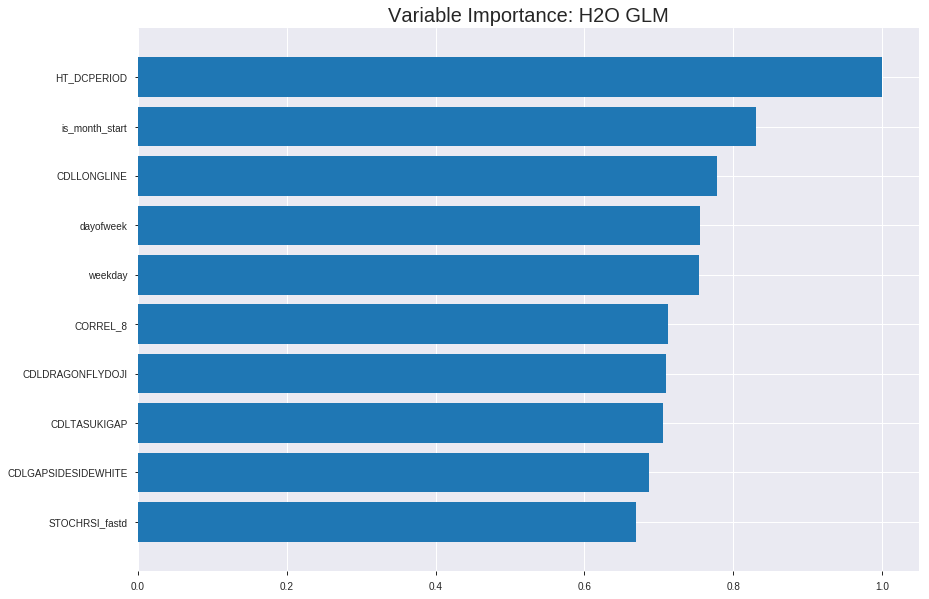

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_165314_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24659203645433997
RMSE: 0.49658034239621285
LogLoss: 0.6863027951515056
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2130.327778804599
Residual deviance: 2109.694792295728
AIC: 4177.694792295728
AUC: 0.57236516743559
pr_auc: 0.5724971900095452
Gini: 0.14473033487117992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4459042188397723: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   708   0.9365   (708.0/756.0)
1      21   760   0.0269   (21.0/781.0)
Total  69   1468  0.4743   (729.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445904     0.675856  368
max f2                       0.420483     0.838343  396
max f0point5                 0.491629     0.582872  247
max accuracy                 0.491629     0.565387  247
max precision                0.639993     1         0
max recall                   0.420483     1         396
max specificity              0.639993     1         0
max absolute_mcc             0.491629     0.132988  247
max min_per_class_accuracy   0.510357     0.553137  191
max mean_per_class_accuracy  0.506595     0.564166  203

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.573863           1.59899   1.59899            0.8125           0.583895  0.8125                      0.583895            0.0166453       0.0166453                  59.8992   59.8992
    2        0.0201692                   0.567789           0.918395  1.26967            0.466667         0.570723  0.645161                    0.577521            0.00896287      0.0256082                  -8.16048  26.9671
    3        0.0305791                   0.565318           1.10699   1.21429            0.5625           0.566357  0.617021                    0.573721            0.0115237       0.0371319                  10.6994   21.4292
    4        0.0403383                   0.562678           1.44319   1.26967            0.733333         0.563998  0.645161                    0.571368            0.0140845       0.0512164                  44.3192   26.9671
    5        0.0500976                   0.560684           1.57439   1.32903            0.8              0.56157   0.675325                    0.56946             0.0153649       0.0665813                  57.4392   32.9032
    6        0.100195                    0.552765           1.02233   1.17568            0.519481         0.556593  0.597403                    0.563026            0.0512164       0.117798                   2.23323   17.5682
    7        0.150293                    0.546064           1.2268    1.19272            0.623377         0.549392  0.606061                    0.558482            0.0614597       0.179257                   22.6799   19.2721
    8        0.20039                     0.540809           1.20124   1.19485            0.61039          0.543184  0.607143                    0.554657            0.0601793       0.239437                   20.1241   19.4851
    9        0.299935                    0.53204            1.01615   1.13554            0.51634          0.535952  0.577007                    0.548449            0.101152        0.340589                   1.61516   13.5543
    10       0.40013                     0.52074            0.932878  1.08479            0.474026         0.526964  0.55122                     0.543069            0.0934699       0.434059                   -6.71217  8.47944
    11       0.500325                    0.510221           1.18846   1.10555            0.603896         0.514999  0.561769                    0.537448            0.119078        0.553137                   18.8461   10.5555
    12       0.59987                     0.499237           1.04188   1.09499            0.529412         0.504675  0.556399                    0.532009            0.103713        0.65685                    4.18769   9.49878
    13       0.700065                    0.488077           0.932878  1.07179            0.474026         0.493233  0.54461                     0.52646             0.0934699       0.75032                    -6.71217  7.17862
    14       0.79961                     0.475855           0.810349  1.03924            0.411765         0.482603  0.528072                    0.521               0.0806658       0.830986                   -18.9651  3.92395
    15       0.899805                    0.45884            0.945657  1.02882            0.480519         0.468425  0.522777                    0.515146            0.0947503       0.925736                   -5.43426  2.88189
    16       1                           0.412352           0.741191  1                  0.376623         0.445153  0.508133                    0.508133         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2547398442588818
RMSE: 0.504717588616527
LogLoss: 0.7027125671268538
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 609.0572554147116
Residual deviance: 616.9816339373776
AIC: 2684.9816339373774
AUC: 0.5177881619937694
pr_auc: 0.5175329818079271
Gini: 0.03557632398753885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5050184824044972: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    214  0        (0.0/214.0)
Total  0    439  0.5125   (225.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.505018     0.655436   399
max f2                       0.505018     0.826255   399
max f0point5                 0.505018     0.543147   399
max accuracy                 0.592654     0.537585   44
max precision                0.651312     1          0
max recall                   0.505018     1          399
max specificity              0.651312     1          0
max absolute_mcc             0.646956     0.0983263  3
max min_per_class_accuracy   0.555554     0.511111   202
max mean_per_class_accuracy  0.592654     0.527643   44

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 56.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.644433           1.64112   1.64112            0.8              0.647857  0.8                         0.647857            0.0186916       0.0186916                  64.1121   64.1121
    2        0.0205011                   0.639275           1.53855   1.59553            0.75             0.641658  0.777778                    0.645102            0.0140187       0.0327103                  53.8551   59.5535
    3        0.0318907                   0.636015           0.820561  1.31876            0.4              0.637822  0.642857                    0.642502            0.00934579      0.0420561                  -17.9439  31.8758
    4        0.0410023                   0.629947           0.51285   1.13967            0.25             0.632166  0.555556                    0.640205            0.0046729       0.046729                   -48.715   13.9668
    5        0.0501139                   0.625185           1.0257    1.11895            0.5              0.628066  0.545455                    0.637998            0.00934579      0.0560748                  2.57009   11.8946
    6        0.100228                    0.592737           1.39868   1.25881            0.681818         0.611504  0.613636                    0.624751            0.0700935       0.126168                   39.8683   25.8815
    7        0.150342                    0.585135           0.83921   1.11895            0.409091         0.588605  0.545455                    0.612702            0.0420561       0.168224                   -16.079   11.8946
    8        0.200456                    0.578712           0.83921   1.04901            0.409091         0.581737  0.511364                    0.604961            0.0420561       0.21028                    -16.079   4.90123
    9        0.300683                    0.571332           0.932455  1.01016            0.454545         0.574374  0.492424                    0.594765            0.0934579       0.303738                   -6.75446  1.016
    10       0.400911                    0.562945           1.16557   1.04901            0.568182         0.56745   0.511364                    0.587937            0.116822        0.420561                   16.5569   4.90123
    11       0.501139                    0.555554           0.932455  1.0257             0.454545         0.55922   0.5                         0.582193            0.0934579       0.514019                   -6.75446  2.57009
    12       0.599089                    0.550975           1.00185   1.0218             0.488372         0.553343  0.498099                    0.577476            0.0981308       0.61215                    0.184742  2.18009
    13       0.699317                    0.544801           0.979078  1.01568            0.477273         0.547733  0.495114                    0.573213            0.0981308       0.71028                    -2.09218  1.56778
    14       0.799544                    0.537793           1.0257    1.01693            0.5              0.541657  0.495726                    0.569258            0.102804        0.813084                   2.57009   1.69343
    15       0.899772                    0.528917           0.83921   0.997137           0.409091         0.533435  0.486076                    0.565267            0.0841121       0.897196                   -16.079   -0.286289
    16       1                           0.505016           1.0257    1                  0.5              0.520019  0.487472                    0.560732         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:53:17  0.000 sec   2            3.1       1034          1.37261           1.40543
    2019-08-28 16:53:19  2.037 sec   4            2.2       1034          1.37023           1.4075
    2019-08-28 16:53:21  4.044 sec   6            1.6       1034          1.36738           1.41049
    2019-08-28 16:53:23  6.073 sec   8            1.2       1034          1.36401           1.4146
    2019-08-28 16:53:25  8.183 sec   10           0.86      1034          1.36007           1.41997

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5954545454545455)

('F1', 0.6501547987616099)

('auc', 0.5615734989648034)

('logloss', 0.7219952314131329)

('mean_per_class_error', 0.4084886128364389)

('rmse', 0.5139281398614907)

('mse', 0.26412213294149195)

glm prediction progress: |████████████████████████████████████████████████| 100%


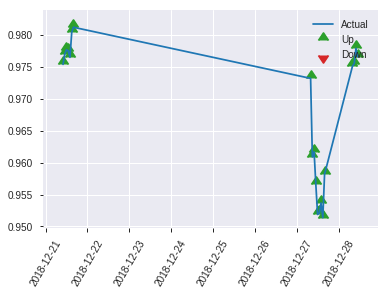


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.26412213294149195
RMSE: 0.5139281398614907
LogLoss: 0.7219952314131329
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 305.36830916935537
Residual deviance: 317.67790182177856
AIC: 2385.6779018217785
AUC: 0.5615734989648034
pr_auc: 0.5474532888689141
Gini: 0.1231469979296067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.554760178873468: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    105  0        (0.0/105.0)
Total  2    218  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55476      0.650155  217
max f2                       0.55476      0.822884  217
max f0point5                 0.619816     0.569892  89
max accuracy                 0.641264     0.595455  51
max precision                0.692535     1         0
max recall                   0.55476      1         217
max specificity              0.692535     1         0
max absolute_mcc             0.641264     0.196676  51
max min_per_class_accuracy   0.603817     0.561905  107
max mean_per_class_accuracy  0.619816     0.591511  89

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 61.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.666173           0.698413  0.698413           0.333333         0.679784  0.333333                    0.679784            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.664821           2.09524   1.25714            1                0.665333  0.6                         0.674003            0.0190476       0.0285714                  109.524   25.7143
    3        0.0318182                   0.66417            1.04762   1.19728            0.5              0.664423  0.571429                    0.671266            0.00952381      0.0380952                  4.7619    19.7279
    4        0.0409091                   0.662623           2.09524   1.39683            1                0.663611  0.666667                    0.669565            0.0190476       0.0571429                  109.524   39.6825
    5        0.05                        0.660045           1.04762   1.33333            0.5              0.662465  0.636364                    0.668274            0.00952381      0.0666667                  4.7619    33.3333
    6        0.1                         0.655793           1.14286   1.2381             0.545455         0.657662  0.590909                    0.662968            0.0571429       0.12381                    14.2857   23.8095
    7        0.15                        0.65224            1.52381   1.33333            0.727273         0.654406  0.636364                    0.660114            0.0761905       0.2                        52.381    33.3333
    8        0.2                         0.644606           1.33333   1.33333            0.636364         0.648273  0.636364                    0.657154            0.0666667       0.266667                   33.3333   33.3333
    9        0.3                         0.635847           0.952381  1.20635            0.454545         0.640202  0.575758                    0.651503            0.0952381       0.361905                   -4.7619   20.6349
    10       0.4                         0.621133           1.2381    1.21429            0.590909         0.629763  0.579545                    0.646068            0.12381         0.485714                   23.8095   21.4286
    11       0.5                         0.60121            0.761905  1.12381            0.363636         0.610556  0.536364                    0.638966            0.0761905       0.561905                   -23.8095  12.381
    12       0.6                         0.592664           0.761905  1.06349            0.363636         0.597482  0.507576                    0.632052            0.0761905       0.638095                   -23.8095  6.34921
    13       0.7                         0.584714           0.571429  0.993197           0.272727         0.588347  0.474026                    0.625808            0.0571429       0.695238                   -42.8571  -0.680272
    14       0.8                         0.580612           0.761905  0.964286           0.363636         0.582981  0.460227                    0.620455            0.0761905       0.771429                   -23.8095  -3.57143
    15       0.9                         0.570044           1.14286   0.984127           0.545455         0.575514  0.469697                    0.615462            0.114286        0.885714                   14.2857   -1.5873
    16       1                           0.550944           1.14286   1                  0.545455         0.561     0.477273                    0.610015      

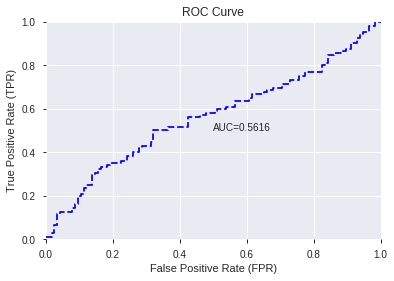

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


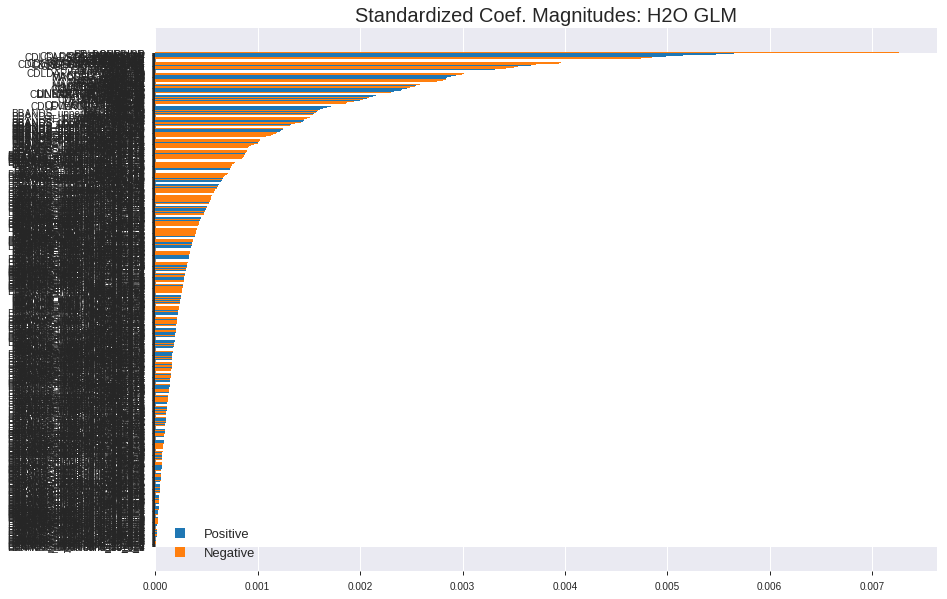

'log_likelihood'
--2019-08-28 16:53:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_165314_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_165314_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

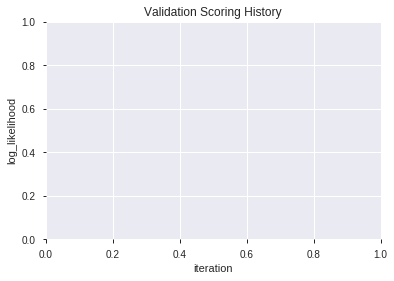

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_165403_model_5  0.567205  0.834891              0.478675  0.553194  0.306024
1               XGBoost_3_AutoML_20190828_165403  0.565466  0.777273              0.495652  0.535805  0.287087
2  XGBoost_grid_1_AutoML_20190828_165403_model_6  0.560828  0.743905              0.491304  0.522334  0.272833
3  XGBoost_grid_1_AutoML_20190828_165403_model_3  0.555445  0.796903              0.478675  0.542130  0.293904
4               XGBoost_1_AutoML_20190828_165403  0.551553  0.772719              0.435404  0.533581  0.284709
5  XGBoost_grid_1_AutoML_20190828_165403_model_1  0.528530  0.843982              0.500000  0.555805  0.308919
6               XGBoost_2_AutoML_20190828_165403  0.521739  0.756159              0.500000  0.528174  0.278968
7  XGBoost_grid_1_AutoML_20190828_165403_model_7  0.514203  0.810634              0.482609  0.546764  0.298950
8  XGBoost_grid_1_AutoML_20190828_165403_model_2  0.512961  0.719854              0.478675  0.512701  0.262862
9  XGBoost_grid_1_AutoML_20190828_165403_model_4  0.484141  0.728190              0.500000  0.516511  0.266784

variable  relative_importance  scaled_importance  percentage
0                     Volume           421.527649           1.000000    0.020277
1                       Open           357.675415           0.848522    0.017206
2             STOCHRSI_fastd           296.782013           0.704063    0.014276
3                       High           240.265564           0.569988    0.011558
4                        BOP           236.893600           0.561988    0.011396
..                       ...                  ...                ...         ...
625   BBANDS_upperband_8_2_4             1.106201           0.002624    0.000053
626                MACD_hist             1.086809           0.002578    0.000052
627                   T3_8_6             1.011282           0.002399    0.000049
628  BBANDS_upperband_24_3_2             0.965302           0.002290    0.000046
629   BBANDS_lowerband_8_8_2             0.884020           0.002097    0.000043

[630 rows x 4 columns]

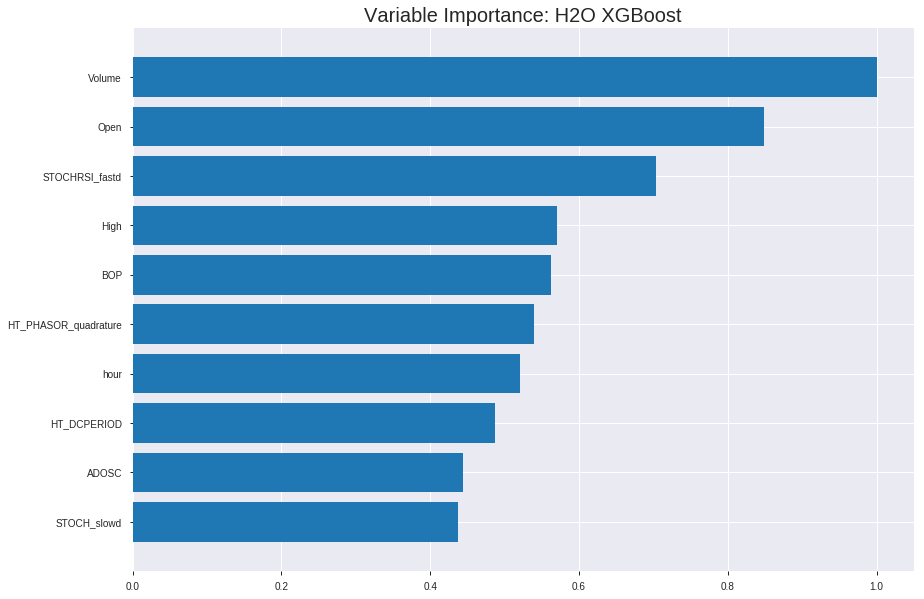

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_165403_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04338140185510946
RMSE: 0.20828202480077215
LogLoss: 0.22277281910025956
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.998719590268886
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5708634853363037: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      756  0    0        (0.0/756.0)
1      0    781  0        (0.0/781.0)
Total  756  781  0        (0.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.570863     1        205
max f2                       0.570863     1        205
max f0point5                 0.570863     1        205
max accuracy                 0.570863     1        205
max precision                0.945156     1        0
max recall                   0.570863     1        205
max specificity              0.945156     1        0
max absolute_mcc             0.570863     1        205
max min_per_class_accuracy   0.570863     1        205
max mean_per_class_accuracy  0.570863     1        205

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.919561           1.96799   1.96799            1                0.932589  1                           0.932589            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.906247           1.96799   1.96799            1                0.911984  1                           0.922619            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.897679           1.96799   1.96799            1                0.902387  1                           0.915731            0.0204866       0.0601793                  96.799    96.799
    4        0.0403383                   0.892036           1.96799   1.96799            1                0.895354  1                           0.910801            0.0192061       0.0793854                  96.799    96.799
    5        0.0500976                   0.886097           1.96799   1.96799            1                0.888988  1                           0.906552            0.0192061       0.0985915                  96.799    96.799
    6        0.100195                    0.868271           1.96799   1.96799            1                0.876914  1                           0.891733            0.0985915       0.197183                   96.799    96.799
    7        0.150293                    0.850115           1.96799   1.96799            1                0.859199  1                           0.880888            0.0985915       0.295775                   96.799    96.799
    8        0.20039                     0.835597           1.96799   1.96799            1                0.84269   1                           0.871339            0.0985915       0.394366                   96.799    96.799
    9        0.299935                    0.798422           1.96799   1.96799            1                0.816954  1                           0.853289            0.195903        0.590269                   96.799    96.799
    10       0.40013                     0.748507           1.96799   1.96799            1                0.775197  1                           0.833734            0.197183        0.787452                   96.799    96.799
    11       0.500325                    0.635649           1.96799   1.96799            1                0.709395  1                           0.808834            0.197183        0.984635                   96.799    96.799
    12       0.59987                     0.258215           0.154352  1.66703            0.0784314        0.331567  0.847072                    0.729635            0.0153649       1                          -84.5648  66.7028
    13       0.700065                    0.210556           0         1.42844            0                0.231008  0.725836                    0.65827             0               1                          -100      42.8439
    14       0.79961                     0.173278           0         1.25061            0                0.193592  0.635476                    0.600421            0               1                          -100      25.061
    15       0.899805                    0.1376             0         1.11135            0                0.154964  0.564714                    0.550819            0               1                          -100      11.1352
    16       1                           0.075992           0         1                  0                0.117641  0.508133                    0.507416            0        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27446549920901886
RMSE: 0.5238945497034865
LogLoss: 0.7550394271402853
Mean Per-Class Error: 0.44988577362409143
AUC: 0.5317964693665629
pr_auc: 0.5028574871049101
Gini: 0.06359293873312577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.284327894449234: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    216  0.96     (216.0/225.0)
1      2    212  0.0093   (2.0/214.0)
Total  11   428  0.4966   (218.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284328     0.660436  388
max f2                       0.249079     0.827533  397
max f0point5                 0.284328     0.550363  388
max accuracy                 0.571024     0.551253  179
max precision                0.795475     0.576923  48
max recall                   0.249079     1         397
max specificity              0.902        0.995556  0
max absolute_mcc             0.571024     0.100637  179
max min_per_class_accuracy   0.551789     0.518692  193
max mean_per_class_accuracy  0.571024     0.550114  179

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 57.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.87955            0.41028   0.41028            0.2              0.889024  0.2                         0.889024            0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   0.857622           0.51285   0.455867           0.25             0.867238  0.222222                    0.879341            0.0046729       0.00934579                 -48.715   -54.4133
    3        0.0318907                   0.846942           1.23084   0.732644           0.6              0.851922  0.357143                    0.869549            0.0140187       0.0233645                  23.0841   -26.7356
    4        0.0410023                   0.838391           1.0257    0.797767           0.5              0.841168  0.388889                    0.863242            0.00934579      0.0327103                  2.57009   -20.2233
    5        0.0501139                   0.83516            1.0257    0.83921            0.5              0.836826  0.409091                    0.858439            0.00934579      0.0420561                  2.57009   -16.079
    6        0.100228                    0.80303            1.30544   1.07232            0.636364         0.821358  0.522727                    0.839899            0.0654206       0.107477                   30.5438   7.23237
    7        0.150342                    0.775054           1.21219   1.11895            0.590909         0.790334  0.545455                    0.823377            0.0607477       0.168224                   21.2192   11.8946
    8        0.200456                    0.758415           0.932455  1.07232            0.454545         0.76799   0.522727                    0.80953             0.046729        0.214953                   -6.75446  7.23237
    9        0.300683                    0.68145            1.07232   1.07232            0.522727         0.716764  0.522727                    0.778608            0.107477        0.32243                    7.23237   7.23237
    10       0.400911                    0.600236           1.07232   1.07232            0.522727         0.643478  0.522727                    0.744826            0.107477        0.429907                   7.23237   7.23237
    11       0.501139                    0.546028           0.885833  1.03503            0.431818         0.573899  0.504545                    0.71064             0.088785        0.518692                   -11.4167  3.50255
    12       0.599089                    0.507031           0.95414   1.0218             0.465116         0.524256  0.498099                    0.680167            0.0934579       0.61215                    -4.58596  2.18009
    13       0.699317                    0.471853           1.0257    1.02236            0.5              0.489174  0.498371                    0.652793            0.102804        0.714953                   2.57009   2.23599
    14       0.799544                    0.436892           0.885833  1.00525            0.431818         0.456841  0.490028                    0.628229            0.088785        0.803738                   -11.4167  0.524536
    15       0.899772                    0.375185           1.07232   1.01272            0.522727         0.404891  0.493671                    0.603351            0.107477        0.911215                   7.23237   1.27174
    16       1                           0.232767           0.885833  1                  0.431818         0.31797   0.487472                    0.574748     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:54:35  16.184 sec  0                  0.5              0.693147            0.5             0                  1                0.491867                         0.5                0.693147              0.5               0                    1                  0.512528
    2019-08-28 16:54:37  17.761 sec  5                  0.450288         0.597907            0.961517        0.963695           1.96799          0.0917372                        0.500016           0.693183              0.534195          0.521486             1.23084            0.505695
    2019-08-28 16:54:37  18.466 sec  10                 0.40831          0.52312             0.988222        0.987937           1.96799          0.0500976                        0.502661           0.698678              0.524434          0.500189             0.41028            0.512528
    2019-08-28 16:54:38  19.175 sec  15                 0.370869         0.460246            0.996785        0.994844           1.96799          0.022121                         0.505444           0.704799              0.529668          0.503615             0.41028            0.512528
    2019-08-28 16:54:39  19.856 sec  20                 0.344776         0.418253            0.998292        0.997283           1.96799          0.013663                         0.509187           0.713288              0.52864           0.506033             0                  0.512528
    2019-08-28 16:54:40  20.563 sec  25                 0.315161         0.372648            0.999625        0.997104           1.96799          0.0071568                        0.510806           0.71835               0.5327            0.501327             0.41028            0.496583
    2019-08-28 16:54:40  21.391 sec  30                 0.285689         0.32905             0.999902        0.998628           1.96799          0.00325309                       0.512959           0.723798              0.531568          0.503458             0.41028            0.494305
    2019-08-28 16:54:41  22.089 sec  35                 0.262592         0.296132            0.999985        0.998705           1.96799          0.00130124                       0.515448           0.730665              0.529346          0.499038             0.41028            0.498861
    2019-08-28 16:54:42  22.765 sec  40                 0.244864         0.271393            1               0.99872            1.96799          0                                0.520131           0.744301              0.53161           0.499049             0.41028            0.487472
    2019-08-28 16:54:43  23.547 sec  45                 0.227575         0.247972            1               0.99872            1.96799          0                                0.521457           0.747704              0.529418          0.500037             0.41028            0.482916
    2019-08-28 16:54:43  24.342 sec  50                 0.208282         0.222773            1               0.99872            1.96799          0                                0.523895           0.755039              0.531796          0.502857             0.41028            0.496583

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
Volume                   421.52764892578125     1.0                   0.020277142146227282
Open                     357.6754150390625      0.8485218370623151    0.017205597904290465
STOCHRSI_fastd           296.7820129394531      0.7040629806746266    0.014276385139035876
High                     240.26556396484375     0.5699876735894672    0.011557721078971024
BOP                      236.8936004638672      0.5619882849145614    0.011395516337727039
---                      ---                    ---                   ---
BBANDS_upperband_8_2_4   1.1062008142471313     0.002624266325272298  5.321262130710391e-05
MACD_hist                1.0868093967437744     0.002578263607413164  5.227981765796145e-05
T3_8_6                   1.0112820863723755     0.002399088384710994  4.8646656198147626e-05
BBANDS_upperband_24_3_2  0.9653018116950989     0.002290008292825082  4.6434823669653454e-05
BBANDS_lowerband_8_8_2   0.8840200304985046     0.002097181603036803  4.252484947123005e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5909090909090909)

('F1', 0.6540880503144655)

('auc', 0.5672049689440993)

('logloss', 0.834890615838397)

('mean_per_class_error', 0.4188405797101449)

('rmse', 0.5531942293576192)

('mse', 0.3060238553945702)

xgboost prediction progress: |████████████████████████████████████████████| 100%


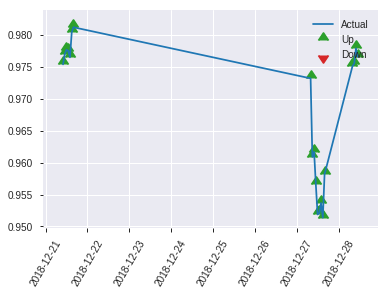


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3060238553945702
RMSE: 0.5531942293576192
LogLoss: 0.834890615838397
Mean Per-Class Error: 0.4188405797101449
AUC: 0.5672049689440993
pr_auc: 0.520671133964473
Gini: 0.13440993788819866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3982413411140442: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    109  0.9478   (109.0/115.0)
1      1    104  0.0095   (1.0/105.0)
Total  7    213  0.5      (110.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398241     0.654088  212
max f2                       0.398241     0.821485  212
max f0point5                 0.772101     0.555556  83
max accuracy                 0.811724     0.590909  50
max precision                0.811724     0.647059  50
max recall                   0.293144     1         219
max specificity              0.911758     0.991304  0
max absolute_mcc             0.811724     0.186734  50
max min_per_class_accuracy   0.745435     0.542857  106
max mean_per_class_accuracy  0.772101     0.581159  83

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 70.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.897062           0.698413  0.698413           0.333333         0.904326  0.333333                    0.904326            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.88929            1.04762   0.838095           0.5              0.890812  0.4                         0.89892             0.00952381      0.0190476                  4.7619    -16.1905
    3        0.0318182                   0.883068           0         0.598639           0                0.886695  0.285714                    0.895427            0               0.0190476                  -100      -40.1361
    4        0.0409091                   0.878112           0         0.465608           0                0.879648  0.222222                    0.891921            0               0.0190476                  -100      -53.4392
    5        0.05                        0.87048            1.04762   0.571429           0.5              0.8744    0.272727                    0.888735            0.00952381      0.0285714                  4.7619    -42.8571
    6        0.1                         0.845065           1.52381   1.04762            0.727273         0.859401  0.5                         0.874068            0.0761905       0.104762                   52.381    4.7619
    7        0.15                        0.832047           1.71429   1.26984            0.818182         0.839453  0.606061                    0.86253             0.0857143       0.190476                   71.4286   26.9841
    8        0.2                         0.817095           1.52381   1.33333            0.727273         0.82307   0.636364                    0.852665            0.0761905       0.266667                   52.381    33.3333
    9        0.3                         0.798177           0.952381  1.20635            0.454545         0.807769  0.575758                    0.837699            0.0952381       0.361905                   -4.7619   20.6349
    10       0.4                         0.76715            1.04762   1.16667            0.5              0.783362  0.556818                    0.824115            0.104762        0.466667                   4.7619    16.6667
    11       0.5                         0.739123           0.761905  1.08571            0.363636         0.753999  0.518182                    0.810092            0.0761905       0.542857                   -23.8095  8.57143
    12       0.6                         0.717358           0.952381  1.06349            0.454545         0.726502  0.507576                    0.79616             0.0952381       0.638095                   -4.7619   6.34921
    13       0.7                         0.644651           0.761905  1.02041            0.363636         0.689338  0.487013                    0.7809              0.0761905       0.714286                   -23.8095  2.04082
    14       0.8                         0.574406           1.2381    1.04762            0.590909         0.608087  0.5                         0.759298            0.12381         0.838095                   23.8095   4.7619
    15       0.9                         0.469064           0.666667  1.00529            0.318182         0.526133  0.479798                    0.733391            0.0666667       0.904762                   -33.3333  0.529101
    16       1                           0.293144           0.952381  1                  0.454545         0.405969  0.477273                    0.700649     

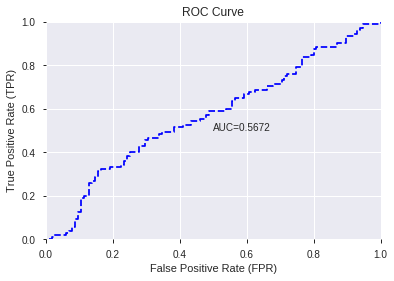

This function is available for GLM models only


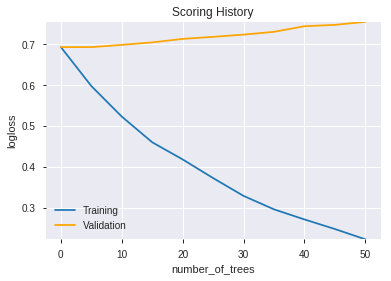

--2019-08-28 16:54:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_165403_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_165403_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_165508_model_6  0.579793  0.789109              0.482609  0.540469  0.292106
1  DeepLearning_grid_1_AutoML_20190828_165508_model_7  0.569938  1.205775              0.478261  0.601832  0.362202
2  DeepLearning_grid_1_AutoML_20190828_165508_model_5  0.563230  0.773053              0.495652  0.535021  0.286248
3  DeepLearning_grid_1_AutoML_20190828_165508_model_9  0.556770  0.693467              0.500000  0.500160  0.250160
4  DeepLearning_grid_1_AutoML_20190828_165508_model_4  0.542526  1.840684              0.491304  0.661625  0.437748
5  DeepLearning_grid_1_AutoML_20190828_165508_model_2  0.533913  4.997241              0.500000  0.690478  0.476759
6               DeepLearning_1_AutoML_20190828_165508  0.468489  1.581046              0.500000  0.633014  0.400706
7  DeepLearning_grid_1_AutoML_20190828_165508_model_8  0.442443  0.695978              0.479503  0.501393  0.251395
8  DeepLearning_grid_1_AutoML_20190828_165508_model_3  0.438592  1.712240              0.478675  0.681229  0.464073
9  DeepLearning_grid_1_AutoML_20190828_165508_model_1  0.414741  3.276213              0.495652  0.707419  0.500442

variable  relative_importance  scaled_importance  percentage
0                  dayofweek             1.000000           1.000000    0.026142
1                   CORREL_8             0.983691           0.983691    0.025715
2                     SAREXT             0.899136           0.899136    0.023505
3               HT_TRENDMODE             0.887576           0.887576    0.023203
4                        OBV             0.872966           0.872966    0.022821
5                     ADX_24             0.868321           0.868321    0.022699
6             STOCHRSI_fastd             0.857933           0.857933    0.022428
7                        day             0.857175           0.857175    0.022408
8              days_in_month             0.850036           0.850036    0.022221
9                 aroonup_30             0.844796           0.844796    0.022084
10               HT_DCPERIOD             0.826846           0.826846    0.021615
11                    VAR_24             0.816262           0.816262    0.021339
12                 CORREL_12             0.805851           0.805851    0.021066
13                aroonup_20             0.802440           0.802440    0.020977
14                      DX_8             0.797131           0.797131    0.020838
15                     DX_12             0.791594           0.791594    0.020694
16                     DX_14             0.787162           0.787162    0.020578
17                AROONOSC_8             0.783563           0.783563    0.020484
18                   KAMA_24             0.778806           0.778806    0.020359
19              STOCHF_fastk             0.760591           0.760591    0.019883
20                weekofyear             0.755782           0.755782    0.019757
21                       DIV             0.753791           0.753791    0.019705
22                 CORREL_30             0.748175           0.748175    0.019559
23                PLUS_DI_20             0.748136           0.748136    0.019558
24                    RSI_12             0.747462           0.747462    0.019540
25                    BETA_8             0.744733           0.744733    0.019469
26   BBANDS_upperband_24_3_2             0.744319           0.744319    0.019458
27             CDLHIKKAKEMOD             0.742309           0.742309    0.019405
28           CDLHOMINGPIGEON             0.741002           0.741002    0.019371
29              CDLTHRUSTING             0.738668           0.738668    0.019310
30    BBANDS_lowerband_8_3_4             0.725032           0.725032    0.018954
31                    CCI_30             0.716234           0.716234    0.018724
32         CDLSTALLEDPATTERN             0.715150           0.715150    0.018695
33   BBANDS_upperband_20_3_5             0.714701           0.714701    0.018684
34                     VAR_8             0.713905           0.713905    0.018663
35            CDLMATCHINGLOW             0.713352           0.713352    0.018648
36         CDLGRAVESTONEDOJI             0.707323           0.707323    0.018491
37                     DX_24             0.707318           0.707318    0.018491
38  BBANDS_middleband_14_4_5             0.705798           0.705798    0.018451
39           CDLADVANCEBLOCK             0.705167           0.705167    0.018434
40                     FLOOR             0.702012           0.702012    0.018352
41       CDLGAPSIDESIDEWHITE             0.701569           0.701569    0.018340
42                 PLUS_DM_8             0.699885           0.699885    0.018296
43        CDLMORNINGDOJISTAR             0.697112           0.697112    0.018224
44        CDLIDENTICAL3CROWS             0.684407           0.684407    0.017892
45           CDLLADDERBOTTOM             0.681782           0.681782    0.017823
46                    ROC_20             0.671386           0.671386    0.017551
47              CDLTASUKIGAP             0.657311           0.657311    0.017183
48   BBANDS_lowerband_12_2_3             0.655160  

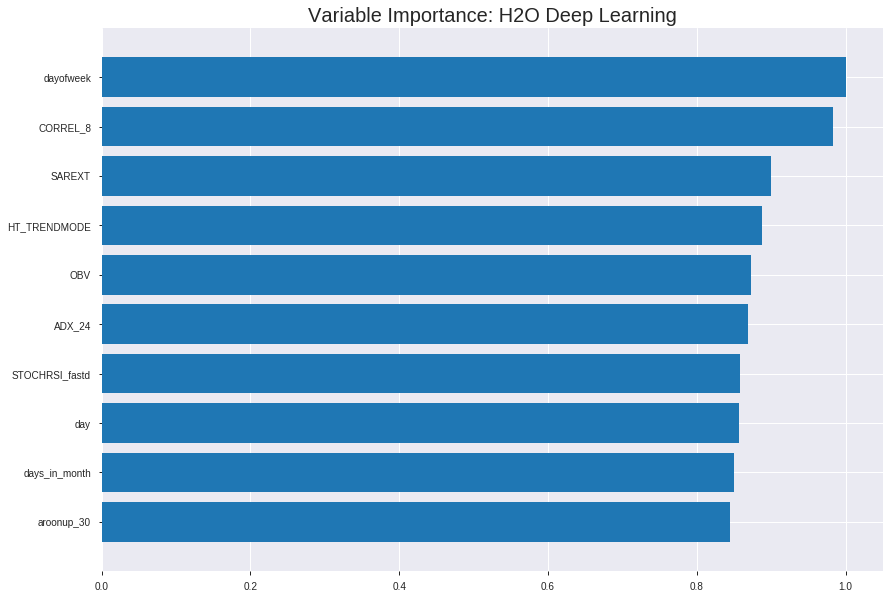

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_165508_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2342123733084665
RMSE: 0.4839549290052396
LogLoss: 0.6595224625316964
Mean Per-Class Error: 0.4007546965293445
AUC: 0.6402099465479747
pr_auc: 0.6581492114975973
Gini: 0.2804198930959494
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3728290783902822: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      78   678   0.8968   (678.0/756.0)
1      18   763   0.023    (18.0/781.0)
Total  96   1441  0.4528   (696.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372829     0.686769  337
max f2                       0.297583     0.839818  373
max f0point5                 0.522369     0.607169  194
max accuracy                 0.522369     0.59987   194
max precision                0.936595     1         0
max recall                   0.201441     1         394
max specificity              0.936595     1         0
max absolute_mcc             0.588581     0.217549  104
max min_per_class_accuracy   0.527303     0.587302  187
max mean_per_class_accuracy  0.522369     0.599245  194

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.833423           1.96799   1.96799            1                0.872896  1                           0.872896            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.767546           1.57439   1.77754            0.8              0.804272  0.903226                    0.839691            0.0153649       0.0358515                  57.4392   77.7539
    3        0.0305791                   0.714361           1.59899   1.71676            0.8125           0.738018  0.87234                     0.805079            0.0166453       0.0524968                  59.8992   71.6757
    4        0.0403383                   0.677461           1.44319   1.65057            0.733333         0.692217  0.83871                     0.777774            0.0140845       0.0665813                  44.3192   65.0572
    5        0.0500976                   0.662486           1.70559   1.66129            0.866667         0.670274  0.844156                    0.756832            0.0166453       0.0832266                  70.5591   66.129
    6        0.100195                    0.603803           1.61017   1.63573            0.818182         0.628298  0.831169                    0.692565            0.0806658       0.163892                   61.0173   63.5732
    7        0.150293                    0.583222           1.15012   1.47386            0.584416         0.591864  0.748918                    0.658998            0.0576184       0.221511                   15.0124   47.3862
    8        0.20039                     0.567358           1.15012   1.39293            0.584416         0.574804  0.707792                    0.637949            0.0576184       0.279129                   15.0124   39.2928
    9        0.299935                    0.547665           1.15764   1.31484            0.588235         0.557101  0.668113                    0.611117            0.115237        0.394366                   15.7641   31.4839
    10       0.40013                     0.536633           0.983995  1.23199            0.5              0.542003  0.626016                    0.59381             0.0985915       0.492958                   -1.60051  23.1994
    11       0.500325                    0.527363           0.920099  1.16953            0.467532         0.532287  0.594278                    0.58149             0.0921895       0.585147                   -7.99009  16.9534
    12       0.59987                     0.514115           1.01615   1.14408            0.51634          0.521072  0.581345                    0.571464            0.101152        0.6863                     1.61516   14.4081
    13       0.700065                    0.494218           0.843424  1.10105            0.428571         0.505178  0.55948                     0.561977            0.084507        0.770807                   -15.6576  10.105
    14       0.79961                     0.460467           0.900387  1.07607            0.457516         0.478702  0.546786                    0.55161             0.0896287       0.860435                   -9.96125  7.60693
    15       0.899805                    0.408154           0.868982  1.05301            0.441558         0.436223  0.535069                    0.538761            0.0870679       0.947503                   -13.1018  5.30097
    16       1                           0.137792           0.523945  1                  0.266234         0.337217  0.508133                    0.518567            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2786478168465067
RMSE: 0.5278710229274824
LogLoss: 0.7580263427349209
Mean Per-Class Error: 0.4784319833852544
AUC: 0.48382139148494285
pr_auc: 0.4683137813028524
Gini: -0.032357217030114294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28236366911759253: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    214  0        (0.0/214.0)
Total  1    438  0.5103   (224.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282364     0.656442  398
max f2                       0.282364     0.826893  398
max f0point5                 0.282364     0.544252  398
max accuracy                 0.597302     0.52164   202
max precision                0.714463     0.517241  80
max recall                   0.282364     1         398
max specificity              0.870753     0.995556  0
max absolute_mcc             0.771657     0.140456  19
max min_per_class_accuracy   0.595837     0.518692  206
max mean_per_class_accuracy  0.595837     0.521568  206

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 61.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.820605           0.41028   0.41028            0.2              0.839333  0.2                         0.839333            0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   0.800293           0         0.227934           0                0.809571  0.111111                    0.826106            0               0.0046729                  -100      -77.2066
    3        0.0318907                   0.789025           0.820561  0.439586           0.4              0.794741  0.214286                    0.814904            0.00934579      0.0140187                  -17.9439  -56.0414
    4        0.0410023                   0.77381            0.51285   0.455867           0.25             0.776557  0.222222                    0.806382            0.0046729       0.0186916                  -48.715   -54.4133
    5        0.0501139                   0.770405           0         0.372982           0                0.772905  0.181818                    0.800296            0               0.0186916                  -100      -62.7018
    6        0.100228                    0.744234           1.49193   0.932455           0.727273         0.758625  0.454545                    0.77946             0.0747664       0.0934579                  49.1929   -6.75446
    7        0.150342                    0.727157           1.11895   0.994619           0.545455         0.737993  0.484848                    0.765638            0.0560748       0.149533                   11.8946   -0.538091
    8        0.200456                    0.713089           1.21219   1.04901            0.590909         0.720536  0.511364                    0.754362            0.0607477       0.21028                    21.2192   4.90123
    9        0.300683                    0.666136           0.932455  1.01016            0.454545         0.695666  0.492424                    0.734797            0.0934579       0.303738                   -6.75446  1.016
    10       0.400911                    0.629773           0.979078  1.00239            0.477273         0.648657  0.488636                    0.713262            0.0981308       0.401869                   -2.09218  0.238955
    11       0.501139                    0.595532           1.16557   1.03503            0.568182         0.610698  0.504545                    0.692749            0.116822        0.518692                   16.5569   3.50255
    12       0.599089                    0.576383           0.811019  0.998401           0.395349         0.584549  0.486692                    0.675059            0.0794393       0.598131                   -18.8981  -0.159909
    13       0.699317                    0.549201           0.652719  0.948857           0.318182         0.563163  0.462541                    0.659022            0.0654206       0.663551                   -34.7281  -5.11431
    14       0.799544                    0.535877           1.0257    0.95849            0.5              0.541993  0.467236                    0.644351            0.102804        0.766355                   2.57009   -4.15102
    15       0.899772                    0.517325           1.07232   0.97117            0.522727         0.527859  0.473418                    0.631375            0.107477        0.873832                   7.23237   -2.883
    16       1                           0.274267           1.25881   1                  0.613636         0.453406  0.487472                    0.613538


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:58:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:58:22  1 min 17.615 sec  942 obs/sec       1.21275   1             1864       0.56113          0.900678            -0.259803      0.547111        0.531928           0.983995         0.486012                         0.575158           0.909458              -0.324057        0.429169          0.443485             1.23084            0.512528
    2019-08-28 16:58:27  1 min 22.974 sec  1940 obs/sec      8.6337    7             13270      0.496375         0.685798            0.014185       0.605636        0.604301           1.47599          0.466493                         0.541403           0.78906               -0.173204        0.473178          0.485508             1.64112            0.507973
    2019-08-28 16:58:33  1 min 28.469 sec  2562 obs/sec      19.7918   16            30420      0.483955         0.659522            0.0629026      0.64021         0.658149           1.96799          0.45283                          0.527871           0.758026              -0.115292        0.483821          0.468314             0.41028            0.510251
    2019-08-28 16:58:38  1 min 33.481 sec  2887 obs/sec      30.8393   25            47400      0.484828         0.660008            0.0595174      0.657045        0.671217           1.96799          0.423552                         0.562212           0.864156              -0.265124        0.49162           0.482264             0.41028            0.507973
    2019-08-28 16:58:43  1 min 38.923 sec  3100 obs/sec      43.1412   35            66308      0.471757         0.633045            0.109544       0.690436        0.700117           1.96799          0.416396                         0.545466           0.826425              -0.19088         0.485909          0.486983             0.820561           0.510251
    2019-08-28 16:58:48  1 min 44.350 sec  3233 obs/sec      55.3793   45            85118      0.466576         0.620658            0.128997       0.715873        0.725711           1.96799          0.366298                         0.551234           0.849901              -0.2162          0.499761          0.503918             1.64112            0.510251
    2019-08-28 16:58:49  1 min 44.889 sec  3230 obs/sec      55.3793   45            85118      0.483955         0.659522            0.0629026      0.64021         0.658149           1.96799          0.45283                          0.527871           0.758026              -0.115292        0.483821          0.468314             0.41028            0.510251

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
dayofweek                1.0                    1.0                  0.026141747020067746
CORREL_8                 0.9836910963058472     0.9836910963058472   0.025715403785520556
SAREXT                   0.8991361856460571     0.8991361856460571   0.023504990701747896
HT_TRENDMODE             0.8875762224197388     0.8875762224197388   0.023202793067524194
OBV                      0.8729656934738159     0.8729656934738159   0.022820848315990502
---                      ---                    ---                  ---
CDLLADDERBOTTOM          0.6817823052406311     0.6817823052406311   0.017822980546359186
ROC_20                   0.6713857054710388     0.6713857054710388   0.01755119526531361
CDLTASUKIGAP             0.6573109030723572     0.6573109030723572   0.01718325534164983
BBANDS_lowerband_12_2_3  0.6551602482795715     0.6551602482795715   0.017127033468129334
CDLEVENINGSTAR           0.6421352028846741     0.6421352028846741   0.016786536026491026


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6542056074766355)

('auc', 0.5797929606625258)

('logloss', 0.7891089681682315)

('mean_per_class_error', 0.4277432712215321)

('rmse', 0.5404687696577104)

('mse', 0.2921064909753192)

deeplearning prediction progress: |███████████████████████████████████████| 100%


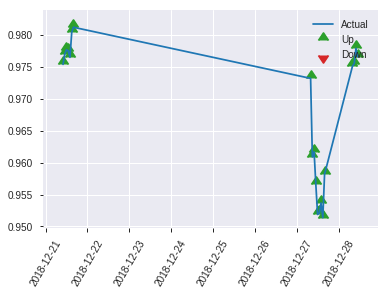


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2921064909753192
RMSE: 0.5404687696577104
LogLoss: 0.7891089681682315
Mean Per-Class Error: 0.4277432712215321
AUC: 0.5797929606625258
pr_auc: 0.5710976632560698
Gini: 0.15958592132505167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5326716641340047: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    111  0.9652   (111.0/115.0)
1      0    105  0        (0.0/105.0)
Total  4    216  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532672     0.654206  215
max f2                       0.532672     0.825472  215
max f0point5                 0.573029     0.55207   172
max accuracy                 0.767355     0.581818  60
max precision                0.904741     1         0
max recall                   0.532672     1         215
max specificity              0.904741     1         0
max absolute_mcc             0.812678     0.18972   6
max min_per_class_accuracy   0.726107     0.556522  109
max mean_per_class_accuracy  0.767093     0.572257  62

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 69.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.878733           2.09524   2.09524            1                0.89641   1                           0.89641             0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.818062           2.09524   2.09524            1                0.825859  1                           0.86819             0.0190476       0.047619                   109.524   109.524
    3        0.0318182                   0.812111           2.09524   2.09524            1                0.813148  1                           0.852463            0.0190476       0.0666667                  109.524   109.524
    4        0.0409091                   0.808218           0         1.62963            0                0.811047  0.777778                    0.84326             0               0.0666667                  -100      62.963
    5        0.05                        0.802867           1.04762   1.52381            0.5              0.805361  0.727273                    0.836369            0.00952381      0.0761905                  4.7619    52.381
    6        0.1                         0.789607           1.14286   1.33333            0.545455         0.797524  0.636364                    0.816947            0.0571429       0.133333                   14.2857   33.3333
    7        0.15                        0.783523           1.14286   1.26984            0.545455         0.786789  0.606061                    0.806894            0.0571429       0.190476                   14.2857   26.9841
    8        0.2                         0.777867           1.52381   1.33333            0.727273         0.781218  0.636364                    0.800475            0.0761905       0.266667                   52.381    33.3333
    9        0.3                         0.76635            0.952381  1.20635            0.454545         0.772517  0.575758                    0.791156            0.0952381       0.361905                   -4.7619   20.6349
    10       0.4                         0.747867           0.952381  1.14286            0.454545         0.759444  0.545455                    0.783228            0.0952381       0.457143                   -4.7619   14.2857
    11       0.5                         0.725616           1.04762   1.12381            0.5              0.737637  0.536364                    0.77411             0.104762        0.561905                   4.7619    12.381
    12       0.6                         0.679242           0.952381  1.09524            0.454545         0.70616   0.522727                    0.762785            0.0952381       0.657143                   -4.7619   9.52381
    13       0.7                         0.637729           0.857143  1.06122            0.409091         0.657895  0.506494                    0.7478              0.0857143       0.742857                   -14.2857  6.12245
    14       0.8                         0.571361           0.952381  1.04762            0.454545         0.595348  0.5                         0.728744            0.0952381       0.838095                   -4.7619   4.7619
    15       0.9                         0.557349           0.571429  0.994709           0.272727         0.564575  0.474747                    0.710503            0.0571429       0.895238                   -42.8571  -0.529101
    16       1                           0.509657           1.04762   1                  0.5              0.54206   0.477273                    0.693659           

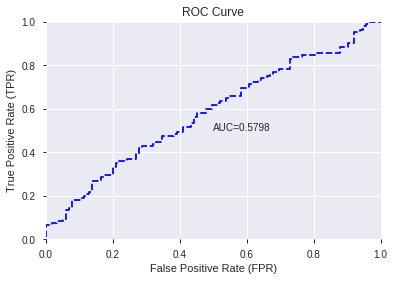

This function is available for GLM models only


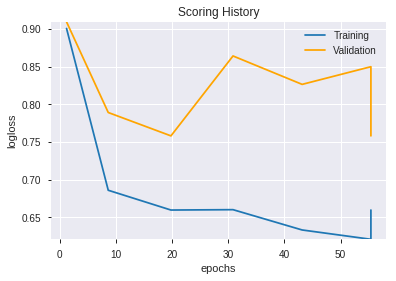

--2019-08-28 17:01:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_165508_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_165508_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['dayofweek',
 'CORREL_8',
 'SAREXT',
 'HT_TRENDMODE',
 'OBV',
 'ADX_24',
 'STOCHRSI_fastd',
 'day',
 'days_in_month',
 'aroonup_30',
 'HT_DCPERIOD',
 'VAR_24',
 'CORREL_12',
 'aroonup_20',
 'DX_8',
 'DX_12',
 'DX_14',
 'AROONOSC_8',
 'KAMA_24',
 'STOCHF_fastk',
 'weekofyear',
 'DIV',
 'CORREL_30',
 'PLUS_DI_20',
 'RSI_12',
 'BETA_8',
 'BBANDS_upperband_24_3_2',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'BBANDS_lowerband_8_3_4',
 'CCI_30',
 'CDLSTALLEDPATTERN',
 'BBANDS_upperband_20_3_5',
 'VAR_8',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'DX_24',
 'BBANDS_middleband_14_4_5',
 'CDLADVANCEBLOCK',
 'FLOOR',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DM_8',
 'CDLMORNINGDOJISTAR',
 'CDLIDENTICAL3CROWS',
 'CDLLADDERBOTTOM',
 'ROC_20',
 'CDLTASUKIGAP',
 'BBANDS_lowerband_12_2_3',
 'CDLEVENINGSTAR']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse     mse
0  GLM_grid_1_AutoML_20190828_170201_model_1  0.553126  0.699744              0.495652  0.503289  0.2533

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD             0.008115           1.000000    0.048493
1                     ADX_24             0.007684           0.946908    0.045918
2                        OBV             0.007679           0.946362    0.045892
3                   CORREL_8             0.006580           0.810894    0.039322
4                    KAMA_24             0.006323           0.779213    0.037786
5             STOCHRSI_fastd             0.006305           0.777020    0.037680
6                  CORREL_12             0.006096           0.751267    0.036431
7    BBANDS_upperband_20_3_5             0.006033           0.743451    0.036052
8                  dayofweek             0.005807           0.715613    0.034702
9    BBANDS_upperband_24_3_2             0.005737           0.707056    0.034287
10  BBANDS_middleband_14_4_5             0.005733           0.706575    0.034264
11              CDLTASUKIGAP             0.005384           0.663475    0.032174
12       CDLGAPSIDESIDEWHITE             0.005322           0.655806    0.031802
13             days_in_month             0.005297           0.652752    0.031654
14    BBANDS_lowerband_8_3_4             0.004981           0.613794    0.029764
15   BBANDS_lowerband_12_2_3             0.004610           0.568119    0.027550
16                    BETA_8             0.004451           0.548470    0.026597
17                    VAR_24             0.004168           0.513599    0.024906
18        CDLMORNINGDOJISTAR             0.003884           0.478656    0.023211
19           CDLLADDERBOTTOM             0.003818           0.470558    0.022819
20              HT_TRENDMODE             0.003803           0.468702    0.022729
21                aroonup_30             0.003690           0.454691    0.022049
22                     FLOOR             0.003686           0.454198    0.022025
23                     VAR_8             0.003656           0.450586    0.021850
24              STOCHF_fastk             0.003250           0.400459    0.019419
25                PLUS_DI_20             0.003231           0.398232    0.019311
26                AROONOSC_8             0.003178           0.391629    0.018991
27                aroonup_20             0.002909           0.358439    0.017382
28                     DX_12             0.002598           0.320137    0.015524
29                     DX_14             0.002400           0.295771    0.014343
30                 PLUS_DM_8             0.002202           0.271370    0.013159
31           CDLHOMINGPIGEON             0.002145           0.264363    0.012820
32                    SAREXT             0.002114           0.260502    0.012632
33                 CORREL_30             0.001794           0.221102    0.010722
34              CDLTHRUSTING             0.001749           0.215589    0.010454
35             CDLHIKKAKEMOD             0.001709           0.210585    0.010212
36            CDLEVENINGSTAR             0.001515           0.186690    0.009053
37                    CCI_30             0.001472           0.181377    0.008795
38         CDLGRAVESTONEDOJI             0.001253           0.154358    0.007485
39                      DX_8             0.001239           0.152723    0.007406
40                    RSI_12             0.001014           0.124911    0.006057
41                weekofyear             0.000912           0.112421    0.005452
42                    ROC_20             0.000425           0.052375    0.002540
43                       DIV             0.000335           0.041261    0.002001
44                       day             0.000263           0.032426    0.001572
45           CDLADVANCEBLOCK             0.000235           0.029021    0.001407
46                     DX_24             0.000225           0.027729    0.001345
47            CDLMATCHINGLOW             0.000179           0.022020    0.001068
48        CDLIDENTICAL3CROWS             0.000119  

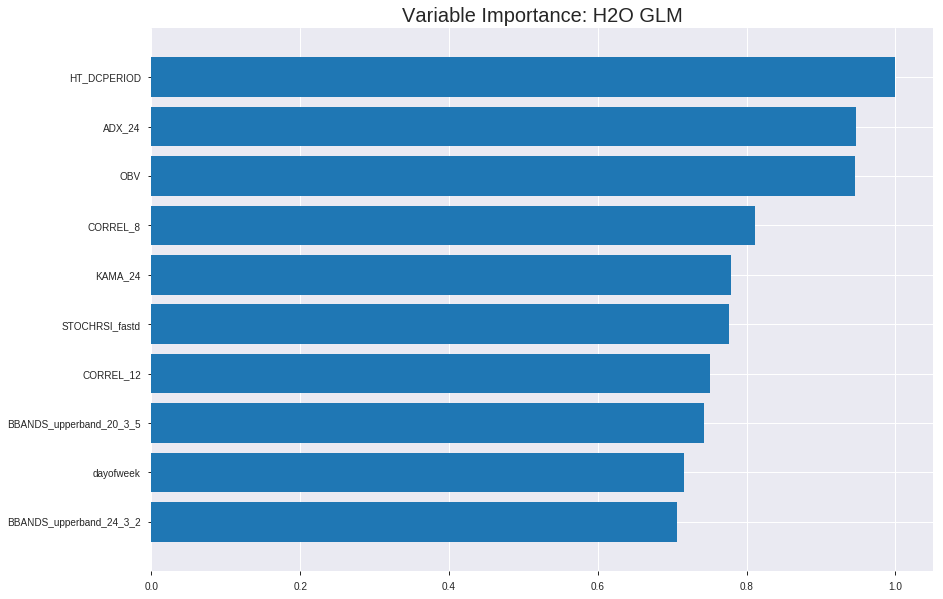

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170201_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24858131481413376
RMSE: 0.4985792964154586
LogLoss: 0.6903066107224639
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.327778804599
Residual deviance: 2122.0025213608546
AIC: 2224.0025213608546
AUC: 0.5721915669098767
pr_auc: 0.5788205413539089
Gini: 0.14438313381975343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48307176588476564: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    750   0.9921   (750.0/756.0)
1      0    781   0        (0.0/781.0)
Total  6    1531  0.488    (750.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483072     0.675606  394
max f2                       0.483072     0.838883  394
max f0point5                 0.504304     0.582504  236
max accuracy                 0.504304     0.566688  236
max precision                0.56676      1         0
max recall                   0.483072     1         394
max specificity              0.56676      1         0
max absolute_mcc             0.504304     0.134249  236
max min_per_class_accuracy   0.508569     0.555556  193
max mean_per_class_accuracy  0.504304     0.564414  236

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.528267           1.59899   1.59899            0.8125           0.54048   0.8125                      0.54048             0.0166453       0.0166453                  59.8992   59.8992
    2        0.0201692                   0.527383           1.31199   1.46012            0.666667         0.527849  0.741935                    0.534368            0.0128041       0.0294494                  31.1993   46.0121
    3        0.0305791                   0.526395           1.47599   1.46552            0.75             0.526915  0.744681                    0.531831            0.0153649       0.0448143                  47.5992   46.5524
    4        0.0403383                   0.525682           0.918395  1.33315            0.466667         0.525922  0.677419                    0.530402            0.00896287      0.0537772                  -8.16048  33.3154
    5        0.0500976                   0.52509            1.18079   1.30347            0.6              0.525437  0.662338                    0.529434            0.0115237       0.0653009                  18.0794   30.3474
    6        0.100195                    0.521836           1.15012   1.2268             0.584416         0.523227  0.623377                    0.526331            0.0576184       0.122919                   15.0124   22.6799
    7        0.150293                    0.519896           1.15012   1.20124            0.584416         0.520787  0.61039                     0.524483            0.0576184       0.180538                   15.0124   20.1241
    8        0.20039                     0.518081           1.17568   1.19485            0.597403         0.518973  0.607143                    0.523105            0.0588988       0.239437                   17.5682   19.4851
    9        0.299935                    0.514805           0.926113  1.10566            0.470588         0.51636   0.561822                    0.520867            0.0921895       0.331626                   -7.38872  10.566
    10       0.40013                     0.511763           1.08623   1.10079            0.551948         0.513283  0.55935                     0.518968            0.108835        0.440461                   8.62281   10.0794
    11       0.500325                    0.508551           1.1629    1.11323            0.590909         0.510205  0.56567                     0.517213            0.116517        0.556978                   16.2903   11.3232
    12       0.59987                     0.505285           1.01615   1.09712            0.51634          0.506911  0.557484                    0.515503            0.101152        0.658131                   1.61516   9.71223
    13       0.700065                    0.502735           0.971216  1.0791             0.493506         0.504039  0.548327                    0.513862            0.0973111       0.755442                   -2.87843  7.91022
    14       0.79961                     0.498701           0.733173  1.03604            0.372549         0.500979  0.526444                    0.512259            0.0729834       0.828425                   -26.6827  3.60369
    15       0.899805                    0.491886           0.843424  1.01459            0.428571         0.495619  0.515546                    0.510406            0.084507        0.912932                   -15.6576  1.45891
    16       1                           0.477117           0.868982  1                  0.441558         0.48772   0.508133                    0.508133          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2514335033773135
RMSE: 0.5014314543158551
LogLoss: 0.6960128125801053
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 609.0572554147116
Residual deviance: 611.0992494453325
AIC: 713.0992494453325
AUC: 0.5092834890965732
pr_auc: 0.5197315212147015
Gini: 0.018566978193146344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023201176251363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    214  0        (0.0/214.0)
Total  1    438  0.5103   (224.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50232      0.656442  398
max f2                       0.50232      0.826893  398
max f0point5                 0.50232      0.544252  398
max accuracy                 0.539907     0.548975  77
max precision                0.58429      1         0
max recall                   0.50232      1         398
max specificity              0.58429      1         0
max absolute_mcc             0.539907     0.106274  77
max min_per_class_accuracy   0.531455     0.490654  198
max mean_per_class_accuracy  0.539907     0.541038  77

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.578571           1.64112   1.64112            0.8              0.581137  0.8                         0.581137            0.0186916       0.0186916                  64.1121   64.1121
    2        0.0205011                   0.576827           0.51285   1.13967            0.25             0.577629  0.555556                    0.579578            0.0046729       0.0233645                  -48.715   13.9668
    3        0.0318907                   0.575383           1.23084   1.17223            0.6              0.576213  0.571429                    0.578376            0.0140187       0.0373832                  23.0841   17.223
    4        0.0410023                   0.57409            2.0514    1.3676             1                0.574732  0.666667                    0.577566            0.0186916       0.0560748                  105.14    36.7601
    5        0.0501139                   0.573498           1.0257    1.30544            0.5              0.573845  0.636364                    0.57689             0.00934579      0.0654206                  2.57009   30.5438
    6        0.100228                    0.543876           1.11895   1.21219            0.545455         0.564735  0.590909                    0.570812            0.0560748       0.121495                   11.8946   21.2192
    7        0.150342                    0.540862           1.11895   1.18111            0.545455         0.54234   0.575758                    0.561322            0.0560748       0.17757                    11.8946   18.111
    8        0.200456                    0.539508           1.0257    1.14226            0.5              0.540169  0.556818                    0.556033            0.0514019       0.228972                   2.57009   14.2258
    9        0.300683                    0.536417           0.979078  1.08786            0.477273         0.537902  0.530303                    0.549989            0.0981308       0.327103                   -2.09218  8.78646
    10       0.400911                    0.534012           0.979078  1.06067            0.477273         0.535103  0.517045                    0.546268            0.0981308       0.425234                   -2.09218  6.0668
    11       0.501139                    0.531332           0.652719  0.979078           0.318182         0.532552  0.477273                    0.543525            0.0654206       0.490654                   -34.7281  -2.09218
    12       0.599089                    0.526315           1.04955   0.990601           0.511628         0.528901  0.48289                     0.541134            0.102804        0.593458                   4.95544   -0.93991
    13       0.699317                    0.522468           0.885833  0.975585           0.431818         0.524076  0.47557                     0.538689            0.088785        0.682243                   -11.4167  -2.44147
    14       0.799544                    0.518396           1.07232   0.987712           0.522727         0.520836  0.481481                    0.536451            0.107477        0.78972                    7.23237   -1.2288
    15       0.899772                    0.514207           1.0257    0.991944           0.5              0.516434  0.483544                    0.534221            0.102804        0.892523                   2.57009   -0.805631
    16       1                           0.501628           1.07232   1                  0.522727         0.509415  0.487472                    0.531735       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:02:02  0.000 sec   2            3         51            1.38061           1.39203
    2019-08-28 17:02:02  0.016 sec   4            1.9       51            1.37836           1.39553
    2019-08-28 17:02:02  0.028 sec   6            1.2       51            1.37555           1.40106
    2019-08-28 17:02:02  0.045 sec   8            0.72      51            1.37224           1.40927
    2019-08-28 17:02:02  0.063 sec   10           0.45      51            1.36858           1.42068

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5954545454545455)

('F1', 0.6481481481481481)

('auc', 0.5531262939958592)

('logloss', 0.6997437411985322)

('mean_per_class_error', 0.40973084886128364)

('rmse', 0.5032887218206396)

('mse', 0.25329953751185313)

glm prediction progress: |████████████████████████████████████████████████| 100%


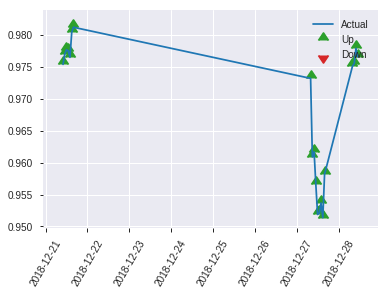


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25329953751185313
RMSE: 0.5032887218206396
LogLoss: 0.6997437411985322
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.36830916935537
Residual deviance: 307.88724612735416
AIC: 409.88724612735416
AUC: 0.5531262939958592
pr_auc: 0.5487625789388048
Gini: 0.10625258799171844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5297603500512651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    114  0.9913   (114.0/115.0)
1      0    105  0        (0.0/105.0)
Total  1    219  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52976      0.648148  218
max f2                       0.52976      0.821596  218
max f0point5                 0.569978     0.566893  83
max accuracy                 0.571124     0.595455  81
max precision                0.621167     1         0
max recall                   0.52976      1         218
max specificity              0.621167     1         0
max absolute_mcc             0.585327     0.18972   6
max min_per_class_accuracy   0.545332     0.556522  109
max mean_per_class_accuracy  0.569978     0.590269  83

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 55.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.605993           2.09524   2.09524            1                0.614294  1                           0.614294            0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.585619           2.09524   2.09524            1                0.586429  1                           0.603148            0.0190476       0.047619                   109.524   109.524
    3        0.0318182                   0.585272           2.09524   2.09524            1                0.585363  1                           0.598067            0.0190476       0.0666667                  109.524   109.524
    4        0.0409091                   0.584481           0         1.62963            0                0.585047  0.777778                    0.595173            0               0.0666667                  -100      62.963
    5        0.05                        0.583394           0         1.33333            0                0.583927  0.636364                    0.593129            0               0.0666667                  -100      33.3333
    6        0.1                         0.581419           1.14286   1.2381             0.545455         0.58238   0.590909                    0.587754            0.0571429       0.12381                    14.2857   23.8095
    7        0.15                        0.579134           0.761905  1.07937            0.363636         0.580427  0.515152                    0.585312            0.0380952       0.161905                   -23.8095  7.93651
    8        0.2                         0.577159           1.33333   1.14286            0.636364         0.578105  0.545455                    0.58351             0.0666667       0.228571                   33.3333   14.2857
    9        0.3                         0.573179           1.33333   1.20635            0.636364         0.574812  0.575758                    0.580611            0.133333        0.361905                   33.3333   20.6349
    10       0.4                         0.569217           1.14286   1.19048            0.545455         0.571563  0.568182                    0.578349            0.114286        0.47619                    14.2857   19.0476
    11       0.5                         0.545296           0.857143  1.12381            0.409091         0.556932  0.536364                    0.574065            0.0857143       0.561905                   -14.2857  12.381
    12       0.6                         0.541512           0.761905  1.06349            0.363636         0.543243  0.507576                    0.568928            0.0761905       0.638095                   -23.8095  6.34921
    13       0.7                         0.5385             0.571429  0.993197           0.272727         0.54012   0.474026                    0.564813            0.0571429       0.695238                   -42.8571  -0.680272
    14       0.8                         0.535063           1.04762   1                  0.5              0.536588  0.477273                    0.561285            0.104762        0.8                        4.7619    0
    15       0.9                         0.532777           0.952381  0.994709           0.454545         0.533817  0.474747                    0.558233            0.0952381       0.895238                   -4.7619   -0.529101
    16       1                           0.5297             1.04762   1                  0.5              0.531366  0.477273                    0.555546            0

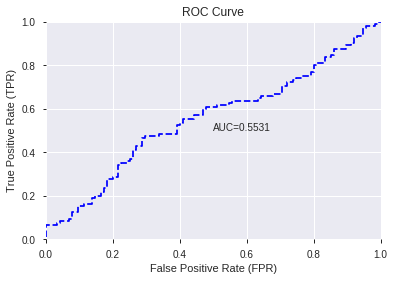

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


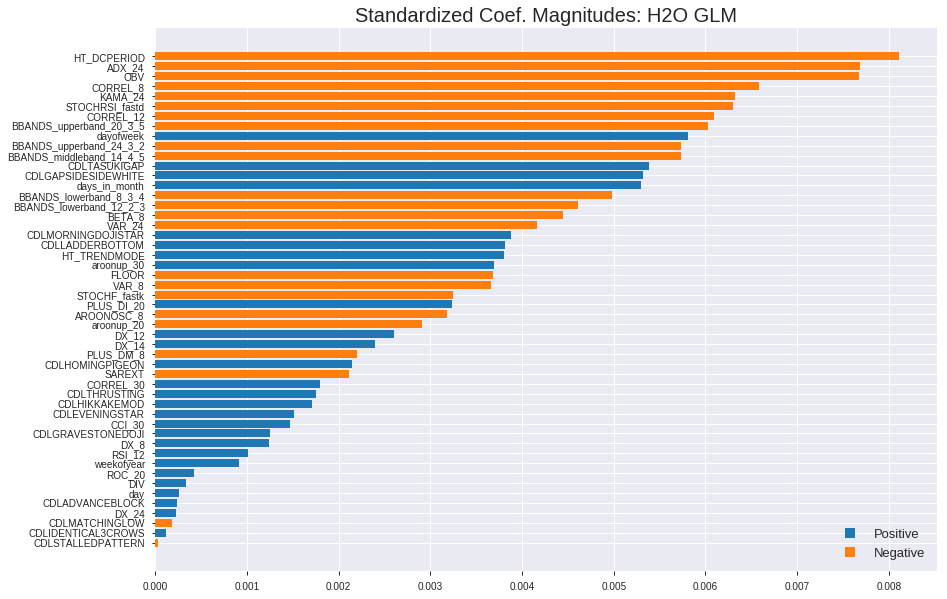

'log_likelihood'
--2019-08-28 17:02:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170201_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170201_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['HT_DCPERIOD',
 'ADX_24',
 'OBV',
 'CORREL_8',
 'KAMA_24',
 'STOCHRSI_fastd',
 'CORREL_12',
 'BBANDS_upperband_20_3_5',
 'dayofweek',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_14_4_5',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_lowerband_12_2_3',
 'BETA_8',
 'VAR_24',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'HT_TRENDMODE',
 'aroonup_30',
 'FLOOR',
 'VAR_8',
 'STOCHF_fastk',
 'PLUS_DI_20',
 'AROONOSC_8',
 'aroonup_20',
 'DX_12',
 'DX_14',
 'PLUS_DM_8',
 'CDLHOMINGPIGEON',
 'SAREXT',
 'CORREL_30',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDLEVENINGSTAR',
 'CCI_30',
 'CDLGRAVESTONEDOJI',
 'DX_8',
 'RSI_12',
 'weekofyear',
 'ROC_20',
 'DIV',
 'day',
 'CDLADVANCEBLOCK',
 'DX_24',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN']

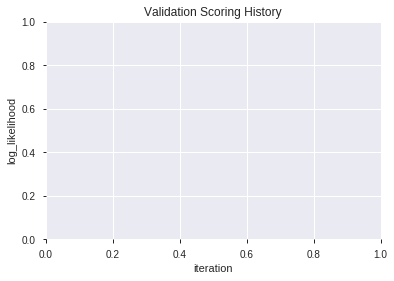

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170217_model_5  0.575155  0.780178              0.435404  0.535384  0.286636
1  XGBoost_grid_1_AutoML_20190828_170217_model_3  0.531346  0.746488              0.474741  0.524047  0.274625
2  XGBoost_grid_1_AutoML_20190828_170217_model_6  0.518427  0.730826              0.500000  0.517601  0.267911
3  XGBoost_grid_1_AutoML_20190828_170217_model_1  0.514907  0.743289              0.435818  0.522544  0.273052
4               XGBoost_3_AutoML_20190828_170217  0.508075  0.731195              0.491304  0.517721  0.268035
5               XGBoost_2_AutoML_20190828_170217  0.496066  0.743468              0.500000  0.523401  0.273948
6  XGBoost_grid_1_AutoML_20190828_170217_model_7  0.493333  0.751076              0.465631  0.525843  0.276511
7               XGBoost_1_AutoML_20190828_170217  0.478509  0.735465              0.479089  0.519637  0.270023
8  XGBoost_grid_1_AutoML_20190828_170217_model_4  0.459130  0.727398              0.500000  0.516474  0.266746
9  XGBoost_grid_1_AutoML_20190828_170217_model_2  0.451511  0.720129              0.469565  0.512964  0.263132

variable  relative_importance  scaled_importance  percentage
0                        DIV          1106.095947           1.000000    0.051817
1               STOCHF_fastk          1024.249268           0.926004    0.047983
2                      VAR_8           986.847046           0.892189    0.046230
3                       DX_8           977.617004           0.883845    0.045798
4             STOCHRSI_fastd           820.598511           0.741887    0.038442
5                        OBV           781.445190           0.706490    0.036608
6     BBANDS_lowerband_8_3_4           770.512146           0.696605    0.036096
7                     VAR_24           770.364014           0.696471    0.036089
8                     ADX_24           754.398376           0.682037    0.035341
9                  PLUS_DM_8           740.043579           0.669059    0.034668
10                    SAREXT           737.885620           0.667108    0.034567
11                    ROC_20           733.305054           0.662967    0.034353
12                 CORREL_30           686.291321           0.620463    0.032150
13                    BETA_8           670.870789           0.606521    0.031428
14                    CCI_30           622.851868           0.563108    0.029178
15                    RSI_12           604.000854           0.546066    0.028295
16                     DX_12           598.910156           0.541463    0.028057
17               HT_DCPERIOD           594.248596           0.537249    0.027838
18                     DX_24           579.384033           0.523810    0.027142
19                       day           556.598450           0.503210    0.026075
20   BBANDS_upperband_20_3_5           555.328979           0.502062    0.026015
21                PLUS_DI_20           498.910919           0.451056    0.023372
22                 CORREL_12           472.337219           0.427031    0.022127
23                AROONOSC_8           452.515808           0.409111    0.021199
24                     DX_14           452.367218           0.408976    0.021192
25   BBANDS_lowerband_12_2_3           452.260345           0.408880    0.021187
26                aroonup_20           448.823090           0.405772    0.021026
27                  CORREL_8           443.640717           0.401087    0.020783
28  BBANDS_middleband_14_4_5           441.089203           0.398780    0.020664
29                   KAMA_24           427.535706           0.386527    0.020029
30                aroonup_30           385.416046           0.348447    0.018055
31   BBANDS_upperband_24_3_2           365.141357           0.330117    0.017106
32                weekofyear           349.975403           0.316406    0.016395
33                 dayofweek           282.895935           0.255761    0.013253
34             days_in_month           108.602402           0.098185    0.005088
35              HT_TRENDMODE            32.487972           0.029372    0.001522
36         CDLGRAVESTONEDOJI            20.113373           0.018184    0.000942
37           CDLADVANCEBLOCK            19.741795           0.017848    0.000925
38            CDLMATCHINGLOW             9.128265           0.008253    0.000428
39           CDLHOMINGPIGEON             5.637185           0.005096    0.000264
40              CDLTHRUSTING             2.086123           0.001886    0.000098
41       CDLGAPSIDESIDEWHITE             1.990879           0.001800    0.000093
42            CDLEVENINGSTAR             1.749516           0.001582    0.000082

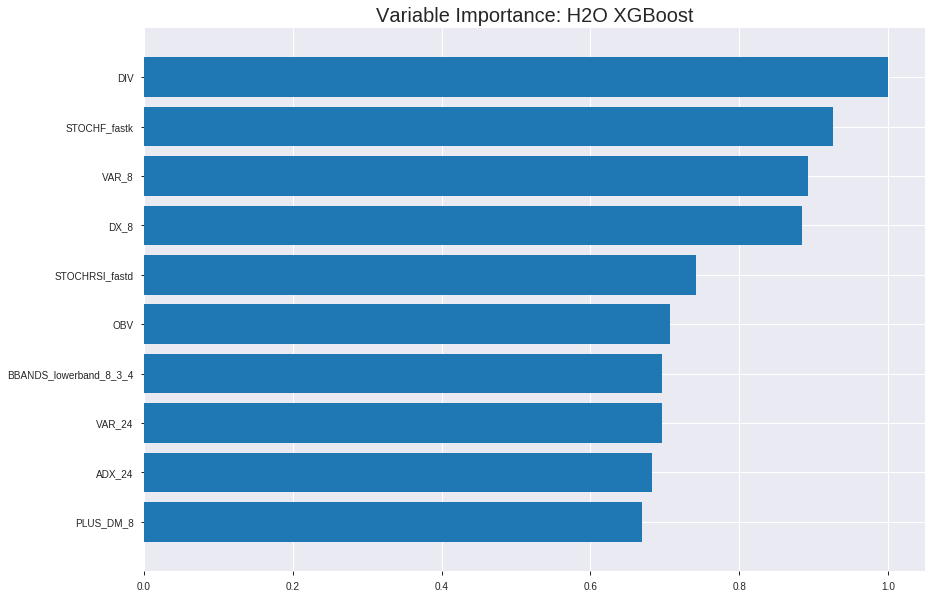

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170217_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.060224053397494405
RMSE: 0.24540589519710893
LogLoss: 0.2717931664084933
Mean Per-Class Error: 0.001280409731113874
AUC: 0.9999940721771707
pr_auc: 0.9987138626527641
Gini: 0.9999881443543415
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5327908396720886: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      755  1    0.0013   (1.0/756.0)
1      1    780  0.0013   (1.0/781.0)
Total  756  781  0.0013   (2.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532791     0.99872   195
max f2                       0.503924     0.999232  197
max f0point5                 0.579231     0.999487  193
max accuracy                 0.579231     0.998699  193
max precision                0.940906     1         0
max recall                   0.503924     1         197
max specificity              0.940906     1         0
max absolute_mcc             0.579231     0.9974    193
max min_per_class_accuracy   0.532791     0.998677  195
max mean_per_class_accuracy  0.579231     0.99872   193

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.898593           1.96799   1.96799            1                0.913709  1                           0.913709            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.887533           1.96799   1.96799            1                0.892697  1                           0.903542            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.875531           1.96799   1.96799            1                0.880655  1                           0.895751            0.0204866       0.0601793                  96.799    96.799
    4        0.0403383                   0.865373           1.96799   1.96799            1                0.869531  1                           0.889407            0.0192061       0.0793854                  96.799    96.799
    5        0.0500976                   0.85644            1.96799   1.96799            1                0.860963  1                           0.883866            0.0192061       0.0985915                  96.799    96.799
    6        0.100195                    0.834714           1.96799   1.96799            1                0.844421  1                           0.864144            0.0985915       0.197183                   96.799    96.799
    7        0.150293                    0.81483            1.96799   1.96799            1                0.824856  1                           0.851048            0.0985915       0.295775                   96.799    96.799
    8        0.20039                     0.793579           1.96799   1.96799            1                0.804123  1                           0.839317            0.0985915       0.394366                   96.799    96.799
    9        0.299935                    0.757616           1.96799   1.96799            1                0.775521  1                           0.818144            0.195903        0.590269                   96.799    96.799
    10       0.40013                     0.704443           1.96799   1.96799            1                0.734336  1                           0.797158            0.197183        0.787452                   96.799    96.799
    11       0.500325                    0.594899           1.96799   1.96799            1                0.663363  1                           0.770364            0.197183        0.984635                   96.799    96.799
    12       0.59987                     0.294896           0.154352  1.66703            0.0784314        0.359803  0.847072                    0.702234            0.0153649       1                          -84.5648  66.7028
    13       0.700065                    0.25356            0         1.42844            0                0.27375   0.725836                    0.640908            0               1                          -100      42.8439
    14       0.79961                     0.213607           0         1.25061            0                0.233108  0.635476                    0.59014             0               1                          -100      25.061
    15       0.899805                    0.176798           0         1.11135            0                0.196634  0.564714                    0.546323            0               1                          -100      11.1352
    16       1                           0.0947968          0         1                  0                0.144962  0.508133                    0.506108            0        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26617204442663944
RMSE: 0.5159186412862394
LogLoss: 0.729072985751069
Mean Per-Class Error: 0.4633229491173416
AUC: 0.5204257528556594
pr_auc: 0.49282606649516697
Gini: 0.04085150571131879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2804359793663025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    214  0        (0.0/214.0)
Total  2    437  0.508    (223.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.280436     0.65745    397
max f2                       0.280436     0.827533   397
max f0point5                 0.441282     0.548425   336
max accuracy                 0.525797     0.53303    252
max precision                0.810852     1          0
max recall                   0.280436     1          397
max specificity              0.810852     1          0
max absolute_mcc             0.525797     0.0766067  252
max min_per_class_accuracy   0.579812     0.518692   193
max mean_per_class_accuracy  0.525797     0.536677   252

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 57.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.782501           0.820561  0.820561           0.4              0.79672   0.4                         0.79672             0.00934579      0.00934579                 -17.9439  -17.9439
    2        0.0205011                   0.76669            1.0257    0.911734           0.5              0.771158  0.444444                    0.785359            0.00934579      0.0186916                  2.57009   -8.82658
    3        0.0318907                   0.762151           1.23084   1.0257             0.6              0.765026  0.5                         0.778097            0.0140187       0.0327103                  23.0841   2.57009
    4        0.0410023                   0.752697           0.51285   0.911734           0.25             0.755065  0.444444                    0.772979            0.0046729       0.0373832                  -48.715   -8.82658
    5        0.0501139                   0.748871           1.53855   1.0257             0.75             0.750495  0.5                         0.768891            0.0140187       0.0514019                  53.8551   2.57009
    6        0.100228                    0.7199             0.745964  0.885833           0.363636         0.733594  0.431818                    0.751243            0.0373832       0.088785                   -25.4036  -11.4167
    7        0.150342                    0.700018           1.21219   0.994619           0.590909         0.709007  0.484848                    0.737164            0.0607477       0.149533                   21.2192   -0.538091
    8        0.200456                    0.679628           1.11895   1.0257             0.545455         0.690479  0.5                         0.725493            0.0560748       0.205607                   11.8946   2.57009
    9        0.300683                    0.647066           0.932455  0.994619           0.454545         0.660689  0.484848                    0.703892            0.0934579       0.299065                   -6.75446  -0.538091
    10       0.400911                    0.612736           1.21219   1.04901            0.590909         0.629163  0.511364                    0.68521             0.121495        0.420561                   21.2192   4.90123
    11       0.501139                    0.573887           1.0257    1.04435            0.5              0.592846  0.509091                    0.666737            0.102804        0.523364                   2.57009   4.435
    12       0.599089                    0.543199           0.95414   1.0296             0.465116         0.558216  0.501901                    0.648994            0.0934579       0.616822                   -4.58596  2.96009
    13       0.699317                    0.509091           0.932455  1.01568            0.454545         0.526124  0.495114                    0.631384            0.0934579       0.71028                    -6.75446  1.56778
    14       0.799544                    0.469535           0.885833  0.999401           0.431818         0.490192  0.487179                    0.613685            0.088785        0.799065                   -11.4167  -0.0599089
    15       0.899772                    0.414591           1.11895   1.01272            0.545455         0.442231  0.493671                    0.594586            0.11215         0.911215                   11.8946   1.27174
    16       1                           0.258053           0.885833  1                  0.431818         0.361794  0.487472                    0.571254


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:02:25  3.445 sec   0                  0.5              0.693147            0.5             0                  1                0.491867                         0.5                0.693147              0.5               0                    1                  0.512528
    2019-08-28 17:02:25  3.789 sec   5                  0.451395         0.599948            0.963879        0.964035           1.96799          0.0995446                        0.504261           0.701791              0.481942          0.473729             0.820561           0.505695
    2019-08-28 17:02:26  4.079 sec   10                 0.410054         0.52625             0.991635        0.989755           1.96799          0.0409889                        0.508051           0.709668              0.473188          0.472838             0.41028            0.507973
    2019-08-28 17:02:26  4.378 sec   15                 0.374345         0.466179            0.998014        0.994228           1.96799          0.0195185                        0.510373           0.714894              0.484258          0.471174             1.23084            0.510251
    2019-08-28 17:02:26  4.663 sec   20                 0.345681         0.419954            0.999471        0.998209           1.96799          0.0117111                        0.512034           0.719015              0.500696          0.477617             0.41028            0.507973
    2019-08-28 17:02:27  4.985 sec   25                 0.317171         0.376079            0.999842        0.99857            1.96799          0.00520494                       0.513889           0.723798              0.505358          0.475663             0.820561           0.512528
    2019-08-28 17:02:27  5.298 sec   30                 0.312256         0.368265            0.999883        0.998608           1.96799          0.00520494                       0.516726           0.731356              0.511028          0.480466             0.820561           0.512528
    2019-08-28 17:02:27  5.620 sec   35                 0.295466         0.342626            0.999956        0.998677           1.96799          0.00390371                       0.517513           0.732622              0.50136           0.471497             0.820561           0.510251
    2019-08-28 17:02:28  5.955 sec   40                 0.278721         0.318536            0.999915        0.99864            1.96799          0.00390371                       0.521503           0.743014              0.507144          0.481996             1.23084            0.507973
    2019-08-28 17:02:28  6.316 sec   45                 0.263078         0.296217            0.999977        0.998697           1.96799          0.000650618                      0.522228           0.744355              0.508349          0.487311             0.41028            0.512528
    2019-08-28 17:02:28  6.712 sec   50                 0.245406         0.271793            0.999994        0.998714           1.96799          0.00130124                       0.515919           0.729073              0.520426          0.492826             0.820561           0.507973

Variable Importances: 


variable             relative_importance    scaled_importance      percentage
-------------------  ---------------------  ---------------------  ----------------------
DIV                  1106.095947265625      1.0                    0.05181676897711087
STOCHF_fastk         1024.249267578125      0.9260039964075153     0.047982535153729626
VAR_8                986.8470458984375      0.8921893695913251     0.04623037044794788
DX_8                 977.6170043945312      0.883844667193017      0.04579797493159201
STOCHRSI_fastd       820.5985107421875      0.7418872772934261     0.03844220165457125
---                  ---                    ---                    ---
CDLMATCHINGLOW       9.128265380859375      0.008252688569581437   0.0004276276570500449
CDLHOMINGPIGEON      5.637185096740723      0.005096470257102364   0.00026408262191099006
CDLTHRUSTING         2.086122512817383      0.0018860231049345015  9.77276235138844e-05
CDLGAPSIDESIDEWHITE  1.9908790588378906     0.0017999153362414301  9.326579715638102e-05
CDLEVENINGSTAR       1.7495160102844238     0.001581703661973805   8.195877324274692e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6526315789473685)

('auc', 0.5751552795031055)

('logloss', 0.7801777963687868)

('mean_per_class_error', 0.4227743271221531)

('rmse', 0.5353838631146597)

('mse', 0.28663588088357667)

xgboost prediction progress: |████████████████████████████████████████████| 100%


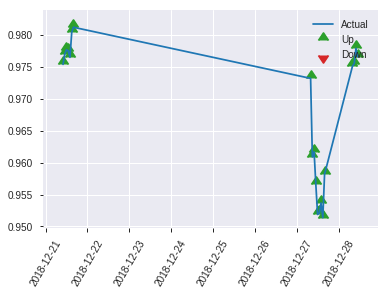


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28663588088357667
RMSE: 0.5353838631146597
LogLoss: 0.7801777963687868
Mean Per-Class Error: 0.4227743271221531
AUC: 0.5751552795031055
pr_auc: 0.5140010651572136
Gini: 0.15031055900621104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5864582061767578: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      28   87   0.7565   (87.0/115.0)
1      12   93   0.1143   (12.0/105.0)
Total  40   180  0.45     (99.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.586458     0.652632  179
max f2                       0.383124     0.822884  217
max f0point5                 0.614547     0.564409  161
max accuracy                 0.660458     0.572727  130
max precision                0.779928     0.615385  38
max recall                   0.383124     1         217
max specificity              0.868556     0.991304  0
max absolute_mcc             0.586458     0.167307  179
max min_per_class_accuracy   0.699694     0.547826  109
max mean_per_class_accuracy  0.660458     0.577226  130

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 67.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.844894           0.698413  0.698413           0.333333         0.855043  0.333333                    0.855043            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.829491           1.04762   0.838095           0.5              0.831676  0.4                         0.845696            0.00952381      0.0190476                  4.7619    -16.1905
    3        0.0318182                   0.824106           1.04762   0.897959           0.5              0.826161  0.428571                    0.840115            0.00952381      0.0285714                  4.7619    -10.2041
    4        0.0409091                   0.820042           0         0.698413           0                0.82241   0.333333                    0.83618             0               0.0285714                  -100      -30.1587
    5        0.05                        0.81933            1.04762   0.761905           0.5              0.819593  0.363636                    0.833165            0.00952381      0.0380952                  4.7619    -23.8095
    6        0.1                         0.802855           1.33333   1.04762            0.636364         0.811936  0.5                         0.82255             0.0666667       0.104762                   33.3333   4.7619
    7        0.15                        0.78814            1.33333   1.14286            0.636364         0.798552  0.545455                    0.814551            0.0666667       0.171429                   33.3333   14.2857
    8        0.2                         0.772268           1.33333   1.19048            0.636364         0.780808  0.568182                    0.806115            0.0666667       0.238095                   33.3333   19.0476
    9        0.3                         0.753166           0.857143  1.07937            0.409091         0.760344  0.515152                    0.790858            0.0857143       0.32381                    -14.2857  7.93651
    10       0.4                         0.725171           1.14286   1.09524            0.545455         0.740267  0.522727                    0.77821             0.114286        0.438095                   14.2857   9.52381
    11       0.5                         0.698076           1.14286   1.10476            0.545455         0.711852  0.527273                    0.764939            0.114286        0.552381                   14.2857   10.4762
    12       0.6                         0.659048           1.2381    1.12698            0.590909         0.679666  0.537879                    0.750727            0.12381         0.67619                    23.8095   12.6984
    13       0.7                         0.621418           0.952381  1.10204            0.454545         0.64309   0.525974                    0.73535             0.0952381       0.771429                   -4.7619   10.2041
    14       0.8                         0.592942           0.857143  1.07143            0.409091         0.608722  0.511364                    0.719521            0.0857143       0.857143                   -14.2857  7.14286
    15       0.9                         0.523268           0.761905  1.03704            0.363636         0.562085  0.494949                    0.702028            0.0761905       0.933333                   -23.8095  3.7037
    16       1                           0.352073           0.666667  1                  0.318182         0.449557  0.477273                    0.676781      

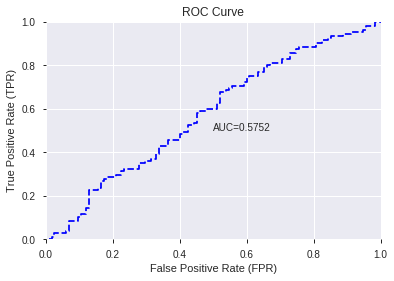

This function is available for GLM models only


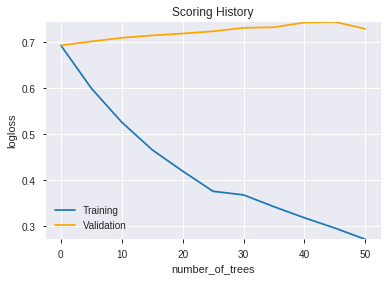

--2019-08-28 17:02:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170217_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170217_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'STOCHF_fastk',
 'VAR_8',
 'DX_8',
 'STOCHRSI_fastd',
 'OBV',
 'BBANDS_lowerband_8_3_4',
 'VAR_24',
 'ADX_24',
 'PLUS_DM_8',
 'SAREXT',
 'ROC_20',
 'CORREL_30',
 'BETA_8',
 'CCI_30',
 'RSI_12',
 'DX_12',
 'HT_DCPERIOD',
 'DX_24',
 'day',
 'BBANDS_upperband_20_3_5',
 'PLUS_DI_20',
 'CORREL_12',
 'AROONOSC_8',
 'DX_14',
 'BBANDS_lowerband_12_2_3',
 'aroonup_20',
 'CORREL_8',
 'BBANDS_middleband_14_4_5',
 'KAMA_24',
 'aroonup_30',
 'BBANDS_upperband_24_3_2',
 'weekofyear',
 'dayofweek',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGSTAR']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 894 924 931] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_170248_model_6  0.564720  0.690802              0.500000  0.498827  0.248828
1  DeepLearning_grid_1_AutoML_20190828_170248_model_1  0.557930  7.887614              0.495652  0.669757  0.448575
2  DeepLearning_grid_1_AutoML_20190828_170248_model_4  0.535114  2.107099              0.491718  0.622594  0.387623
3  DeepLearning_grid_1_AutoML_20190828_170248_model_3  0.528364  1.558250              0.482609  0.599830  0.359796
4  DeepLearning_grid_1_AutoML_20190828_170248_model_2  0.515445  0.906110              0.491304  0.564239  0.318365
5               DeepLearning_1_AutoML_20190828_170248  0.500455  0.692674              0.495652  0.499763  0.249764
6  DeepLearning_grid_1_AutoML_20190828_170248_model_7  0.500000  0.697598              0.500000  0.502183  0.252188
7  DeepLearning_grid_1_AutoML_20190828_170248_model_5  0.500000  0.692208              0.500000  0.499530  0.249531
8  DeepLearning_grid_1_AutoML_20190828_170248_model_9  0.500000  0.692199              0.500000  0.499526  0.249526
9  DeepLearning_grid_1_AutoML_20190828_170248_model_8  0.500000  0.692171              0.500000  0.499512  0.249512

variable  relative_importance  scaled_importance  percentage
0            HT_TRENDMODE             1.000000           1.000000    0.001269
1               CORREL_12             0.950572           0.950572    0.001206
2                  BETA_8             0.944927           0.944927    0.001199
3          STOCHRSI_fastd             0.933734           0.933734    0.001185
4              aroonup_12             0.929830           0.929830    0.001180
...                   ...                  ...                ...         ...
1028              MA_12_7             0.666175           0.666175    0.000845
1029  CDLXSIDEGAP3METHODS             0.662985           0.662985    0.000841
1030          CDLMARUBOZU             0.662484           0.662484    0.000841
1031       CDLHARAMICROSS             0.652917           0.652917    0.000829
1032       CDL3LINESTRIKE             0.641530           0.641530    0.000814

[1033 rows x 4 columns]

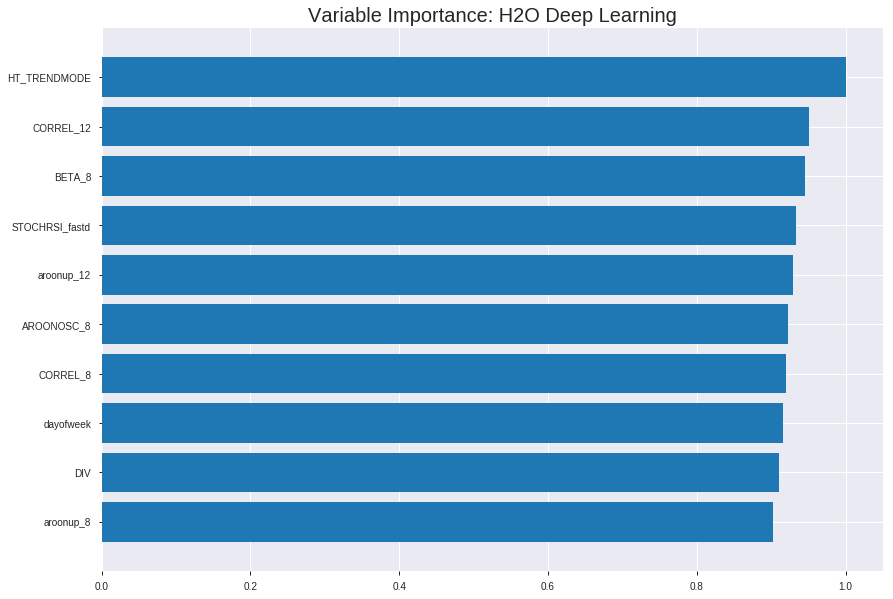

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_170248_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2451721953936278
RMSE: 0.495148659892792
LogLoss: 0.6827931556861859
Mean Per-Class Error: 0.4624861966411262
AUC: 0.5501832544086065
pr_auc: 0.5708422102524665
Gini: 0.10036650881721298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45095010760647414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      57   699   0.9246   (699.0/756.0)
1      19   762   0.0243   (19.0/781.0)
Total  76   1461  0.4671   (718.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45095      0.67975   330
max f2                       0.258205     0.840508  384
max f0point5                 0.465148     0.57776   286
max accuracy                 0.467093     0.543266  275
max precision                0.787642     1         0
max recall                   0.258205     1         384
max specificity              0.787642     1         0
max absolute_mcc             0.506834     0.137786  59
max min_per_class_accuracy   0.487155     0.526455  162
max mean_per_class_accuracy  0.467093     0.537514  275

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.679338           1.84499   1.84499            0.9375           0.731758  0.9375                      0.731758            0.0192061       0.0192061                  84.499     84.499
    2        0.0201692                   0.562771           1.70559   1.77754            0.866667         0.602299  0.903226                    0.669116            0.0166453       0.0358515                  70.5591    77.7539
    3        0.0305791                   0.519334           1.47599   1.67488            0.75             0.53759   0.851064                    0.624341            0.0153649       0.0512164                  47.5992    67.4885
    4        0.0403383                   0.507847           1.57439   1.65057            0.8              0.51324   0.83871                     0.597462            0.0153649       0.0665813                  57.4392    65.0572
    5        0.0500976                   0.502309           0.524797  1.43127            0.266667         0.504858  0.727273                    0.579422            0.00512164      0.0717029                  -47.5203   43.1265
    6        0.100195                    0.498076           1.02233   1.2268             0.519481         0.49936   0.623377                    0.539391            0.0512164       0.122919                   2.23323    22.6799
    7        0.150293                    0.496704           1.04789   1.16716            0.532468         0.497276  0.593074                    0.525353            0.0524968       0.175416                   4.78906    16.7163
    8        0.20039                     0.494991           0.945657  1.11179            0.480519         0.495918  0.564935                    0.517994            0.0473752       0.222791                   -5.43426   11.1786
    9        0.299935                    0.492482           1.00329   1.07578            0.509804         0.49367   0.546638                    0.509921            0.099872        0.322663                   0.32889    7.57775
    10       0.40013                     0.489077           0.996774  1.05599            0.506494         0.490716  0.536585                    0.505112            0.099872        0.422535                   -0.322597  5.59945
    11       0.500325                    0.487178           1.06067   1.05693            0.538961         0.488221  0.537061                    0.501729            0.106274        0.528809                   6.06698    5.69308
    12       0.59987                     0.481885           1.00329   1.04803            0.509804         0.484638  0.532538                    0.498893            0.099872        0.628681                   0.32889    4.80293
    13       0.700065                    0.477075           0.971216  1.03704            0.493506         0.479363  0.526952                    0.496098            0.0973111       0.725992                   -2.87843   3.70355
    14       0.79961                     0.471635           1.05474   1.03924            0.535948         0.47434   0.528072                    0.493389            0.104994        0.830986                   5.47396    3.92395
    15       0.899805                    0.46263            1.00955   1.03593            0.512987         0.467457  0.526392                    0.490502            0.101152        0.932138                   0.955319   3.59339
    16       1                           0.147639           0.677295  1                  0.344156         0.407693  0.508133                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24977859292440435
RMSE: 0.499778543881592
LogLoss: 0.6927037598203601
Mean Per-Class Error: 0.4627102803738318
AUC: 0.5281516095534787
pr_auc: 0.5027488984538213
Gini: 0.05630321910695746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4535932171380389: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    214  0        (0.0/214.0)
Total  1    438  0.5103   (224.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.453593     0.656442   398
max f2                       0.453593     0.826893   398
max f0point5                 0.46698      0.546968   334
max accuracy                 0.47867      0.539863   136
max precision                0.492851     0.565217   21
max recall                   0.453593     1          398
max specificity              0.514445     0.995556   0
max absolute_mcc             0.476986     0.0762114  161
max min_per_class_accuracy   0.474674     0.518692   202
max mean_per_class_accuracy  0.476986     0.53729    161

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 47.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.506142           0.41028   0.41028            0.2              0.509379  0.2                         0.509379            0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   0.498634           1.0257    0.683801           0.5              0.503829  0.333333                    0.506912            0.00934579      0.0140187                  2.57009   -31.6199
    3        0.0318907                   0.494929           1.23084   0.879172           0.6              0.496221  0.428571                    0.503094            0.0140187       0.0280374                  23.0841   -12.0828
    4        0.0410023                   0.493702           1.53855   1.0257             0.75             0.494338  0.5                         0.501148            0.0140187       0.0420561                  53.8551   2.57009
    5        0.0501139                   0.492853           1.53855   1.11895            0.75             0.493309  0.545455                    0.499723            0.0140187       0.0560748                  53.8551   11.8946
    6        0.100228                    0.487607           1.0257    1.07232            0.5              0.48936   0.522727                    0.494541            0.0514019       0.107477                   2.57009   7.23237
    7        0.150342                    0.484556           0.83921   0.994619           0.409091         0.486691  0.484848                    0.491925            0.0420561       0.149533                   -16.079   -0.538091
    8        0.200456                    0.483142           1.39868   1.09564            0.681818         0.483808  0.534091                    0.489895            0.0700935       0.219626                   39.8683   9.56351
    9        0.300683                    0.479617           0.979078  1.05678            0.477273         0.481356  0.515152                    0.487049            0.0981308       0.317757                   -2.09218  5.67828
    10       0.400911                    0.476874           1.16557   1.08398            0.568182         0.478209  0.528409                    0.484839            0.116822        0.434579                   16.5569   8.39794
    11       0.501139                    0.474626           0.83921   1.03503            0.409091         0.475665  0.504545                    0.483004            0.0841121       0.518692                   -16.079   3.50255
    12       0.599089                    0.472592           1.09726   1.0452             0.534884         0.473562  0.509506                    0.48146             0.107477        0.626168                   9.72615   4.5201
    13       0.699317                    0.470771           0.792587  1.009              0.386364         0.471715  0.491857                    0.480063            0.0794393       0.705607                   -20.7413  0.899571
    14       0.799544                    0.46834            1.16557   1.02862            0.568182         0.469756  0.501425                    0.478771            0.116822        0.82243                    16.5569   2.86232
    15       0.899772                    0.465362           0.83921   1.00752            0.409091         0.466575  0.491139                    0.477413            0.0841121       0.906542                   -16.079   0.752396
    16       1                           0.453166           0.932455  1                  0.454545         0.461445  0.487472                    0.475812    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:12:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:12:36  5 min 25.792 sec  358 obs/sec       0.377358  1             580        0.662058         3.24495             -0.75375       0.513561        0.387061           1.22999          0.480807                         0.701641           5.98508               -0.97044         0.51109           0.41907              1.23084            0.507973
    2019-08-28 17:12:58  5 min 47.596 sec  464 obs/sec       6.43787   17            9895       0.498198         0.689283            0.00693066     0.543           0.55262            1.35299          0.472349                         0.504847           0.702978              -0.0201236       0.496843          0.493759             0.820561           0.501139
    2019-08-28 17:13:19  6 min  9.434 sec  480 obs/sec       12.8269   34            19715      0.494148         0.681087            0.0230139      0.577461        0.599615           1.72199          0.477554                         0.507592           0.708628              -0.0312475       0.502274          0.51389              1.23084            0.510251
    2019-08-28 17:13:41  6 min 30.607 sec  509 obs/sec       19.9421   53            30651      0.495149         0.682793            0.0190517      0.550183        0.570842           1.84499          0.467144                         0.499779           0.692704              0.00025794       0.528152          0.502749             0.41028            0.510251
    2019-08-28 17:14:02  6 min 51.771 sec  532 obs/sec       27.4808   73            42238      0.49171          0.675487            0.0326287      0.586021        0.608605           1.84499          0.469746                         0.503098           0.699384              -0.0130666       0.487653          0.486149             0.820561           0.505695
    2019-08-28 17:14:23  7 min 12.753 sec  554 obs/sec       35.419    94            54439      0.491087         0.673558            0.0350773      0.571395        0.634739           1.84499          0.460638                         0.502317           0.697835              -0.0099246       0.495929          0.440353             0.41028            0.507973
    2019-08-28 17:14:44  7 min 33.996 sec  572 obs/sec       43.7417   116           67231      0.493415         0.677348            0.0259079      0.554694        0.595888           1.84499          0.47365                          0.506574           0.707117              -0.0271122       0.499148          0.485271             0.820561           0.512528
    2019-08-28 17:14:46  7 min 36.103 sec  572 obs/sec       43.7417   116           67231      0.495149         0.682793            0.0190517      0.550183        0.570842           1.84499          0.467144                         0.499779           0.692704              0.00025794       0.528152          0.502749             0.41028            0.510251

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE         1.0                    1.0                  0.0012689953924354578
CORREL_12            0.9505717158317566     0.9505717158317566   0.0012062711275699664
BETA_8               0.9449271559715271     0.9449271559715271   0.001199108207115009
STOCHRSI_fastd       0.9337337613105774     0.9337337613105774   0.0011849038408645522
aroonup_12           0.9298303127288818     0.9298303127288818   0.0011799503825997719
---                  ---                    ---                  ---
MA_12_7              0.6661754250526428     0.6661754250526428   0.0008453735449455364
CDLXSIDEGAP3METHODS  0.6629846692085266     0.6629846692085266   0.0008413244904809663
CDLMARUBOZU          0.662483811378479      0.662483811378479    0.0008406889042023708
CDLHARAMICROSS       0.6529168486595154     0.6529168486595154   0.000828548472592404
CDL3LINESTRIKE       0.6415302753448486     0.6415302753448486   0.0008140989635204635


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6461538461538462)

('auc', 0.5647204968944098)

('logloss', 0.6908016271115077)

('mean_per_class_error', 0.42919254658385086)

('rmse', 0.49882687243727475)

('mse', 0.24882824866555317)

deeplearning prediction progress: |███████████████████████████████████████| 100%


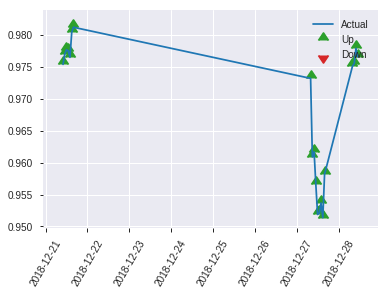


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24882824866555317
RMSE: 0.49882687243727475
LogLoss: 0.6908016271115077
Mean Per-Class Error: 0.42919254658385086
AUC: 0.5647204968944098
pr_auc: 0.49478347398368255
Gini: 0.12944099378881968
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.459732611904134: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    105  0        (0.0/105.0)
Total  0    220  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459733     0.646154  206
max f2                       0.459733     0.820313  206
max f0point5                 0.476801     0.556492  108
max accuracy                 0.483796     0.581818  21
max precision                0.486517     0.772727  8
max recall                   0.459733     1         206
max specificity              0.48819      0.965217  0
max absolute_mcc             0.486517     0.197173  8
max min_per_class_accuracy   0.477952     0.542857  95
max mean_per_class_accuracy  0.476801     0.570807  108

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0636364                   0.48819            1.4966    1.4966             0.714286         0.48819   0.714286                    0.48819             0.0952381       0.0952381                  49.6599   49.6599
    2        0.1                         0.48594            1.83333   1.61905            0.875            0.487031  0.772727                    0.487768            0.0666667       0.161905                   83.3333   61.9048
    3        0.15                        0.484106           0.952381  1.39683            0.454545         0.485174  0.666667                    0.486903            0.047619        0.209524                   -4.7619   39.6825
    4        0.2                         0.483463           0.952381  1.28571            0.454545         0.483667  0.613636                    0.486094            0.047619        0.257143                   -4.7619   28.5714
    5        0.3                         0.481652           0.952381  1.1746             0.454545         0.482554  0.560606                    0.484914            0.0952381       0.352381                   -4.7619   17.4603
    6        0.4                         0.479456           1.04762   1.14286            0.5              0.480441  0.545455                    0.483796            0.104762        0.457143                   4.7619    14.2857
    7        0.5                         0.477918           0.857143  1.08571            0.409091         0.478663  0.518182                    0.482769            0.0857143       0.542857                   -14.2857  8.57143
    8        0.6                         0.475907           1.14286   1.09524            0.545455         0.476895  0.522727                    0.48179             0.114286        0.657143                   14.2857   9.52381
    9        0.7                         0.473393           0.761905  1.04762            0.363636         0.474811  0.5                         0.480793            0.0761905       0.733333                   -23.8095  4.7619
    10       0.8                         0.470711           0.666667  1                  0.318182         0.472062  0.477273                    0.479702            0.0666667       0.8                        -33.3333  0
    11       0.9                         0.467492           0.952381  0.994709           0.454545         0.468791  0.474747                    0.47849             0.0952381       0.895238                   -4.7619   -0.529101
    12       1                           0.459733           1.04762   1                  0.5              0.465544  0.477273                    0.477195            0.104762        1                          4.7619    0

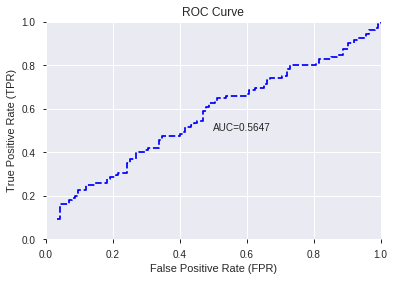

This function is available for GLM models only


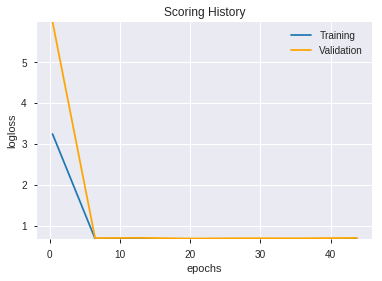

--2019-08-28 17:25:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_170248_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_170248_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'CORREL_12',
 'BETA_8',
 'STOCHRSI_fastd',
 'aroonup_12',
 'AROONOSC_8',
 'CORREL_8',
 'dayofweek',
 'DIV',
 'aroonup_8',
 'DX_20',
 'STOCHF_fastd',
 'AROONOSC_14',
 'ADX_24',
 'days_in_month',
 'TRANGE',
 'ADXR_14',
 'aroondown_8',
 'AROONOSC_12',
 'ADX_14',
 'DX_30',
 'OBV',
 'HT_DCPERIOD',
 'week',
 'DX_8',
 'SAREXT',
 'aroonup_14',
 'aroondown_14',
 'VAR_12',
 'MACD_hist',
 'STOCHRSI_fastk',
 'MFI_24',
 'CCI_8',
 'ADX_20',
 'STOCH_slowk',
 'AD',
 'CORREL_30',
 'WILLR_8',
 'ADX_12',
 'BETA_20',
 'MACDFIX_hist_24',
 'aroondown_12',
 'DX_24',
 'MACDEXT_hist',
 'aroonup_30',
 'DX_14',
 'BETA_24',
 'hour',
 'AROONOSC_30',
 'MFI_12',
 'CDLMORNINGSTAR',
 'ADXR_8',
 'MACDFIX_hist_14',
 'ADX_8',
 'STOCHF_fastk',
 'month',
 'BETA_14',
 'ATR_14',
 'NATR_24',
 'aroondown_30',
 'DX_12',
 'MFI_30',
 'SUB',
 'VAR_8',
 'weekday_name',
 'dayofyear',
 'STDDEV_14',
 'CDLHOMINGPIGEON',
 'BOP',
 'Volume',
 'MACDFIX_signal_24',
 'BETA_30',
 'aroondown_20',
 'CORREL_14',
 'MACDFIX_hist_

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_172543_model_1  0.561573  0.721995              0.491304  0.513928  0.264122

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         7.266197e-03           1.000000  1.086430e-02
1               is_month_start         6.033485e-03           0.830350  9.021169e-03
2                  CDLLONGLINE         5.651484e-03           0.777777  8.450008e-03
3                    dayofweek         5.490701e-03           0.755650  8.209606e-03
4                      weekday         5.476715e-03           0.753725  8.188696e-03
...                        ...                  ...                ...           ...
1028    LINEARREG_INTERCEPT_20         1.289233e-06           0.000177  1.927640e-06
1029  BBANDS_middleband_20_0_2         1.148936e-06           0.000158  1.717871e-06
1030                    T3_8_4         1.043300e-06           0.000144  1.559925e-06
1031  BBANDS_middleband_30_0_3         1.979572e-07           0.000027  2.959824e-07
1032   BBANDS_upperband_20_5_2         3.105730e-08           0.000004  4.643637e-08

[1033 rows x 4 columns]

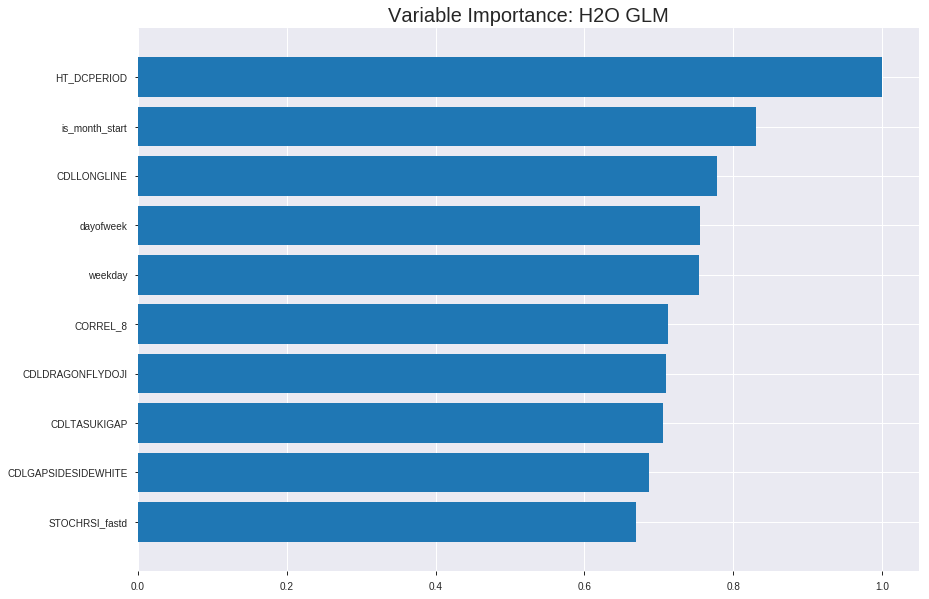

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_172543_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24659203645433997
RMSE: 0.49658034239621285
LogLoss: 0.6863027951515056
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2130.327778804599
Residual deviance: 2109.694792295728
AIC: 4177.694792295728
AUC: 0.57236516743559
pr_auc: 0.5724971900095452
Gini: 0.14473033487117992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4459042188397723: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   708   0.9365   (708.0/756.0)
1      21   760   0.0269   (21.0/781.0)
Total  69   1468  0.4743   (729.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445904     0.675856  368
max f2                       0.420483     0.838343  396
max f0point5                 0.491629     0.582872  247
max accuracy                 0.491629     0.565387  247
max precision                0.639993     1         0
max recall                   0.420483     1         396
max specificity              0.639993     1         0
max absolute_mcc             0.491629     0.132988  247
max min_per_class_accuracy   0.510357     0.553137  191
max mean_per_class_accuracy  0.506595     0.564166  203

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.573863           1.59899   1.59899            0.8125           0.583895  0.8125                      0.583895            0.0166453       0.0166453                  59.8992   59.8992
    2        0.0201692                   0.567789           0.918395  1.26967            0.466667         0.570723  0.645161                    0.577521            0.00896287      0.0256082                  -8.16048  26.9671
    3        0.0305791                   0.565318           1.10699   1.21429            0.5625           0.566357  0.617021                    0.573721            0.0115237       0.0371319                  10.6994   21.4292
    4        0.0403383                   0.562678           1.44319   1.26967            0.733333         0.563998  0.645161                    0.571368            0.0140845       0.0512164                  44.3192   26.9671
    5        0.0500976                   0.560684           1.57439   1.32903            0.8              0.56157   0.675325                    0.56946             0.0153649       0.0665813                  57.4392   32.9032
    6        0.100195                    0.552765           1.02233   1.17568            0.519481         0.556593  0.597403                    0.563026            0.0512164       0.117798                   2.23323   17.5682
    7        0.150293                    0.546064           1.2268    1.19272            0.623377         0.549392  0.606061                    0.558482            0.0614597       0.179257                   22.6799   19.2721
    8        0.20039                     0.540809           1.20124   1.19485            0.61039          0.543184  0.607143                    0.554657            0.0601793       0.239437                   20.1241   19.4851
    9        0.299935                    0.53204            1.01615   1.13554            0.51634          0.535952  0.577007                    0.548449            0.101152        0.340589                   1.61516   13.5543
    10       0.40013                     0.52074            0.932878  1.08479            0.474026         0.526964  0.55122                     0.543069            0.0934699       0.434059                   -6.71217  8.47944
    11       0.500325                    0.510221           1.18846   1.10555            0.603896         0.514999  0.561769                    0.537448            0.119078        0.553137                   18.8461   10.5555
    12       0.59987                     0.499237           1.04188   1.09499            0.529412         0.504675  0.556399                    0.532009            0.103713        0.65685                    4.18769   9.49878
    13       0.700065                    0.488077           0.932878  1.07179            0.474026         0.493233  0.54461                     0.52646             0.0934699       0.75032                    -6.71217  7.17862
    14       0.79961                     0.475855           0.810349  1.03924            0.411765         0.482603  0.528072                    0.521               0.0806658       0.830986                   -18.9651  3.92395
    15       0.899805                    0.45884            0.945657  1.02882            0.480519         0.468425  0.522777                    0.515146            0.0947503       0.925736                   -5.43426  2.88189
    16       1                           0.412352           0.741191  1                  0.376623         0.445153  0.508133                    0.508133         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2547398442588818
RMSE: 0.504717588616527
LogLoss: 0.7027125671268538
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 609.0572554147116
Residual deviance: 616.9816339373776
AIC: 2684.9816339373774
AUC: 0.5177881619937694
pr_auc: 0.5175329818079271
Gini: 0.03557632398753885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5050184824044972: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    214  0        (0.0/214.0)
Total  0    439  0.5125   (225.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.505018     0.655436   399
max f2                       0.505018     0.826255   399
max f0point5                 0.505018     0.543147   399
max accuracy                 0.592654     0.537585   44
max precision                0.651312     1          0
max recall                   0.505018     1          399
max specificity              0.651312     1          0
max absolute_mcc             0.646956     0.0983263  3
max min_per_class_accuracy   0.555554     0.511111   202
max mean_per_class_accuracy  0.592654     0.527643   44

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 56.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.644433           1.64112   1.64112            0.8              0.647857  0.8                         0.647857            0.0186916       0.0186916                  64.1121   64.1121
    2        0.0205011                   0.639275           1.53855   1.59553            0.75             0.641658  0.777778                    0.645102            0.0140187       0.0327103                  53.8551   59.5535
    3        0.0318907                   0.636015           0.820561  1.31876            0.4              0.637822  0.642857                    0.642502            0.00934579      0.0420561                  -17.9439  31.8758
    4        0.0410023                   0.629947           0.51285   1.13967            0.25             0.632166  0.555556                    0.640205            0.0046729       0.046729                   -48.715   13.9668
    5        0.0501139                   0.625185           1.0257    1.11895            0.5              0.628066  0.545455                    0.637998            0.00934579      0.0560748                  2.57009   11.8946
    6        0.100228                    0.592737           1.39868   1.25881            0.681818         0.611504  0.613636                    0.624751            0.0700935       0.126168                   39.8683   25.8815
    7        0.150342                    0.585135           0.83921   1.11895            0.409091         0.588605  0.545455                    0.612702            0.0420561       0.168224                   -16.079   11.8946
    8        0.200456                    0.578712           0.83921   1.04901            0.409091         0.581737  0.511364                    0.604961            0.0420561       0.21028                    -16.079   4.90123
    9        0.300683                    0.571332           0.932455  1.01016            0.454545         0.574374  0.492424                    0.594765            0.0934579       0.303738                   -6.75446  1.016
    10       0.400911                    0.562945           1.16557   1.04901            0.568182         0.56745   0.511364                    0.587937            0.116822        0.420561                   16.5569   4.90123
    11       0.501139                    0.555554           0.932455  1.0257             0.454545         0.55922   0.5                         0.582193            0.0934579       0.514019                   -6.75446  2.57009
    12       0.599089                    0.550975           1.00185   1.0218             0.488372         0.553343  0.498099                    0.577476            0.0981308       0.61215                    0.184742  2.18009
    13       0.699317                    0.544801           0.979078  1.01568            0.477273         0.547733  0.495114                    0.573213            0.0981308       0.71028                    -2.09218  1.56778
    14       0.799544                    0.537793           1.0257    1.01693            0.5              0.541657  0.495726                    0.569258            0.102804        0.813084                   2.57009   1.69343
    15       0.899772                    0.528917           0.83921   0.997137           0.409091         0.533435  0.486076                    0.565267            0.0841121       0.897196                   -16.079   -0.286289
    16       1                           0.505016           1.0257    1                  0.5              0.520019  0.487472                    0.560732         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:25:46  0.000 sec   2            3.1       1034          1.37261           1.40543
    2019-08-28 17:25:48  1.912 sec   4            2.2       1034          1.37023           1.4075
    2019-08-28 17:25:50  3.808 sec   6            1.6       1034          1.36738           1.41049
    2019-08-28 17:25:52  5.720 sec   8            1.2       1034          1.36401           1.4146
    2019-08-28 17:25:54  7.605 sec   10           0.86      1034          1.36007           1.41997

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5954545454545455)

('F1', 0.6501547987616099)

('auc', 0.5615734989648034)

('logloss', 0.7219952314131329)

('mean_per_class_error', 0.4084886128364389)

('rmse', 0.5139281398614907)

('mse', 0.26412213294149195)

glm prediction progress: |████████████████████████████████████████████████| 100%


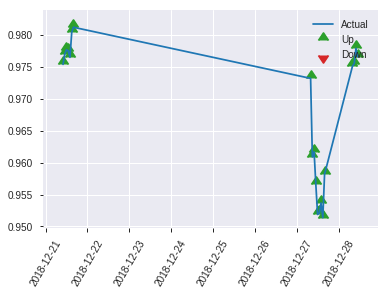


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.26412213294149195
RMSE: 0.5139281398614907
LogLoss: 0.7219952314131329
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 305.36830916935537
Residual deviance: 317.67790182177856
AIC: 2385.6779018217785
AUC: 0.5615734989648034
pr_auc: 0.5474532888689141
Gini: 0.1231469979296067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.554760178873468: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    105  0        (0.0/105.0)
Total  2    218  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55476      0.650155  217
max f2                       0.55476      0.822884  217
max f0point5                 0.619816     0.569892  89
max accuracy                 0.641264     0.595455  51
max precision                0.692535     1         0
max recall                   0.55476      1         217
max specificity              0.692535     1         0
max absolute_mcc             0.641264     0.196676  51
max min_per_class_accuracy   0.603817     0.561905  107
max mean_per_class_accuracy  0.619816     0.591511  89

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 61.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.666173           0.698413  0.698413           0.333333         0.679784  0.333333                    0.679784            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.664821           2.09524   1.25714            1                0.665333  0.6                         0.674003            0.0190476       0.0285714                  109.524   25.7143
    3        0.0318182                   0.66417            1.04762   1.19728            0.5              0.664423  0.571429                    0.671266            0.00952381      0.0380952                  4.7619    19.7279
    4        0.0409091                   0.662623           2.09524   1.39683            1                0.663611  0.666667                    0.669565            0.0190476       0.0571429                  109.524   39.6825
    5        0.05                        0.660045           1.04762   1.33333            0.5              0.662465  0.636364                    0.668274            0.00952381      0.0666667                  4.7619    33.3333
    6        0.1                         0.655793           1.14286   1.2381             0.545455         0.657662  0.590909                    0.662968            0.0571429       0.12381                    14.2857   23.8095
    7        0.15                        0.65224            1.52381   1.33333            0.727273         0.654406  0.636364                    0.660114            0.0761905       0.2                        52.381    33.3333
    8        0.2                         0.644606           1.33333   1.33333            0.636364         0.648273  0.636364                    0.657154            0.0666667       0.266667                   33.3333   33.3333
    9        0.3                         0.635847           0.952381  1.20635            0.454545         0.640202  0.575758                    0.651503            0.0952381       0.361905                   -4.7619   20.6349
    10       0.4                         0.621133           1.2381    1.21429            0.590909         0.629763  0.579545                    0.646068            0.12381         0.485714                   23.8095   21.4286
    11       0.5                         0.60121            0.761905  1.12381            0.363636         0.610556  0.536364                    0.638966            0.0761905       0.561905                   -23.8095  12.381
    12       0.6                         0.592664           0.761905  1.06349            0.363636         0.597482  0.507576                    0.632052            0.0761905       0.638095                   -23.8095  6.34921
    13       0.7                         0.584714           0.571429  0.993197           0.272727         0.588347  0.474026                    0.625808            0.0571429       0.695238                   -42.8571  -0.680272
    14       0.8                         0.580612           0.761905  0.964286           0.363636         0.582981  0.460227                    0.620455            0.0761905       0.771429                   -23.8095  -3.57143
    15       0.9                         0.570044           1.14286   0.984127           0.545455         0.575514  0.469697                    0.615462            0.114286        0.885714                   14.2857   -1.5873
    16       1                           0.550944           1.14286   1                  0.545455         0.561     0.477273                    0.610015      

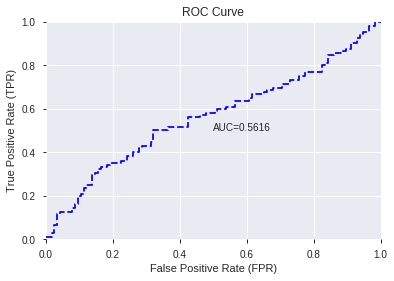

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


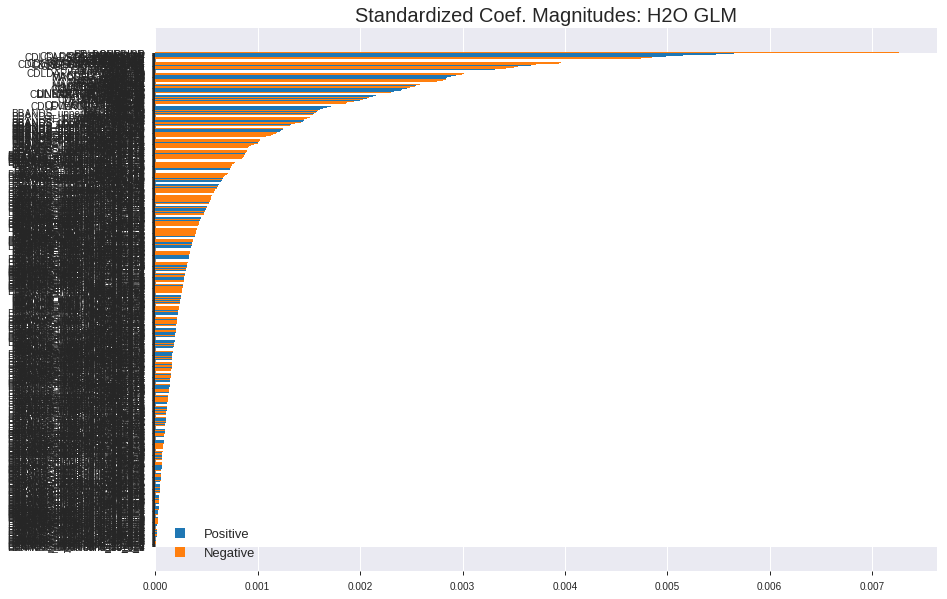

'log_likelihood'
--2019-08-28 17:26:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_172543_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_172543_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['HT_DCPERIOD',
 'is_month_start',
 'CDLLONGLINE',
 'dayofweek',
 'weekday',
 'CORREL_8',
 'CDLDRAGONFLYDOJI',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'STOCHRSI_fastd',
 'ADX_24',
 'CORREL_12',
 'ADXR_14',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'days_in_month',
 'CDLMORNINGSTAR',
 'ADX_20',
 'OBV',
 'CDLMORNINGDOJISTAR',
 'BETA_8',
 'CDLXSIDEGAP3METHODS',
 'CDLRICKSHAWMAN',
 'MFI_24',
 'CDLSEPARATINGLINES',
 'ADXR_12',
 'CDLLADDERBOTTOM',
 'ATR_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'ATR_24',
 'aroonup_20',
 'MFI_20',
 'ATR_20',
 'CDLHIGHWAVE',
 'aroondown_24',
 'DX_14',
 'DX_12',
 'NATR_30',
 'NATR_24',
 'CDLDARKCLOUDCOVER',
 'NATR_20',
 'MFI_14',
 'STOCHRSI_fastk',
 'CEIL',
 'FLOOR',
 'CORREL_20',
 'MACDFIX_signal_24',
 'ATR_14',
 'MACDFIX_signal_20',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'AROONOSC_24',
 'STOCH_slowd',
 'MFI_12',
 'MACDFIX_hist_8',
 'STOCHF_fastk',
 'MACD_hist',
 'CDLHAMMER',
 'MACDFIX_signal_14',
 'WILLR_8',
 'NATR_14',
 'AROONOSC_

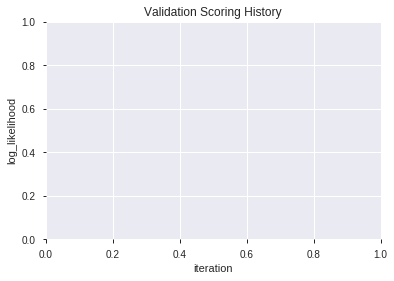

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_172629_model_5  0.567205  0.834891              0.478675  0.553194  0.306024
1               XGBoost_3_AutoML_20190828_172629  0.565466  0.777273              0.495652  0.535805  0.287087
2  XGBoost_grid_1_AutoML_20190828_172629_model_6  0.560828  0.743905              0.491304  0.522334  0.272833
3  XGBoost_grid_1_AutoML_20190828_172629_model_3  0.555445  0.796903              0.478675  0.542130  0.293904
4               XGBoost_1_AutoML_20190828_172629  0.551553  0.772719              0.435404  0.533581  0.284709
5  XGBoost_grid_1_AutoML_20190828_172629_model_1  0.528530  0.843982              0.500000  0.555805  0.308919
6               XGBoost_2_AutoML_20190828_172629  0.521739  0.756159              0.500000  0.528174  0.278968
7  XGBoost_grid_1_AutoML_20190828_172629_model_7  0.514203  0.810634              0.482609  0.546764  0.298950
8  XGBoost_grid_1_AutoML_20190828_172629_model_2  0.512961  0.719854              0.478675  0.512701  0.262862
9  XGBoost_grid_1_AutoML_20190828_172629_model_4  0.484141  0.728190              0.500000  0.516511  0.266784

variable  relative_importance  scaled_importance  percentage
0                     Volume           421.527649           1.000000    0.020277
1                       Open           357.675415           0.848522    0.017206
2             STOCHRSI_fastd           296.782013           0.704063    0.014276
3                       High           240.265564           0.569988    0.011558
4                        BOP           236.893600           0.561988    0.011396
..                       ...                  ...                ...         ...
625   BBANDS_upperband_8_2_4             1.106201           0.002624    0.000053
626                MACD_hist             1.086809           0.002578    0.000052
627                   T3_8_6             1.011282           0.002399    0.000049
628  BBANDS_upperband_24_3_2             0.965302           0.002290    0.000046
629   BBANDS_lowerband_8_8_2             0.884020           0.002097    0.000043

[630 rows x 4 columns]

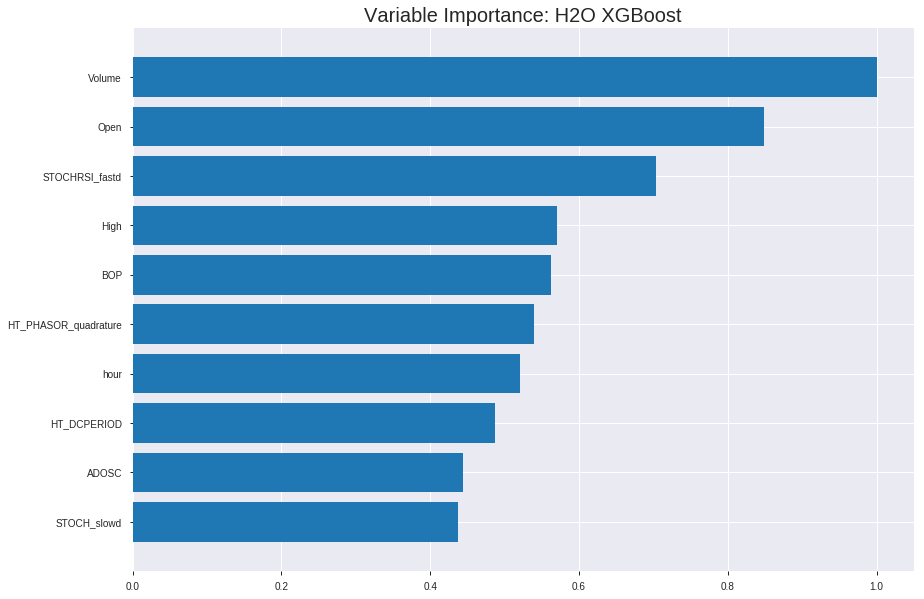

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_172629_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04424948677007401
RMSE: 0.21035561977297876
LogLoss: 0.22554413522184516
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.998719590268886
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5708634853363037: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      756  0    0        (0.0/756.0)
1      0    781  0        (0.0/781.0)
Total  756  781  0        (0.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.570863     1        202
max f2                       0.570863     1        202
max f0point5                 0.570863     1        202
max accuracy                 0.570863     1        202
max precision                0.941133     1        0
max recall                   0.570863     1        202
max specificity              0.941133     1        0
max absolute_mcc             0.570863     1        202
max min_per_class_accuracy   0.570863     1        202
max mean_per_class_accuracy  0.570863     1        202

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.917624           1.96799   1.96799            1                0.928809  1                           0.928809            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.902415           1.96799   1.96799            1                0.908857  1                           0.919155            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.897432           1.96799   1.96799            1                0.899423  1                           0.912437            0.0204866       0.0601793                  96.799    96.799
    4        0.0403383                   0.89089            1.96799   1.96799            1                0.894346  1                           0.908061            0.0192061       0.0793854                  96.799    96.799
    5        0.0500976                   0.883906           1.96799   1.96799            1                0.886736  1                           0.903906            0.0192061       0.0985915                  96.799    96.799
    6        0.100195                    0.866538           1.96799   1.96799            1                0.874609  1                           0.889258            0.0985915       0.197183                   96.799    96.799
    7        0.150293                    0.848415           1.96799   1.96799            1                0.857022  1                           0.878513            0.0985915       0.295775                   96.799    96.799
    8        0.20039                     0.833792           1.96799   1.96799            1                0.840772  1                           0.869078            0.0985915       0.394366                   96.799    96.799
    9        0.299935                    0.795782           1.96799   1.96799            1                0.814874  1                           0.851088            0.195903        0.590269                   96.799    96.799
    10       0.40013                     0.747662           1.96799   1.96799            1                0.773339  1                           0.831619            0.197183        0.787452                   96.799    96.799
    11       0.500325                    0.635744           1.96799   1.96799            1                0.707246  1                           0.806712            0.197183        0.984635                   96.799    96.799
    12       0.59987                     0.26139            0.154352  1.66703            0.0784314        0.333864  0.847072                    0.728246            0.0153649       1                          -84.5648  66.7028
    13       0.700065                    0.212234           0         1.42844            0                0.234084  0.725836                    0.65752             0               1                          -100      42.8439
    14       0.79961                     0.176371           0         1.25061            0                0.194566  0.635476                    0.599886            0               1                          -100      25.061
    15       0.899805                    0.14027            0         1.11135            0                0.157782  0.564714                    0.550657            0               1                          -100      11.1352
    16       1                           0.0778058          0         1                  0                0.119664  0.508133                    0.507474            0        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.274165052518845
RMSE: 0.5236077277111607
LogLoss: 0.7536650293259174
Mean Per-Class Error: 0.45444444444444443
AUC: 0.5310695742471443
pr_auc: 0.5037321262292648
Gini: 0.06213914849428859
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.284327894449234: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    217  0.9644   (217.0/225.0)
1      2    212  0.0093   (2.0/214.0)
Total  10   429  0.4989   (219.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.284328     0.659409   389
max f2                       0.249079     0.827533   397
max f0point5                 0.284328     0.549223   389
max accuracy                 0.592548     0.546697   170
max precision                0.805323     0.575      36
max recall                   0.249079     1          397
max specificity              0.902        0.995556   0
max absolute_mcc             0.574895     0.0914824  181
max min_per_class_accuracy   0.550248     0.528037   195
max mean_per_class_accuracy  0.574895     0.545556   181

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 57.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.877449           0.41028   0.41028            0.2              0.889024  0.2                         0.889024            0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   0.850015           1.53855   0.911734           0.75             0.86165   0.444444                    0.876858            0.0140187       0.0186916                  53.8551   -8.82658
    3        0.0318907                   0.845202           0.820561  0.879172           0.4              0.847488  0.428571                    0.866369            0.00934579      0.0280374                  -17.9439  -12.0828
    4        0.0410023                   0.835176           0.51285   0.797767           0.25             0.838357  0.388889                    0.860144            0.0046729       0.0327103                  -48.715   -20.2233
    5        0.0501139                   0.827028           1.53855   0.932455           0.75             0.832418  0.454545                    0.855103            0.0140187       0.046729                   53.8551   -6.75446
    6        0.100228                    0.796608           1.30544   1.11895            0.636364         0.8172    0.545455                    0.836152            0.0654206       0.11215                    30.5438   11.8946
    7        0.150342                    0.776381           1.21219   1.15003            0.590909         0.786008  0.560606                    0.819437            0.0607477       0.172897                   21.2192   15.0028
    8        0.200456                    0.75428            0.83921   1.07232            0.409091         0.76485   0.522727                    0.80579             0.0420561       0.214953                   -16.079   7.23237
    9        0.300683                    0.679134           1.0257    1.05678            0.5              0.711536  0.515152                    0.774372            0.102804        0.317757                   2.57009   5.67828
    10       0.400911                    0.600236           1.11895   1.07232            0.545455         0.643113  0.522727                    0.741557            0.11215         0.429907                   11.8946   7.23237
    11       0.501139                    0.546886           0.979078  1.05367            0.477273         0.574587  0.513636                    0.708163            0.0981308       0.528037                   -2.09218  5.36746
    12       0.599089                    0.509193           0.95414   1.0374             0.465116         0.525415  0.505703                    0.678284            0.0934579       0.621495                   -4.58596  3.74009
    13       0.699317                    0.475252           0.979078  1.02904            0.477273         0.492471  0.501629                    0.651653            0.0981308       0.719626                   -2.09218  2.9042
    14       0.799544                    0.438695           0.885833  1.01109            0.431818         0.459468  0.492877                    0.627561            0.088785        0.808411                   -11.4167  1.10898
    15       0.899772                    0.373142           0.979078  1.00752            0.477273         0.407343  0.491139                    0.603031            0.0981308       0.906542                   -2.09218  0.752396
    16       1                           0.232767           0.932455  1                  0.454545         0.318729  0.487472                    0.574536     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:27:01  16.325 sec  0                  0.5              0.693147            0.5             0                  1                0.491867                         0.5                0.693147              0.5               0                    1                  0.512528
    2019-08-28 17:27:03  17.869 sec  5                  0.450288         0.597907            0.961517        0.963695           1.96799          0.0917372                        0.500016           0.693183              0.534195          0.521486             1.23084            0.505695
    2019-08-28 17:27:03  18.560 sec  10                 0.40831          0.52312             0.988222        0.987937           1.96799          0.0500976                        0.502661           0.698678              0.524434          0.500189             0.41028            0.512528
    2019-08-28 17:27:04  19.278 sec  15                 0.370869         0.460246            0.996785        0.994844           1.96799          0.022121                         0.505854           0.705741              0.531163          0.506086             0                  0.512528
    2019-08-28 17:27:05  19.956 sec  20                 0.339988         0.410838            0.998387        0.997426           1.96799          0.0110605                        0.5094             0.713979              0.530322          0.503598             0.41028            0.512528
    2019-08-28 17:27:06  20.685 sec  25                 0.314629         0.371837            0.999628        0.998385           1.96799          0.0071568                        0.511843           0.720769              0.532233          0.500953             0.41028            0.507973
    2019-08-28 17:27:07  21.592 sec  30                 0.285176         0.328516            0.999923        0.998648           1.96799          0.00260247                       0.513176           0.724084              0.52999           0.503011             0.41028            0.498861
    2019-08-28 17:27:07  22.303 sec  35                 0.265422         0.300088            0.999975        0.998696           1.96799          0.00195185                       0.514198           0.727701              0.532295          0.500047             0.41028            0.494305
    2019-08-28 17:27:08  22.973 sec  40                 0.24774          0.275396            1               0.99872            1.96799          0                                0.519336           0.742207              0.532856          0.499758             0.41028            0.487472
    2019-08-28 17:27:09  23.768 sec  45                 0.228556         0.249345            1               0.99872            1.96799          0                                0.521552           0.748275              0.530675          0.501264             0.41028            0.492027
    2019-08-28 17:27:09  24.588 sec  50                 0.210356         0.225544            1               0.99872            1.96799          0                                0.523608           0.753665              0.53107           0.503732             0.41028            0.498861

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
Volume                   421.52764892578125     1.0                   0.020277142146227282
Open                     357.6754150390625      0.8485218370623151    0.017205597904290465
STOCHRSI_fastd           296.7820129394531      0.7040629806746266    0.014276385139035876
High                     240.26556396484375     0.5699876735894672    0.011557721078971024
BOP                      236.8936004638672      0.5619882849145614    0.011395516337727039
---                      ---                    ---                   ---
BBANDS_upperband_8_2_4   1.1062008142471313     0.002624266325272298  5.321262130710391e-05
MACD_hist                1.0868093967437744     0.002578263607413164  5.227981765796145e-05
T3_8_6                   1.0112820863723755     0.002399088384710994  4.8646656198147626e-05
BBANDS_upperband_24_3_2  0.9653018116950989     0.002290008292825082  4.6434823669653454e-05
BBANDS_lowerband_8_8_2   0.8840200304985046     0.002097181603036803  4.252484947123005e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5909090909090909)

('F1', 0.6540880503144655)

('auc', 0.5672049689440993)

('logloss', 0.834890615838397)

('mean_per_class_error', 0.4188405797101449)

('rmse', 0.5531942293576192)

('mse', 0.3060238553945702)

xgboost prediction progress: |████████████████████████████████████████████| 100%


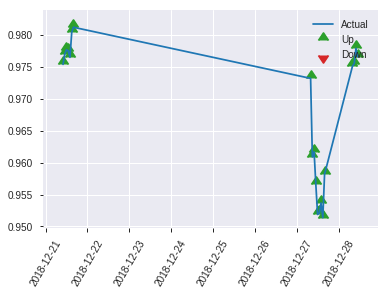


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3060238553945702
RMSE: 0.5531942293576192
LogLoss: 0.834890615838397
Mean Per-Class Error: 0.4188405797101449
AUC: 0.5672049689440993
pr_auc: 0.520671133964473
Gini: 0.13440993788819866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3982413411140442: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    109  0.9478   (109.0/115.0)
1      1    104  0.0095   (1.0/105.0)
Total  7    213  0.5      (110.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398241     0.654088  212
max f2                       0.398241     0.821485  212
max f0point5                 0.772101     0.555556  83
max accuracy                 0.811724     0.590909  50
max precision                0.811724     0.647059  50
max recall                   0.293144     1         219
max specificity              0.911758     0.991304  0
max absolute_mcc             0.811724     0.186734  50
max min_per_class_accuracy   0.745435     0.542857  106
max mean_per_class_accuracy  0.772101     0.581159  83

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 70.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.897062           0.698413  0.698413           0.333333         0.904326  0.333333                    0.904326            0.00952381      0.00952381                 -30.1587  -30.1587
    2        0.0227273                   0.88929            1.04762   0.838095           0.5              0.890812  0.4                         0.89892             0.00952381      0.0190476                  4.7619    -16.1905
    3        0.0318182                   0.883068           0         0.598639           0                0.886695  0.285714                    0.895427            0               0.0190476                  -100      -40.1361
    4        0.0409091                   0.878112           0         0.465608           0                0.879648  0.222222                    0.891921            0               0.0190476                  -100      -53.4392
    5        0.05                        0.87048            1.04762   0.571429           0.5              0.8744    0.272727                    0.888735            0.00952381      0.0285714                  4.7619    -42.8571
    6        0.1                         0.845065           1.52381   1.04762            0.727273         0.859401  0.5                         0.874068            0.0761905       0.104762                   52.381    4.7619
    7        0.15                        0.832047           1.71429   1.26984            0.818182         0.839453  0.606061                    0.86253             0.0857143       0.190476                   71.4286   26.9841
    8        0.2                         0.817095           1.52381   1.33333            0.727273         0.82307   0.636364                    0.852665            0.0761905       0.266667                   52.381    33.3333
    9        0.3                         0.798177           0.952381  1.20635            0.454545         0.807769  0.575758                    0.837699            0.0952381       0.361905                   -4.7619   20.6349
    10       0.4                         0.76715            1.04762   1.16667            0.5              0.783362  0.556818                    0.824115            0.104762        0.466667                   4.7619    16.6667
    11       0.5                         0.739123           0.761905  1.08571            0.363636         0.753999  0.518182                    0.810092            0.0761905       0.542857                   -23.8095  8.57143
    12       0.6                         0.717358           0.952381  1.06349            0.454545         0.726502  0.507576                    0.79616             0.0952381       0.638095                   -4.7619   6.34921
    13       0.7                         0.644651           0.761905  1.02041            0.363636         0.689338  0.487013                    0.7809              0.0761905       0.714286                   -23.8095  2.04082
    14       0.8                         0.574406           1.2381    1.04762            0.590909         0.608087  0.5                         0.759298            0.12381         0.838095                   23.8095   4.7619
    15       0.9                         0.469064           0.666667  1.00529            0.318182         0.526133  0.479798                    0.733391            0.0666667       0.904762                   -33.3333  0.529101
    16       1                           0.293144           0.952381  1                  0.454545         0.405969  0.477273                    0.700649     

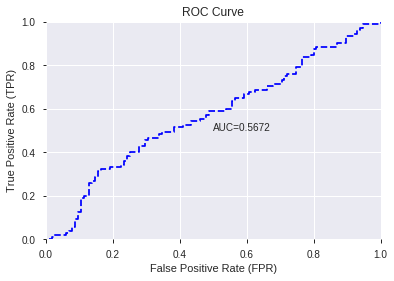

This function is available for GLM models only


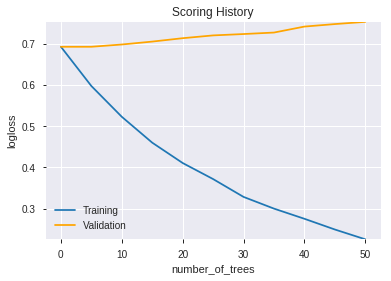

--2019-08-28 17:27:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_172629_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_172629_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'Open',
 'STOCHRSI_fastd',
 'High',
 'BOP',
 'HT_PHASOR_quadrature',
 'hour',
 'HT_DCPERIOD',
 'ADOSC',
 'STOCH_slowd',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'MFI_8',
 'STOCH_slowk',
 'DIV',
 'MFI_20',
 'TRANGE',
 'OBV',
 'WILLR_8',
 'DX_8',
 'CCI_8',
 'STDDEV_8',
 'ADX_8',
 'BETA_30',
 'ADXR_8',
 'CORREL_20',
 'MFI_12',
 'ULTOSC',
 'MINUS_DI_8',
 'MFI_30',
 'AD',
 'SAREXT',
 'aroonup_8',
 'MFI_14',
 'BETA_8',
 'MOM_8',
 'dayofyear',
 'ADXR_12',
 'CCI_14',
 'BETA_12',
 'CORREL_12',
 'BETA_14',
 'DX_30',
 'ADX_20',
 'day',
 'Low',
 'WILLR_12',
 'MOM_30',
 'CMO_8',
 'STDDEV_30',
 'AROONOSC_8',
 'ROC_12',
 'WILLR_24',
 'CCI_12',
 'DX_12',
 'CORREL_30',
 'MFI_24',
 'ADXR_14',
 'CORREL_14',
 'MINUS_DI_12',
 'Close',
 'DX_20',
 'LINEARREG_ANGLE_8',
 'MOM_12',
 'STOCHRSI_fastk',
 'ATR_8',
 'STDDEV_20',
 'MACDEXT_hist',
 'MACDFIX_hist_12',
 'LINEARREG_ANGLE_12',
 'PLUS_DM_8',
 'WILLR_30',
 'DX_14',
 'CORREL_24',
 'CORREL_8',
 'MOM_14',
 'SUB',
 'PLUS_DI_8',
 'BETA_20',
 'NATR_8',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

253

['MA_14_3',
 'MAVP_14_3',
 'BBANDS_upperband_14_3_2',
 'BBANDS_middleband_14_3_2',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'MA_14_4',
 'MAVP_14_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_middleband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_3',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_14_5_5',
 'MAVP_14_6',
 'BBANDS_middleband_14_6_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_middleband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_middleband_14_6_5',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lo

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_172834_model_4  0.524058  3.714153              0.483023  0.714049  0.509866
1  DeepLearning_grid_1_AutoML_20190828_172834_model_6  0.520497  0.693256              0.487785  0.500049  0.250049
2  DeepLearning_grid_1_AutoML_20190828_172834_model_1  0.518675  2.538660              0.448240  0.647820  0.419671
3  DeepLearning_grid_1_AutoML_20190828_172834_model_9  0.514203  0.692589              0.500000  0.499721  0.249721
4  DeepLearning_grid_1_AutoML_20190828_172834_model_8  0.500000  0.692228              0.500000  0.499540  0.249540
5               DeepLearning_1_AutoML_20190828_172834  0.497060  1.193493              0.483437  0.623077  0.388224
6  DeepLearning_grid_1_AutoML_20190828_172834_model_3  0.485880  2.493797              0.491304  0.702185  0.493063
7  DeepLearning_grid_1_AutoML_20190828_172834_model_7  0.483975  0.708893              0.500000  0.507725  0.257784
8  DeepLearning_grid_1_AutoML_20190828_172834_model_2  0.475859  1.752855              0.491304  0.653882  0.427561
9  DeepLearning_grid_1_AutoML_20190828_172834_model_5  0.451925  0.693509              0.486957  0.500181  0.250181

variable  relative_importance  scaled_importance  percentage
0                CDLTASUKIGAP             1.000000           1.000000    0.007330
1                         OBV             0.942871           0.942871    0.006912
2                         BOP             0.897918           0.897918    0.006582
3         CDLXSIDEGAP3METHODS             0.814902           0.814902    0.005974
4        HT_PHASOR_quadrature             0.790722           0.790722    0.005796
..                        ...                  ...                ...         ...
248   BBANDS_upperband_14_4_4             0.458376           0.458376    0.003360
249  BBANDS_middleband_20_6_3             0.458182           0.458182    0.003359
250  BBANDS_middleband_20_2_5             0.451987           0.451987    0.003313
251                 MAVP_14_4             0.447374           0.447374    0.003279
252                   MA_14_4             0.446006           0.446006    0.003269

[253 rows x 4 columns]

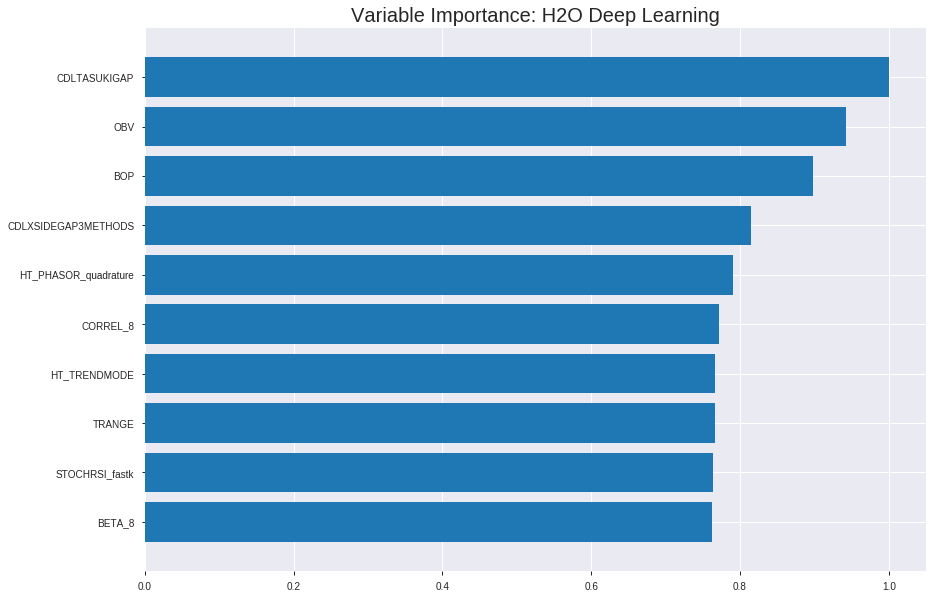

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_172834_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.13664618099340872
RMSE: 0.36965684221100076
LogLoss: 0.44005538661595905
Mean Per-Class Error: 0.18466014944888176
AUC: 0.8948514318232629
pr_auc: 0.8631598610580572
Gini: 0.7897028636465258
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48290607124585977: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      555  201  0.2659   (201.0/756.0)
1      96   685  0.1229   (96.0/781.0)
Total  651  886  0.1932   (297.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482906     0.821836  210
max f2                       0.23983      0.891667  288
max f0point5                 0.785316     0.839895  116
max accuracy                 0.736236     0.814574  132
max precision                0.999873     1         0
max recall                   0.0560882    1         367
max specificity              0.999873     1         0
max absolute_mcc             0.736236     0.632829  132
max min_per_class_accuracy   0.641307     0.810499  163
max mean_per_class_accuracy  0.736236     0.81534   132

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 56.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.999801           1.96799   1.96799            1                0.999908   1                           0.999908            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.999227           1.96799   1.96799            1                0.999494   1                           0.999708            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.998789           1.84499   1.92612            0.9375           0.999      0.978723                    0.999467            0.0192061       0.0588988                  84.499    92.6118
    4        0.0403383                   0.998021           1.96799   1.93625            1                0.998382   0.983871                    0.999204            0.0192061       0.078105                   96.799    93.6248
    5        0.0500976                   0.997406           1.96799   1.94243            1                0.997752   0.987013                    0.998921            0.0192061       0.0973111                  96.799    94.2431
    6        0.100195                    0.99233            1.78908   1.86576            0.909091         0.995136   0.948052                    0.997029            0.0896287       0.18694                    78.9082   86.5757
    7        0.150293                    0.983935           1.78908   1.8402             0.909091         0.988467   0.935065                    0.994175            0.0896287       0.276569                   78.9082   84.0198
    8        0.20039                     0.972621           1.8402    1.8402             0.935065         0.978064   0.935065                    0.990147            0.0921895       0.368758                   84.0198   84.0198
    9        0.299935                    0.925289           1.71074   1.79723            0.869281         0.952296   0.913232                    0.977585            0.170294        0.539052                   71.0736   79.7231
    10       0.40013                     0.830746           1.49516   1.72159            0.75974          0.880705   0.874797                    0.953325            0.149808        0.68886                    49.5161   72.1591
    11       0.500325                    0.65769            1.17568   1.61227            0.597403         0.744564   0.819246                    0.911519            0.117798        0.806658                   17.5682   61.2267
    12       0.59987                     0.425392           0.823211  1.48133            0.418301         0.539215   0.752711                    0.849737            0.0819462       0.888604                   -17.6789  48.1329
    13       0.700065                    0.238988           0.702853  1.36991            0.357143         0.322315   0.696097                    0.774251            0.0704225       0.959027                   -29.7147  36.9911
    14       0.79961                     0.119339           0.257254  1.23139            0.130719         0.175842   0.625712                    0.699754            0.0256082       0.984635                   -74.2746  23.1395
    15       0.899805                    0.0416761          0.15335   1.11135            0.0779221        0.0759916  0.564714                    0.630297            0.0153649       1                          -84.665   11.1352
    16       1                           0.000102973        0         1                  0                0.0179918  0.508133                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4688895236671372
RMSE: 0.6847550829801391
LogLoss: 3.1845538155174706
Mean Per-Class Error: 0.4467601246105919
AUC: 0.5113499480789201
pr_auc: 0.49230370233971016
Gini: 0.022699896157840183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.006563320872448906: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    214  0        (0.0/214.0)
Total  2    437  0.508    (223.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00656332   0.65745   397
max f2                       0.00656332   0.827533  397
max f0point5                 0.0441076    0.549422  382
max accuracy                 0.999696     0.558087  96
max precision                0.999696     0.574627  96
max recall                   0.00656332   1         397
max specificity              1            0.977778  0
max absolute_mcc             0.999696     0.115575  96
max min_per_class_accuracy   0.997557     0.509346  179
max mean_per_class_accuracy  0.999696     0.55324   96

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 84.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   1                  0.41028   0.41028            0.2              1         0.2                         1                   0.0046729       0.0046729                  -58.972   -58.972
    2        0.0205011                   1                  1.0257    0.683801           0.5              1         0.333333                    1                   0.00934579      0.0140187                  2.57009   -31.6199
    3        0.0318907                   0.999999           0.820561  0.732644           0.4              0.999999  0.357143                    1                   0.00934579      0.0233645                  -17.9439  -26.7356
    4        0.0410023                   0.999999           1.53855   0.911734           0.75             0.999999  0.444444                    1                   0.0140187       0.0373832                  53.8551   -8.82658
    5        0.0501139                   0.999998           0.51285   0.83921            0.25             0.999998  0.409091                    0.999999            0.0046729       0.0420561                  -48.715   -16.079
    6        0.100228                    0.999985           1.21219   1.0257             0.590909         0.999992  0.5                         0.999996            0.0607477       0.102804                   21.2192   2.57009
    7        0.150342                    0.999961           1.11895   1.05678            0.545455         0.999977  0.515152                    0.99999             0.0560748       0.158879                   11.8946   5.67828
    8        0.200456                    0.999902           1.0257    1.04901            0.5              0.999935  0.511364                    0.999976            0.0514019       0.21028                    2.57009   4.90123
    9        0.300683                    0.999696           1.39868   1.16557            0.681818         0.999812  0.568182                    0.999921            0.140187        0.350467                   39.8683   16.5569
    10       0.400911                    0.999052           0.652719  1.03736            0.318182         0.999412  0.505682                    0.999794            0.0654206       0.415888                   -34.7281  3.73566
    11       0.501139                    0.997401           0.932455  1.01638            0.454545         0.998227  0.495455                    0.99948             0.0934579       0.509346                   -6.75446  1.63764
    12       0.599089                    0.989836           0.858726  0.990601           0.418605         0.994268  0.48289                     0.998628            0.0841121       0.593458                   -14.1274  -0.93991
    13       0.699317                    0.956093           0.885833  0.975585           0.431818         0.980538  0.47557                     0.996036            0.088785        0.682243                   -11.4167  -2.44147
    14       0.799544                    0.711673           0.979078  0.976023           0.477273         0.853343  0.475783                    0.978148            0.0981308       0.780374                   -2.09218  -2.39769
    15       0.899772                    0.291965           1.21219   1.00233            0.590909         0.501219  0.488608                    0.925022            0.121495        0.901869                   21.2192   0.233053
    16       1                           0.00391187         0.979078  1                  0.477273         0.100856  0.487472                    0.842418  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:31:50  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:31:55  6.090 sec         295 obs/sec       1         1             1537       0.68292          8.78934             -0.866012      0.529344        0.201816           1.08046          0.486662                         0.706921           14.8752               -1.0002          0.507622          0.066822             0.964005           0.501139
    2019-08-28 17:32:04  15.365 sec        336 obs/sec       3         3             4611       0.662234         3.57098             -0.754679      0.563402        0.385618           1.22999          0.491867                         0.703727           8.61925               -0.982173        0.496282          0.212676             1.23084            0.503417
    2019-08-28 17:32:15  26.384 sec        387 obs/sec       6         6             9222       0.636623         2.7606              -0.621584      0.569062        0.417001           1.35299          0.482108                         0.701639           7.6975                -0.970426        0.501734          0.232803             0.820561           0.507973
    2019-08-28 17:32:25  35.788 sec        426 obs/sec       9         9             13833      0.615721         1.88133             -0.516851      0.615337        0.494523           1.59899          0.487313                         0.697649           5.53965               -0.948081        0.509917          0.437804             0.820561           0.512528
    2019-08-28 17:32:33  44.405 sec        458 obs/sec       12        12            18444      0.586714         1.58437             -0.377299      0.634024        0.539285           1.47599          0.471698                         0.689128           5.23399               -0.900785        0.510758          0.448064             0.41028            0.510251
    2019-08-28 17:32:41  52.467 sec        484 obs/sec       15        15            23055      0.537873         1.13863             -0.157535      0.67302         0.597683           1.47599          0.413142                         0.684594           4.18566               -0.875856        0.514652          0.504542             0.41028            0.512528
    2019-08-28 17:32:51  1 min  2.357 sec  515 obs/sec       19        19            29203      0.49178          0.857031            0.0323555      0.735927        0.670002           1.47599          0.327261                         0.684339           3.85669               -0.874457        0.5092            0.4957               0.820561           0.505695
    2019-08-28 17:33:01  1 min 11.948 sec  539 obs/sec       23        23            35351      0.457712         0.704202            0.161778       0.794626        0.730929           1.72199          0.281718                         0.687311           3.31092               -0.890774        0.514112          0.497043             0.41028            0.503417
    2019-08-28 17:33:10

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLTASUKIGAP              1.0                    1.0                  0.007330365500388861
OBV                       0.9428707957267761     0.9428707957267761   0.006911587552319753
BOP                       0.897918164730072      0.897918164730072    0.006582068336909802
CDLXSIDEGAP3METHODS       0.814902126789093      0.814902126789093    0.005973530436408277
HT_PHASOR_quadrature      0.7907222509384155     0.7907222509384155   0.005796283108668785
---                       ---                    ---                  ---
BBANDS_upperband_14_4_4   0.458376407623291      0.458376407623291    0.003360066604633954
BBANDS_middleband_20_6_3  0.4581824839115143     0.4581824839115143   0.003358645072947439
BBANDS_middleband_20_2_5  0.45198699831962585    0.45198699831962585  0.0033132298991065037
MAVP_14_4                 0.4473743438720703     0.4473743438720703   0.003279417456078927
MA_14_4                   0.44600561261177063    0.44600561261177063  0.0032693841556691223


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6520376175548589)

('auc', 0.5240579710144927)

('logloss', 3.714153249822118)

('mean_per_class_error', 0.45258799171842656)

('rmse', 0.7140488992335103)

('mse', 0.5098658304965877)

deeplearning prediction progress: |███████████████████████████████████████| 100%


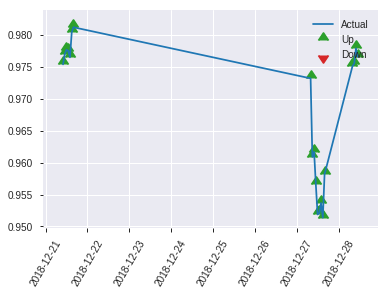


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5098658304965877
RMSE: 0.7140488992335103
LogLoss: 3.714153249822118
Mean Per-Class Error: 0.45258799171842656
AUC: 0.5240579710144927
pr_auc: 0.5099650923714742
Gini: 0.04811594202898539
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9091547792680615: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    110  0.9565   (110.0/115.0)
1      1    104  0.0095   (1.0/105.0)
Total  6    214  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.909155     0.652038  211
max f2                       0.834531     0.822884  215
max f0point5                 0.992937     0.548217  160
max accuracy                 0.999997     0.554545  8
max precision                1            1         0
max recall                   0.834531     1         215
max specificity              1            1         0
max absolute_mcc             0.999997     0.156582  8
max min_per_class_accuracy   0.999024     0.504762  105
max mean_per_class_accuracy  0.992937     0.547412  160

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 98.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   1                  2.09524   2.09524            1                1         1                           1                   0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.999999           1.04762   1.67619            0.5              1         0.8                         1                   0.00952381      0.0380952                  4.7619    67.619
    3        0.0318182                   0.999998           1.04762   1.4966             0.5              0.999999  0.714286                    0.999999            0.00952381      0.047619                   4.7619    49.6599
    4        0.0409091                   0.999997           2.09524   1.62963            1                0.999998  0.777778                    0.999999            0.0190476       0.0666667                  109.524   62.963
    5        0.05                        0.999997           2.09524   1.71429            1                0.999997  0.818182                    0.999999            0.0190476       0.0857143                  109.524   71.4286
    6        0.1                         0.999992           0.952381  1.33333            0.454545         0.999995  0.636364                    0.999997            0.047619        0.133333                   -4.7619   33.3333
    7        0.15                        0.999983           0.380952  1.01587            0.181818         0.999988  0.484848                    0.999994            0.0190476       0.152381                   -61.9048  1.5873
    8        0.2                         0.999966           0.952381  1                  0.454545         0.999972  0.477273                    0.999989            0.047619        0.2                        -4.7619   0
    9        0.3                         0.999867           0.952381  0.984127           0.454545         0.999931  0.469697                    0.999969            0.0952381       0.295238                   -4.7619   -1.5873
    10       0.4                         0.999479           1.04762   1                  0.5              0.999732  0.477273                    0.99991             0.104762        0.4                        4.7619    0
    11       0.5                         0.998939           1.04762   1.00952            0.5              0.999213  0.481818                    0.999771            0.104762        0.504762                   4.7619    0.952381
    12       0.6                         0.997778           1.04762   1.01587            0.5              0.998314  0.484848                    0.999528            0.104762        0.609524                   4.7619    1.5873
    13       0.7                         0.995738           1.2381    1.04762            0.590909         0.996841  0.5                         0.999144            0.12381         0.733333                   23.8095   4.7619
    14       0.8                         0.986304           0.952381  1.03571            0.454545         0.99159   0.494318                    0.9982              0.0952381       0.828571                   -4.7619   3.57143
    15       0.9                         0.961875           0.571429  0.984127           0.272727         0.976232  0.469697                    0.995759            0.0571429       0.885714                   -42.8571  -1.5873
    16       1                           0.806796           1.14286   1                  0.545455         0.921839  0.477273                    0.988367            0.114286     

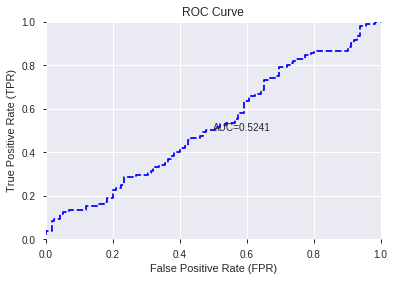

This function is available for GLM models only


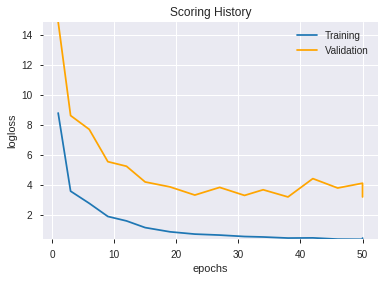

--2019-08-28 17:39:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_172834_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_172834_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTASUKIGAP',
 'OBV',
 'BOP',
 'CDLXSIDEGAP3METHODS',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'HT_TRENDMODE',
 'TRANGE',
 'STOCHRSI_fastk',
 'BETA_8',
 'CDLSHOOTINGSTAR',
 'AD',
 'CDLDRAGONFLYDOJI',
 'aroonup_8',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'BETA_20',
 'STOCHRSI_fastd',
 'CDLHIKKAKE',
 'aroonup_20',
 'MFI_8',
 'CORREL_14',
 'ADOSC',
 'HT_DCPERIOD',
 'CDLMATCHINGLOW',
 'MFI_20',
 'aroondown_14',
 'CDLRICKSHAWMAN',
 'DX_8',
 'aroonup_30',
 'STOCH_slowd',
 'ADXR_14',
 'VAR_8',
 'ROC_24',
 'MFI_12',
 'VAR_14',
 'CDLENGULFING',
 'VAR_12',
 'ADX_24',
 'STDDEV_12',
 'STOCH_slowk',
 'AROONOSC_20',
 'WILLR_8',
 'ATR_20',
 'ROCP_24',
 'ROCR_14',
 'DX_12',
 'ROCR_24',
 'ROC_14',
 'NATR_20',
 'ROCR_8',
 'NATR_24',
 'ROCP_8',
 'ROC_30',
 'DX_30',
 'MOM_24',
 'ROCP_30',
 'BBANDS_upperband_30_7_5',
 'ATR_24',
 'MINUS_DM_30',
 'LINEARREG_SLOPE_14',
 'ADX_20',
 'NATR_30',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'PLUS_DM_24',
 'NATR_14',
 'PLUS_DI_14',
 'ROC_8',
 '

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_173949_model_1  0.499379  0.71191              0.491304  0.509194  0.259278

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD         7.641349e-03           1.000000    0.021000
1                CDLLONGLINE         5.884061e-03           0.770029    0.016171
2                   CORREL_8         5.680504e-03           0.743390    0.015611
3           CDLDRAGONFLYDOJI         5.546289e-03           0.725826    0.015242
4             STOCHRSI_fastd         5.506054e-03           0.720561    0.015132
..                       ...                  ...                ...         ...
248       LINEARREG_SLOPE_14         3.295690e-05           0.004313    0.000091
249               PLUS_DM_20         2.523993e-05           0.003303    0.000069
250                PLUS_DI_8         2.057194e-05           0.002692    0.000057
251             aroondown_14         3.529122e-06           0.000462    0.000010
252  BBANDS_lowerband_20_3_5         7.562794e-07           0.000099    0.000002

[253 rows x 4 columns]

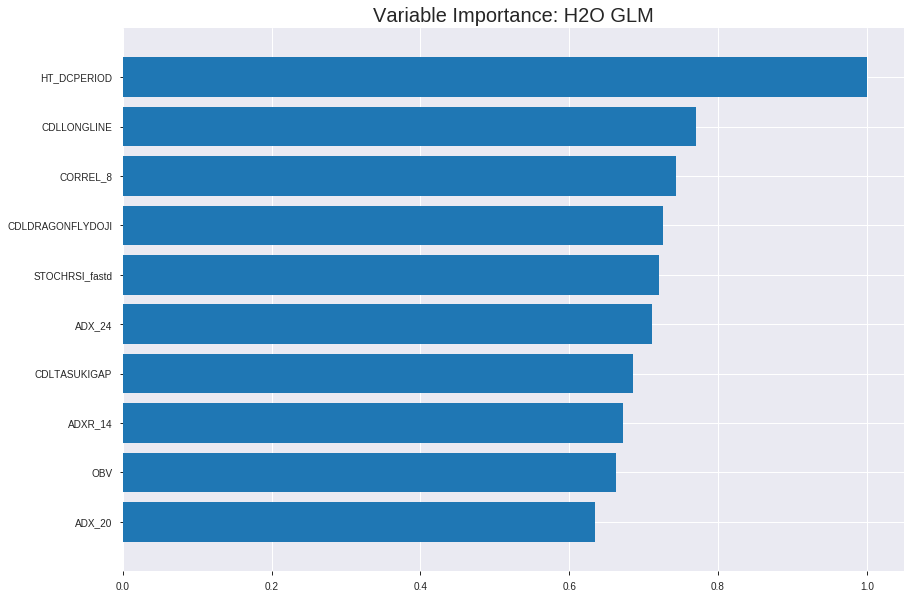

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_173949_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24756013264368468
RMSE: 0.4975541504637306
LogLoss: 0.6882562597008689
Null degrees of freedom: 1536
Residual degrees of freedom: 1283
Null deviance: 2130.327778804599
Residual deviance: 2115.699742320471
AIC: 2623.699742320471
AUC: 0.5626706366142986
pr_auc: 0.560649064752912
Gini: 0.12534127322859723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44340619470222264: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    748   0.9894   (748.0/756.0)
1      3    778   0.0038   (3.0/781.0)
Total  11   1526  0.4886   (751.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443406     0.674469  392
max f2                       0.438158     0.837983  398
max f0point5                 0.490831     0.579441  258
max accuracy                 0.500636     0.562134  221
max precision                0.573699     1         0
max recall                   0.438158     1         398
max specificity              0.573699     1         0
max absolute_mcc             0.500636     0.123418  221
max min_per_class_accuracy   0.5089       0.542894  189
max mean_per_class_accuracy  0.500636     0.560631  221

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.564669           1.35299   1.35299            0.6875           0.568181  0.6875                      0.568181            0.0140845       0.0140845                  35.2993   35.2993
    2        0.0201692                   0.560755           1.31199   1.33315            0.666667         0.56272   0.677419                    0.565538            0.0128041       0.0268886                  31.1993   33.3154
    3        0.0305791                   0.55631            1.10699   1.25616            0.5625           0.558272  0.638298                    0.563065            0.0115237       0.0384123                  10.6994   25.6164
    4        0.0403383                   0.554352           1.04959   1.20619            0.533333         0.55528   0.612903                    0.561181            0.0102433       0.0486556                  4.95945   20.6187
    5        0.0500976                   0.553127           0.655997  1.09901            0.333333         0.553721  0.558442                    0.559728            0.00640205      0.0550576                  -34.4003  9.90073
    6        0.100195                    0.545962           1.2268    1.1629             0.623377         0.549608  0.590909                    0.554668            0.0614597       0.116517                   22.6799   16.2903
    7        0.150293                    0.540523           1.15012   1.15864            0.584416         0.542935  0.588745                    0.550757            0.0576184       0.174136                   15.0124   15.8643
    8        0.20039                     0.535919           1.07345   1.13734            0.545455         0.538137  0.577922                    0.547602            0.0537772       0.227913                   7.3449    13.7345
    9        0.299935                    0.528099           1.00329   1.09285            0.509804         0.531995  0.555315                    0.542422            0.099872        0.327785                   0.32889   9.28533
    10       0.40013                     0.518815           1.03511   1.07839            0.525974         0.523715  0.547967                    0.537738            0.103713        0.431498                   3.51115   7.83944
    11       0.500325                    0.508825           1.11179   1.08508            0.564935         0.513754  0.551365                    0.532935            0.111396        0.542894                   11.1786   8.50815
    12       0.59987                     0.499911           1.13192   1.09285            0.575163         0.504563  0.555315                    0.528227            0.112676        0.65557                    13.1916   9.28533
    13       0.700065                    0.491188           0.971216  1.07544            0.493506         0.495565  0.546468                    0.523552            0.0973111       0.752881                   -2.87843  7.54442
    14       0.79961                     0.480374           0.784623  1.03924            0.398693         0.48655   0.528072                    0.518946            0.078105        0.830986                   -21.5377  3.92395
    15       0.899805                    0.466274           0.894541  1.02313            0.454545         0.473503  0.519884                    0.513886            0.0896287       0.920615                   -10.5459  2.3127
    16       1                           0.435977           0.792308  1                  0.402597         0.456469  0.508133                    0.508133          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25358406317599896
RMSE: 0.503571308928536
LogLoss: 0.700360621241992
Null degrees of freedom: 438
Residual degrees of freedom: 185
Null deviance: 609.0572554147116
Residual deviance: 614.9166254504689
AIC: 1122.916625450469
AUC: 0.519460020768432
pr_auc: 0.5067897817265227
Gini: 0.038920041536864014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5139242133669859: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    222  0.9867   (222.0/225.0)
1      1    213  0.0047   (1.0/214.0)
Total  4    435  0.508    (223.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.513924     0.656394   395
max f2                       0.510467     0.826255   399
max f0point5                 0.543715     0.549491   261
max accuracy                 0.544143     0.539863   259
max precision                0.58172      0.75       7
max recall                   0.510467     1          399
max specificity              0.585322     0.995556   0
max absolute_mcc             0.543715     0.0927144  261
max min_per_class_accuracy   0.550859     0.509346   198
max mean_per_class_accuracy  0.543715     0.543915   261

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 55.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.58246            1.23084   1.23084            0.6              0.583942  0.6                         0.583942            0.0140187       0.0140187                  23.0841   23.0841
    2        0.0205011                   0.581021           1.53855   1.3676             0.75             0.581875  0.666667                    0.583023            0.0140187       0.0280374                  53.8551   36.7601
    3        0.0318907                   0.579831           1.64112   1.46529            0.8              0.580282  0.714286                    0.582044            0.0186916       0.046729                   64.1121   46.5287
    4        0.0410023                   0.579536           0.51285   1.25363            0.25             0.579682  0.611111                    0.581519            0.0046729       0.0514019                  -48.715   25.3634
    5        0.0501139                   0.5793             1.0257    1.21219            0.5              0.579424  0.590909                    0.581138            0.00934579      0.0607477                  2.57009   21.2192
    6        0.100228                    0.573809           1.0257    1.11895            0.5              0.576317  0.545455                    0.578728            0.0514019       0.11215                    2.57009   11.8946
    7        0.150342                    0.569237           0.745964  0.994619           0.363636         0.571546  0.484848                    0.576334            0.0373832       0.149533                   -25.4036  -0.538091
    8        0.200456                    0.566763           1.0257    1.00239            0.5              0.567972  0.488636                    0.574243            0.0514019       0.200935                   2.57009   0.238955
    9        0.300683                    0.561902           1.11895   1.04124            0.545455         0.564598  0.507576                    0.571028            0.11215         0.313084                   11.8946   4.12419
    10       0.400911                    0.556052           0.932455  1.01405            0.454545         0.559064  0.494318                    0.568037            0.0934579       0.406542                   -6.75446  1.40452
    11       0.501139                    0.550834           1.0257    1.01638            0.5              0.552749  0.495455                    0.56498             0.102804        0.509346                   2.57009   1.63764
    12       0.599089                    0.546297           1.09726   1.0296             0.534884         0.548588  0.501901                    0.5623              0.107477        0.616822                   9.72615   2.96009
    13       0.699317                    0.541746           0.979078  1.02236            0.477273         0.544205  0.498371                    0.559706            0.0981308       0.714953                   -2.09218  2.23599
    14       0.799544                    0.534255           0.979078  1.01693            0.477273         0.538196  0.495726                    0.55701             0.0981308       0.813084                   -2.09218  1.69343
    15       0.899772                    0.527614           1.0257    1.01791            0.5              0.530832  0.496203                    0.554094            0.102804        0.915888                   2.57009   1.79108
    16       1                           0.510467           0.83921   1                  0.409091         0.521896  0.487472                    0.550867      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:39:49  0.000 sec   2            3         254           1.37651           1.40072
    2019-08-28 17:39:50  0.140 sec   4            2.2       254           1.37507           1.40303
    2019-08-28 17:39:50  0.282 sec   6            1.6       254           1.37344           1.40504
    2019-08-28 17:39:50  0.489 sec   8            1.2       254           1.37156           1.40743
    2019-08-28 17:39:50  0.695 sec   10           0.84      254           1.3694            1.41052

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.6501547987616099)

('auc', 0.4993788819875777)

('logloss', 0.7119096179880189)

('mean_per_class_error', 0.46997929606625255)

('rmse', 0.5091935411423508)

('mse', 0.25927806234108697)

glm prediction progress: |████████████████████████████████████████████████| 100%


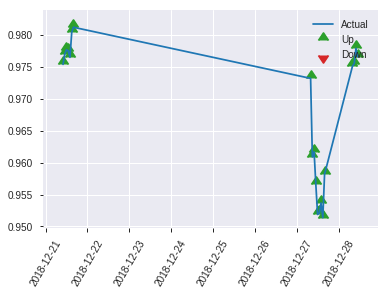


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25927806234108697
RMSE: 0.5091935411423508
LogLoss: 0.7119096179880189
Null degrees of freedom: 219
Residual degrees of freedom: -34
Null deviance: 305.36830916935537
Residual deviance: 313.2402319147283
AIC: 821.2402319147284
AUC: 0.4993788819875777
pr_auc: 0.482765218735351
Gini: -0.001242236024844634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.550150300695571: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    113  0.9826   (113.0/115.0)
1      0    105  0        (0.0/105.0)
Total  2    218  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55015      0.650155  217
max f2                       0.55015      0.822884  217
max f0point5                 0.555889     0.541977  208
max accuracy                 0.586562     0.545455  34
max precision                0.59445      0.666667  2
max recall                   0.55015      1         217
max specificity              0.604792     0.991304  0
max absolute_mcc             0.555889     0.093949  208
max min_per_class_accuracy   0.577243     0.478261  110
max mean_per_class_accuracy  0.586562     0.530021  34

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 57.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.594259           1.39683   1.39683            0.666667         0.598314  0.666667                    0.598314            0.0190476       0.0190476                  39.6825   39.6825
    2        0.0227273                   0.593174           0         0.838095           0                0.593358  0.4                         0.596331            0               0.0190476                  -100      -16.1905
    3        0.0318182                   0.592461           2.09524   1.19728            1                0.592791  0.571429                    0.59532             0.0190476       0.0380952                  109.524   19.7279
    4        0.0409091                   0.591583           1.04762   1.16402            0.5              0.592013  0.555556                    0.594585            0.00952381      0.047619                   4.7619    16.4021
    5        0.05                        0.59086            1.04762   1.14286            0.5              0.591266  0.545455                    0.593981            0.00952381      0.0571429                  4.7619    14.2857
    6        0.1                         0.588357           1.14286   1.14286            0.545455         0.589594  0.545455                    0.591788            0.0571429       0.114286                   14.2857   14.2857
    7        0.15                        0.586657           1.14286   1.14286            0.545455         0.587625  0.545455                    0.5904              0.0571429       0.171429                   14.2857   14.2857
    8        0.2                         0.584999           0.380952  0.952381           0.181818         0.585888  0.454545                    0.589272            0.0190476       0.190476                   -61.9048  -4.7619
    9        0.3                         0.581784           1.14286   1.01587            0.545455         0.583639  0.484848                    0.587394            0.114286        0.304762                   14.2857   1.5873
    10       0.4                         0.579493           0.952381  1                  0.454545         0.580683  0.477273                    0.585716            0.0952381       0.4                        -4.7619   0
    11       0.5                         0.577283           0.761905  0.952381           0.363636         0.578258  0.454545                    0.584225            0.0761905       0.47619                    -23.8095  -4.7619
    12       0.6                         0.574246           1.2381    1                  0.590909         0.575717  0.477273                    0.582807            0.12381         0.6                        23.8095   0
    13       0.7                         0.571112           0.952381  0.993197           0.454545         0.57263   0.474026                    0.581353            0.0952381       0.695238                   -4.7619   -0.680272
    14       0.8                         0.566796           1.04762   1                  0.5              0.568818  0.477273                    0.579786            0.104762        0.8                        4.7619    0
    15       0.9                         0.559929           0.952381  0.994709           0.454545         0.563531  0.474747                    0.57798             0.0952381       0.895238                   -4.7619   -0.529101
    16       1                           0.548088           1.04762   1                  0.5              0.555034  0.477273                    0.575685            0.104762   

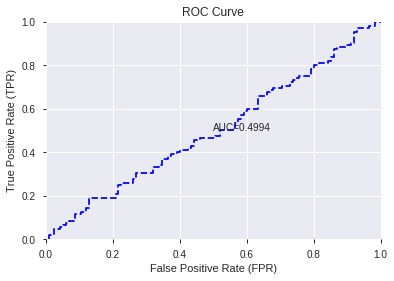

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


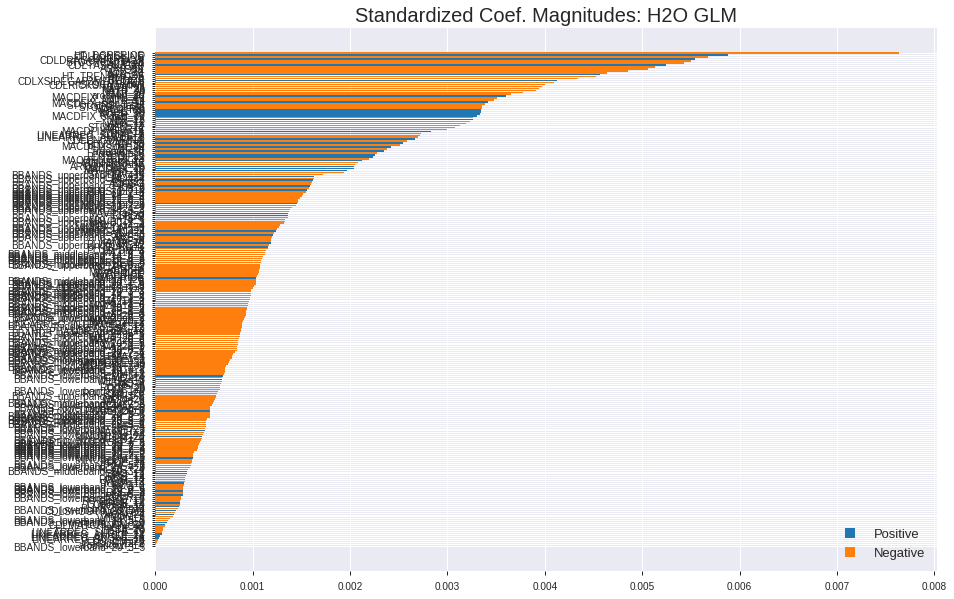

'log_likelihood'
--2019-08-28 17:39:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_173949_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_173949_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['HT_DCPERIOD',
 'CDLLONGLINE',
 'CORREL_8',
 'CDLDRAGONFLYDOJI',
 'STOCHRSI_fastd',
 'ADX_24',
 'CDLTASUKIGAP',
 'ADXR_14',
 'OBV',
 'ADX_20',
 'ATR_24',
 'HT_TRENDMODE',
 'ATR_20',
 'BETA_8',
 'CDLXSIDEGAP3METHODS',
 'STOCH_slowk',
 'CDLRICKSHAWMAN',
 'NATR_24',
 'NATR_30',
 'NATR_20',
 'MFI_20',
 'aroonup_20',
 'MACDFIX_signal_20',
 'NATR_14',
 'AD',
 'MACDFIX_signal_14',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'MACD_hist',
 'ROC_30',
 'ROCR_30',
 'ROCP_30',
 'MACDFIX_signal_12',
 'MFI_12',
 'DX_12',
 'NATR_12',
 'VAR_12',
 'STDDEV_12',
 'WILLR_8',
 'MACDFIX_hist_14',
 'TRIX_14',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'VAR_14',
 'CDLENGULFING',
 'ATR_8',
 'PLUS_DI_30',
 'MACDFIX_hist_20',
 'PLUS_DI_24',
 'VAR_8',
 'aroonup_30',
 'aroonup_8',
 'PLUS_DI_20',
 'TRIX_12',
 'MACDFIX_hist_24',
 'MINUS_DI_12',
 'CDLHIKKAKE',
 'AROONOSC_20',
 'MACDFIX_20',
 'MACDFIX_12',
 'MFI_30',
 'STDDEV_14',
 'BBANDS_upperband_14_4_5',
 'CMO_24',
 'BBANDS_upperband_14_4_4',
 'RSI_24',
 'ADOSC',
 'BBAN

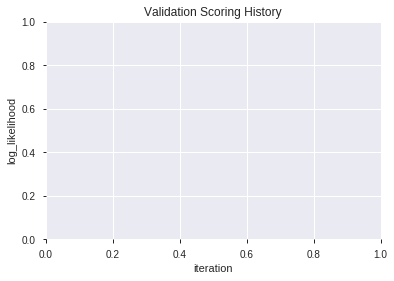

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_174008  0.544017  0.790001              0.500000  0.541466  0.293185
1               XGBoost_3_AutoML_20190828_174008  0.531346  0.809269              0.487785  0.546479  0.298639
2  XGBoost_grid_1_AutoML_20190828_174008_model_5  0.531014  0.827269              0.474741  0.550770  0.303348
3  XGBoost_grid_1_AutoML_20190828_174008_model_1  0.527329  0.860400              0.462940  0.562975  0.316941
4  XGBoost_grid_1_AutoML_20190828_174008_model_3  0.527039  0.854501              0.486957  0.560238  0.313867
5  XGBoost_grid_1_AutoML_20190828_174008_model_7  0.518178  0.856720              0.483023  0.562897  0.316853
6  XGBoost_grid_1_AutoML_20190828_174008_model_6  0.517681  0.796226              0.500000  0.543314  0.295190
7               XGBoost_2_AutoML_20190828_174008  0.511387  0.732425              0.451967  0.518159  0.268489
8  XGBoost_grid_1_AutoML_20190828_174008_model_2  0.461532  0.728427              0.486957  0.516713  0.266993
9  XGBoost_grid_1_AutoML_20190828_174008_model_4  0.448282  0.735927              0.495652  0.520181  0.270588

variable  relative_importance  scaled_importance  percentage
0                      TRANGE           182.985291           1.000000    0.025163
1              STOCHRSI_fastd           174.780777           0.955163    0.024034
2        HT_PHASOR_quadrature           173.487366           0.948095    0.023856
3                      MFI_20           159.985001           0.874305    0.022000
4                     BETA_20           158.163925           0.864353    0.021749
..                        ...                  ...                ...         ...
196    LINEARREG_INTERCEPT_14             2.237583           0.012228    0.000308
197  BBANDS_middleband_14_7_3             1.949298           0.010653    0.000268
198   BBANDS_lowerband_20_1_2             1.738815           0.009502    0.000239
199                 MAVP_20_5             1.192245           0.006516    0.000164
200  BBANDS_middleband_14_5_3             0.444318           0.002428    0.000061

[201 rows x 4 columns]

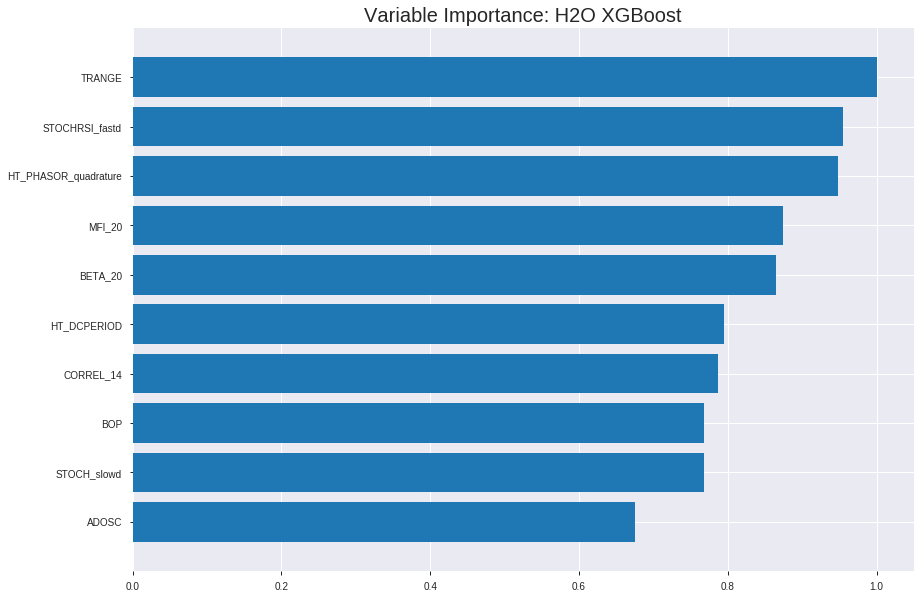

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_174008


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14860803114171603
RMSE: 0.3854971220926507
LogLoss: 0.4809376099021097
Mean Per-Class Error: 0.0877190753951318
AUC: 0.9717700140235351
pr_auc: 0.9715616684528087
Gini: 0.9435400280470703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5040486653645834: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      690  66   0.0873   (66.0/756.0)
1      69   712  0.0883   (69.0/781.0)
Total  759  778  0.0878   (135.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504049     0.913406  202
max f2                       0.447126     0.937885  240
max f0point5                 0.552157     0.927007  169
max accuracy                 0.508909     0.912167  199
max precision                0.867632     1         0
max recall                   0.353023     1         308
max specificity              0.867632     1         0
max absolute_mcc             0.508909     0.824453  199
max min_per_class_accuracy   0.504049     0.911652  202
max mean_per_class_accuracy  0.508909     0.912281  199

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.802666           1.96799    1.96799            1                0.820355  1                           0.820355            0.0204866       0.0204866                  96.799    96.799
    2        0.0201692                   0.778024           1.96799    1.96799            1                0.789641  1                           0.805493            0.0192061       0.0396927                  96.799    96.799
    3        0.0305791                   0.768898           1.96799    1.96799            1                0.774342  1                           0.794889            0.0204866       0.0601793                  96.799    96.799
    4        0.0403383                   0.755346           1.96799    1.96799            1                0.762808  1                           0.787127            0.0192061       0.0793854                  96.799    96.799
    5        0.0500976                   0.745144           1.96799    1.96799            1                0.749843  1                           0.779864            0.0192061       0.0985915                  96.799    96.799
    6        0.100195                    0.711313           1.96799    1.96799            1                0.726978  1                           0.753421            0.0985915       0.197183                   96.799    96.799
    7        0.150293                    0.688261           1.94243    1.95947            0.987013         0.698633  0.995671                    0.735158            0.0973111       0.294494                   94.2431   95.947
    8        0.20039                     0.661971           1.96799    1.9616             1                0.675167  0.996753                    0.720161            0.0985915       0.393086                   96.799    96.16
    9        0.299935                    0.614951           1.90368    1.94238            0.96732          0.637254  0.986985                    0.692645            0.189501        0.582586                   90.3676   94.2376
    10       0.40013                     0.566581           1.81464    1.91039            0.922078         0.591984  0.970732                    0.667439            0.181818        0.764405                   81.464    91.039
    11       0.500325                    0.50722            1.40571    1.80932            0.714286         0.537839  0.919376                    0.641485            0.140845        0.90525                    40.5707   80.9322
    12       0.59987                     0.45022            0.655997   1.61794            0.333333         0.477003  0.822126                    0.61419             0.0653009       0.970551                   -34.4003  61.7935
    13       0.700065                    0.395797           0.242804   1.42112            0.123377         0.422142  0.722119                    0.586704            0.0243278       0.994878                   -75.7196  42.1123
    14       0.79961                     0.355932           0.038588   1.24901            0.0196078        0.375309  0.634662                    0.560387            0.00384123      0.99872                    -96.1412  24.9009
    15       0.899805                    0.311324           0.0127792  1.11135            0.00649351       0.335808  0.564714                    0.53538             0.00128041      1                          -98.7221  11.1352
    16       1                           0.163304           0          1                  0                0.269182  0.508133                    0.508708 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2704707272682085
RMSE: 0.5200680025421757
LogLoss: 0.738136939936921
Mean Per-Class Error: 0.454392523364486
AUC: 0.5142367601246106
pr_auc: 0.5080189327965026
Gini: 0.02847352024922123
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2714308798313141: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    225  1        (225.0/225.0)
1      0    214  0        (0.0/214.0)
Total  0    439  0.5125   (225.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.271431     0.655436   399
max f2                       0.271431     0.826255   399
max f0point5                 0.394599     0.545645   383
max accuracy                 0.636814     0.548975   138
max precision                0.842311     1          0
max recall                   0.271431     1          399
max specificity              0.842311     1          0
max absolute_mcc             0.636814     0.0947824  138
max min_per_class_accuracy   0.599889     0.504673   192
max mean_per_class_accuracy  0.635499     0.545607   141

Gains/Lift Table: Avg response rate: 48.75 %, avg score: 59.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.805116           1.23084   1.23084            0.6              0.824034  0.6                         0.824034            0.0140187       0.0140187                  23.0841   23.0841
    2        0.0205011                   0.796091           1.0257    1.13967            0.5              0.801442  0.555556                    0.813993            0.00934579      0.0233645                  2.57009   13.9668
    3        0.0318907                   0.787392           0.41028   0.879172           0.2              0.792039  0.428571                    0.806152            0.0046729       0.0280374                  -58.972   -12.0828
    4        0.0410023                   0.766279           2.0514    1.13967            1                0.775502  0.555556                    0.799341            0.0186916       0.046729                   105.14    13.9668
    5        0.0501139                   0.761248           0.51285   1.0257             0.25             0.765391  0.5                         0.793168            0.0046729       0.0514019                  -48.715   2.57009
    6        0.100228                    0.732881           1.49193   1.25881            0.727273         0.744933  0.613636                    0.769051            0.0747664       0.126168                   49.1929   25.8815
    7        0.150342                    0.712809           0.745964  1.08786            0.363636         0.72331   0.530303                    0.753804            0.0373832       0.163551                   -25.4036  8.78646
    8        0.200456                    0.692854           1.0257    1.07232            0.5              0.703822  0.522727                    0.741308            0.0514019       0.214953                   2.57009   7.23237
    9        0.300683                    0.651854           1.0257    1.05678            0.5              0.670937  0.515152                    0.717851            0.102804        0.317757                   2.57009   5.67828
    10       0.400911                    0.626494           1.0257    1.04901            0.5              0.638434  0.511364                    0.697997            0.102804        0.420561                   2.57009   4.90123
    11       0.501139                    0.597883           0.83921   1.00705            0.409091         0.612061  0.490909                    0.68081             0.0841121       0.504673                   -16.079   0.705183
    12       0.599089                    0.568473           0.858726  0.982801           0.418605         0.583522  0.479087                    0.664903            0.0841121       0.588785                   -14.1274  -1.71991
    13       0.699317                    0.534574           1.11895   1.00231            0.545455         0.551806  0.488599                    0.648694            0.11215         0.700935                   11.8946   0.231362
    14       0.799544                    0.493533           1.0257    1.00525            0.5              0.515653  0.490028                    0.632016            0.102804        0.803738                   2.57009   0.524536
    15       0.899772                    0.453485           0.885833  0.991944           0.431818         0.476904  0.483544                    0.614738            0.088785        0.892523                   -11.4167  -0.805631
    16       1                           0.271431           1.07232   1                  0.522727         0.401079  0.487472                    0.593323  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:40:09  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.491867                         0.5                0.693147              0.5               0                    1                  0.512528
    2019-08-28 17:40:09  0.458 sec   5                  0.484971         0.663464            0.800539        0.793081           1.96799          0.279115                         0.5008             0.694748              0.50999           0.516041             1.64112            0.512528
    2019-08-28 17:40:09  0.611 sec   10                 0.471218         0.636865            0.863698        0.860343           1.96799          0.216005                         0.503994           0.701231              0.490135          0.494356             0.820561           0.512528
    2019-08-28 17:40:09  0.791 sec   15                 0.457125         0.610086            0.893408        0.891795           1.96799          0.18933                          0.504987           0.703403              0.518183          0.505198             0.820561           0.512528
    2019-08-28 17:40:10  0.962 sec   20                 0.444176         0.585902            0.915431        0.915304           1.96799          0.163956                         0.506699           0.707018              0.522191          0.513097             1.23084            0.512528
    2019-08-28 17:40:10  1.120 sec   25                 0.432374         0.564183            0.932269        0.932985           1.96799          0.152245                         0.508967           0.711901              0.512378          0.502674             1.64112            0.512528
    2019-08-28 17:40:10  1.245 sec   30                 0.421013         0.543539            0.945972        0.947732           1.96799          0.133377                         0.511546           0.717806              0.509917          0.49413              0.820561           0.512528
    2019-08-28 17:40:10  1.364 sec   35                 0.411349         0.526155            0.952284        0.953243           1.96799          0.117762                         0.513941           0.723533              0.508962          0.496272             1.23084            0.507973
    2019-08-28 17:40:10  1.491 sec   40                 0.402232         0.509952            0.958935        0.959357           1.96799          0.111256                         0.515165           0.726465              0.511859          0.502702             1.23084            0.512528
    2019-08-28 17:40:10  1.612 sec   45                 0.393327         0.494386            0.965705        0.965889           1.96799          0.0962915                        0.518417           0.734172              0.511225          0.502856             1.23084            0.512528
    2019-08-28 17:40:10  1.737 sec   50                 0.385497         0.480938            0.97177         0.971562           1.96799          0.0878334                        0.520068           0.738137              0.514237          0.508019             1.23084            0.512528

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ----------------------
TRANGE                    182.98529052734375     1.0                   0.02516255682671764
STOCHRSI_fastd            174.78077697753906     0.955162988641545     0.024034342980470334
HT_PHASOR_quadrature      173.48736572265625     0.9480945994220874    0.02385648423506237
MFI_20                    159.98500061035156     0.8743052523472906    0.021999755596086405
BETA_20                   158.16392517089844     0.8643532204970529    0.021749337029113497
---                       ---                    ---                   ---
LINEARREG_INTERCEPT_14    2.2375831604003906     0.012228213283985389  0.0003076931116475059
BBANDS_middleband_14_7_3  1.94929838180542       0.010652759990640524  0.00026805067862587623
BBANDS_lowerband_20_1_2   1.7388153076171875     0.009502486798835636  0.00023910686407083588
MAVP_20_5                 1.192244529724121      0.006515521145378417  0.00016394717107626482
BBANDS_middleband_14_5_3  0.4443178176879883     0.002428161391593349  6.109874900040943e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55)

('F1', 0.6461538461538462)

('auc', 0.544016563146998)

('logloss', 0.7900014235052505)

('mean_per_class_error', 0.44099378881987583)

('rmse', 0.5414660409459799)

('mse', 0.2931854734977136)

xgboost prediction progress: |████████████████████████████████████████████| 100%


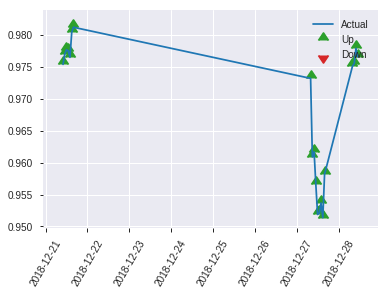


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2931854734977136
RMSE: 0.5414660409459799
LogLoss: 0.7900014235052505
Mean Per-Class Error: 0.44099378881987583
AUC: 0.544016563146998
pr_auc: 0.5128299864075708
Gini: 0.08803312629399596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4378562271595001: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    105  0        (0.0/105.0)
Total  0    220  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437856     0.646154  219
max f2                       0.437856     0.820313  219
max f0point5                 0.623338     0.559006  174
max accuracy                 0.68067      0.55      129
max precision                0.836259     1         0
max recall                   0.437856     1         219
max specificity              0.836259     1         0
max absolute_mcc             0.623338     0.146132  174
max min_per_class_accuracy   0.698345     0.530435  109
max mean_per_class_accuracy  0.623338     0.559006  174

Gains/Lift Table: Avg response rate: 47.73 %, avg score: 68.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.813456           2.09524   2.09524            1                0.824755  1                           0.824755            0.0285714       0.0285714                  109.524   109.524
    2        0.0227273                   0.802084           0         1.25714            0                0.803818  0.6                         0.81638             0               0.0285714                  -100      25.7143
    3        0.0318182                   0.795436           1.04762   1.19728            0.5              0.800072  0.571429                    0.811721            0.00952381      0.0380952                  4.7619    19.7279
    4        0.0409091                   0.792715           2.09524   1.39683            1                0.793056  0.666667                    0.807573            0.0190476       0.0571429                  109.524   39.6825
    5        0.05                        0.789933           1.04762   1.33333            0.5              0.792261  0.636364                    0.804789            0.00952381      0.0666667                  4.7619    33.3333
    6        0.1                         0.77635            0.952381  1.14286            0.454545         0.782773  0.545455                    0.793781            0.047619        0.114286                   -4.7619   14.2857
    7        0.15                        0.764539           0.952381  1.07937            0.454545         0.771228  0.515152                    0.786264            0.047619        0.161905                   -4.7619   7.93651
    8        0.2                         0.751273           0.761905  1                  0.363636         0.756549  0.477273                    0.778835            0.0380952       0.2                        -23.8095  0
    9        0.3                         0.735666           0.952381  0.984127           0.454545         0.743767  0.469697                    0.767145            0.0952381       0.295238                   -4.7619   -1.5873
    10       0.4                         0.719372           1.33333   1.07143            0.636364         0.727275  0.511364                    0.757178            0.133333        0.428571                   33.3333   7.14286
    11       0.5                         0.698007           1.04762   1.06667            0.5              0.707002  0.509091                    0.747143            0.104762        0.533333                   4.7619    6.66667
    12       0.6                         0.679009           1.14286   1.07937            0.545455         0.686645  0.515152                    0.73706             0.114286        0.647619                   14.2857   7.93651
    13       0.7                         0.651461           0.952381  1.06122            0.454545         0.664581  0.506494                    0.726706            0.0952381       0.742857                   -4.7619   6.12245
    14       0.8                         0.61917            1.14286   1.07143            0.545455         0.638506  0.511364                    0.715681            0.114286        0.857143                   14.2857   7.14286
    15       0.9                         0.590958           0.666667  1.02646            0.318182         0.605703  0.489899                    0.703461            0.0666667       0.92381                    -33.3333  2.6455
    16       1                           0.437856           0.761905  1                  0.363636         0.54061   0.477273                    0.687176            0.07

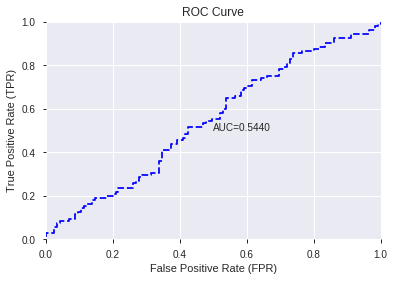

This function is available for GLM models only


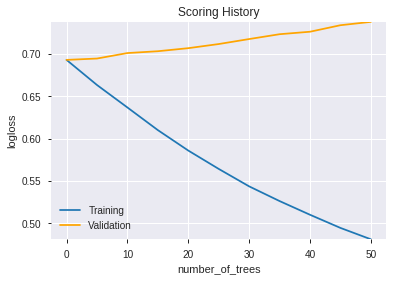

--2019-08-28 17:40:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_174008',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_174008',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8993',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_8993',
   'ty

['TRANGE',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'MFI_20',
 'BETA_20',
 'HT_DCPERIOD',
 'CORREL_14',
 'BOP',
 'STOCH_slowd',
 'ADOSC',
 'OBV',
 'MFI_8',
 'BETA_8',
 'MACDFIX_hist_24',
 'ROC_30',
 'DX_30',
 'MFI_12',
 'WILLR_24',
 'VAR_8',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_14',
 'MOM_24',
 'STDDEV_12',
 'ROC_8',
 'WILLR_8',
 'MACDEXT',
 'ADXR_14',
 'STOCH_slowk',
 'CCI_12',
 'MOM_8',
 'ADX_24',
 'CCI_20',
 'NATR_30',
 'NATR_12',
 'NATR_24',
 'PLUS_DM_8',
 'MACDFIX_signal_12',
 'AROONOSC_20',
 'MOM_12',
 'MINUS_DI_24',
 'MACDFIX_hist_20',
 'AD',
 'WILLR_20',
 'MINUS_DM_14',
 'WILLR_30',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_8',
 'MACD_hist',
 'MINUS_DM_20',
 'LINEARREG_ANGLE_14',
 'ROC_14',
 'CCI_24',
 'WILLR_12',
 'DX_8',
 'aroonup_20',
 'ADX_20',
 'PLUS_DM_30',
 'ROCP_14',
 'PLUS_DI_8',
 'MINUS_DI_12',
 'PLUS_DI_20',
 'aroonup_30',
 'MACDFIX_signal_20',
 'VAR_12',
 'PLUS_DI_14',
 'STDDEV_14',
 'BBANDS_lowerband_20_5_4',
 'MACDFIX_12',
 'aroonup_8',
 'ATR_20',
 'STOCHRSI_fastk',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.586
GLM             0.595
XGBoost         0.591
dtype: float64

DeepLearning    GLM  XGBoost
All          0.568  0.595    0.591
DLF          0.586  0.595    0.573
Fwe          0.582  0.595    0.591
RFE          0.555  0.545    0.550
XGBF         0.582  0.595    0.573





F1


DeepLearning    0.654
GLM             0.650
XGBoost         0.654
dtype: float64

DeepLearning    GLM  XGBoost
All          0.652  0.650    0.654
DLF          0.646  0.648    0.653
Fwe          0.646  0.650    0.654
RFE          0.652  0.650    0.646
XGBF         0.654  0.648    0.653





auc


DeepLearning    0.580
GLM             0.562
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.542  0.562    0.567
DLF          0.566  0.553    0.575
Fwe          0.565  0.562    0.567
RFE          0.524  0.499    0.544
XGBF         0.580  0.553    0.575





logloss


DeepLearning    3.714
GLM             0.722
XGBoost         0.835
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.722    0.835
DLF          0.745  0.700    0.780
Fwe          0.691  0.722    0.835
RFE          3.714  0.712    0.790
XGBF         0.789  0.700    0.780





mean_per_class_error


DeepLearning    0.453
GLM             0.470
XGBoost         0.441
dtype: float64

DeepLearning    GLM  XGBoost
All          0.435  0.408    0.419
DLF          0.418  0.410    0.423
Fwe          0.429  0.408    0.419
RFE          0.453  0.470    0.441
XGBF         0.428  0.410    0.423





rmse


DeepLearning    0.714
GLM             0.514
XGBoost         0.553
dtype: float64

DeepLearning    GLM  XGBoost
All          0.499  0.514    0.553
DLF          0.521  0.503    0.535
Fwe          0.499  0.514    0.553
RFE          0.714  0.509    0.541
XGBF         0.540  0.503    0.535





mse


DeepLearning    0.510
GLM             0.264
XGBoost         0.306
dtype: float64

DeepLearning    GLM  XGBoost
All          0.249  0.264    0.306
DLF          0.271  0.253    0.287
Fwe          0.249  0.264    0.306
RFE          0.510  0.259    0.293
XGBF         0.292  0.253    0.287

{'F1':       DeepLearning    GLM  XGBoost
 All          0.652    NaN      NaN
 DLF          0.646    NaN      NaN
 DLF            NaN  0.648      NaN
 DLF            NaN    NaN    0.653
 All            NaN  0.650      NaN
 All            NaN    NaN    0.654
 XGBF         0.654    NaN      NaN
 XGBF           NaN  0.648      NaN
 XGBF           NaN    NaN    0.653
 Fwe          0.646    NaN      NaN
 Fwe            NaN  0.650      NaN
 Fwe            NaN    NaN    0.654
 RFE          0.652    NaN      NaN
 RFE            NaN  0.650      NaN
 RFE            NaN    NaN    0.646,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.568    NaN      NaN
 DLF          0.586    NaN      NaN
 DLF            NaN  0.595      NaN
 DLF            NaN    NaN    0.573
 All            NaN  0.595      NaN
 All            NaN    NaN    0.591
 XGBF         0.582    NaN      NaN
 XGBF           NaN  0.595      NaN
 XGBF           NaN    NaN    0.573
 Fwe          0.582    NaN      NaN
 Fwe     